In [1]:
!pip install kaggle

In [7]:
import torch

# Vérifier si CUDA (GPU) est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du périphérique: {device}")


Utilisation du périphérique: cuda


In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download balraj98/deepglobe-land-cover-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.74G/2.74G [02:11<00:00, 21.0MB/s]
100% 2.74G/2.74G [02:11<00:00, 22.5MB/s]


In [8]:
!unzip 'deepglobe-land-cover-classification-dataset.zip' -d '/content/deepglobe_dataset'

Archive:  deepglobe-land-cover-classification-dataset.zip
  inflating: /content/deepglobe_dataset/class_dict.csv  
  inflating: /content/deepglobe_dataset/metadata.csv  
  inflating: /content/deepglobe_dataset/test/100877_sat.jpg  
  inflating: /content/deepglobe_dataset/test/103215_sat.jpg  
  inflating: /content/deepglobe_dataset/test/103742_sat.jpg  
  inflating: /content/deepglobe_dataset/test/110224_sat.jpg  
  inflating: /content/deepglobe_dataset/test/112946_sat.jpg  
  inflating: /content/deepglobe_dataset/test/114542_sat.jpg  
  inflating: /content/deepglobe_dataset/test/115800_sat.jpg  
  inflating: /content/deepglobe_dataset/test/118757_sat.jpg  
  inflating: /content/deepglobe_dataset/test/119896_sat.jpg  
  inflating: /content/deepglobe_dataset/test/120939_sat.jpg  
  inflating: /content/deepglobe_dataset/test/121151_sat.jpg  
  inflating: /content/deepglobe_dataset/test/123976_sat.jpg  
  inflating: /content/deepglobe_dataset/test/125014_sat.jpg  
  inflating: /content/de

In [9]:
import os
os.listdir('/content/deepglobe_dataset')


['test', 'train', 'metadata.csv', 'valid', 'class_dict.csv']

In [10]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [11]:
# !pip install torch torchvision --upgrade --user

In [12]:
!pip install segmentation-models-pytorch==0.2.0
# !pip install torch torchvision --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 29.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12403 sha256=a2b2706d95de537d4f69a04ccfc92db3679b3ecb27233a5ac1cd42896d2e99d8
  Stored in directory: /root/.cache/pip/wheels/61/3a/b0/0b4c443c380bd934701b0a25e4aed76479e4fcaf1a6f955664
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=4e79596939a679d4b362872a98964653eabd649168b9e4f5acd89dcdc8216ea1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing installation

In [13]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
# !pip install segmentation-models-pytorch
import torch
import torchvision
import albumentations as A
from torch import nn
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp

In [14]:
DATA_DIR = '/content/deepglobe_dataset' # DATA_DIR est le chemin vers le dossier qui contient les données nécessaires pour l'entraînement et la validation du modèle.

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))#Le fichier metadata.csv contient des informations sur les images et leurs masques correspondants.
metadata_df = metadata_df[metadata_df['split']=='train']#Filtrage des images de type "train"
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]#Sélection des colonnes pertinentes
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(723, 80)

In [15]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [16]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]
print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [17]:
# helper function for data visualization
import numpy as np
import matplotlib.pyplot as plt
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names

    plt.title(name.replace('_',' ').title(), fontsize=20)
    plt.imshow(image)
    plt.show()


In [18]:
import numpy as np

def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes.

    # Arguments
        label: The 2D array segmentation image label
        label_values: List of unique label values to encode

    # Returns
        A 3D array with the same width and height as the input, but
        with a depth size of num_classes (length of label_values).
    """

    # Initialisation d'une liste vide pour stocker les cartes de classe
    semantic_map = []

    # Boucle pour chaque valeur de classe dans label_values
    for colour in label_values:
        # Créer une carte binaire pour chaque classe
        equality = np.equal(label, colour)  # Vérifie où les pixels sont égaux à 'colour'
        class_map = np.all(equality, axis=-1)  # Crée une carte de classe (1 ou 0)
        semantic_map.append(class_map)  # Ajouter la carte de classe à la liste

    # Empiler toutes les cartes de classes le long de l'axe de la profondeur
    semantic_map = np.stack(semantic_map, axis=-1)

    # Retourner la carte de classes en one-hot
    return semantic_map



In [19]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x


In [20]:
# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization"""
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [21]:
import cv2
import torch
from torch.utils.data import Dataset

class LandCoverDataset(Dataset):
    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing (e.g. normalization, shape manipulation, etc.)
    """

    def __init__(self, df, class_rgb_values=None, augmentation=None, preprocessing=None):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        """Load an image and its corresponding mask, apply augmentation and preprocessing."""
        # Read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # One-hot encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # Apply augmentations if provided
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Apply preprocessing if provided
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        """Return the length of the dataset (number of images)."""
        return len(self.image_paths)


In [22]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=1024, width=1024, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=1024, width=1024, always_apply=True),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
            Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

In [23]:
"Model definition"

'Model definition'

In [24]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 396MB/s]


In [27]:
# Get train and val dataset instances
train_dataset = LandCoverDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)
valid_dataset = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)
# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


In [26]:
from google.colab import files
# Téléchargez le fichier sur Colab
uploaded = files.upload()

Saving best_model.pth to best_model.pth


In [29]:
# Assurez-vous que le fichier 'best_model.pth' est téléchargé
if 'best_model.pth' in uploaded:
    # Définir le chemin source et le chemin de destination
    source_path = '/content/best_model.pth'  # chemin où le fichier a été téléchargé
    destination_dir = '/content/deepglobe_dataset'  # répertoire cible
        # Déplacer le fichier dans le répertoire cible
    destination_path = os.path.join(destination_dir, 'best_model.pth')
    import shutil
    shutil.move(source_path, destination_path)

    print(f"Le fichier a été déplacé vers {destination_path}")
else:
    print("Le fichier 'best_model.pth' n'a pas été téléchargé.")

Le fichier a été déplacé vers /content/deepglobe_dataset/best_model.pth


In [30]:
import torch
import os

# Définir le chemin du modèle dans le répertoire /content/deepglobe_dataset
model_path = '/content/deepglobe_dataset/best_model.pth'

# Vérifier si le fichier existe
if os.path.exists(model_path):
    # Charger le modèle en utilisant torch.load()
    model = torch.load(model_path, map_location=torch.device('cpu'))  # 'cpu' si vous utilisez le CPU
    print('Loaded pre-trained DeepLabV3+ model!')
else:
    print(f"Le fichier {model_path} n'existe pas. Vérifiez l'emplacement du fichier.")

Loaded pre-trained DeepLabV3+ model!


In [31]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])
# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)
# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/deepglobe_dataset/best_model.pth'):
    model = torch.load('/content/deepglobe_dataset/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

Loaded pre-trained DeepLabV3+ model!


In [32]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [33]:
# !pip install torch torchvision --upgrade

In [38]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 80/80 [02:03<00:00,  1.55s/it, dice_loss - 0.2432, iou_score - 0.6903]
Model saved!

Epoch: 1
valid: 100%|██████████| 80/80 [02:01<00:00,  1.52s/it, dice_loss - 0.2418, iou_score - 0.6927]
Model saved!

Epoch: 2
valid: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it, dice_loss - 0.2527, iou_score - 0.679]

Epoch: 3
valid: 100%|██████████| 80/80 [02:04<00:00,  1.55s/it, dice_loss - 0.2779, iou_score - 0.6511]

Epoch: 4
valid: 100%|██████████| 80/80 [02:00<00:00,  1.51s/it, dice_loss - 0.2541, iou_score - 0.6759]
CPU times: user 14min 45s, sys: 1min 15s, total: 16min
Wall time: 1h 43min 11s


In [39]:
"Prediction on Test Data"

'Prediction on Test Data'

In [40]:
import os
import torch
# DEVICE = CUDA
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')
# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('/content/deepglobe_dataset/best_model.pth'):
    best_model = torch.load('/content/deepglobe_dataset/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


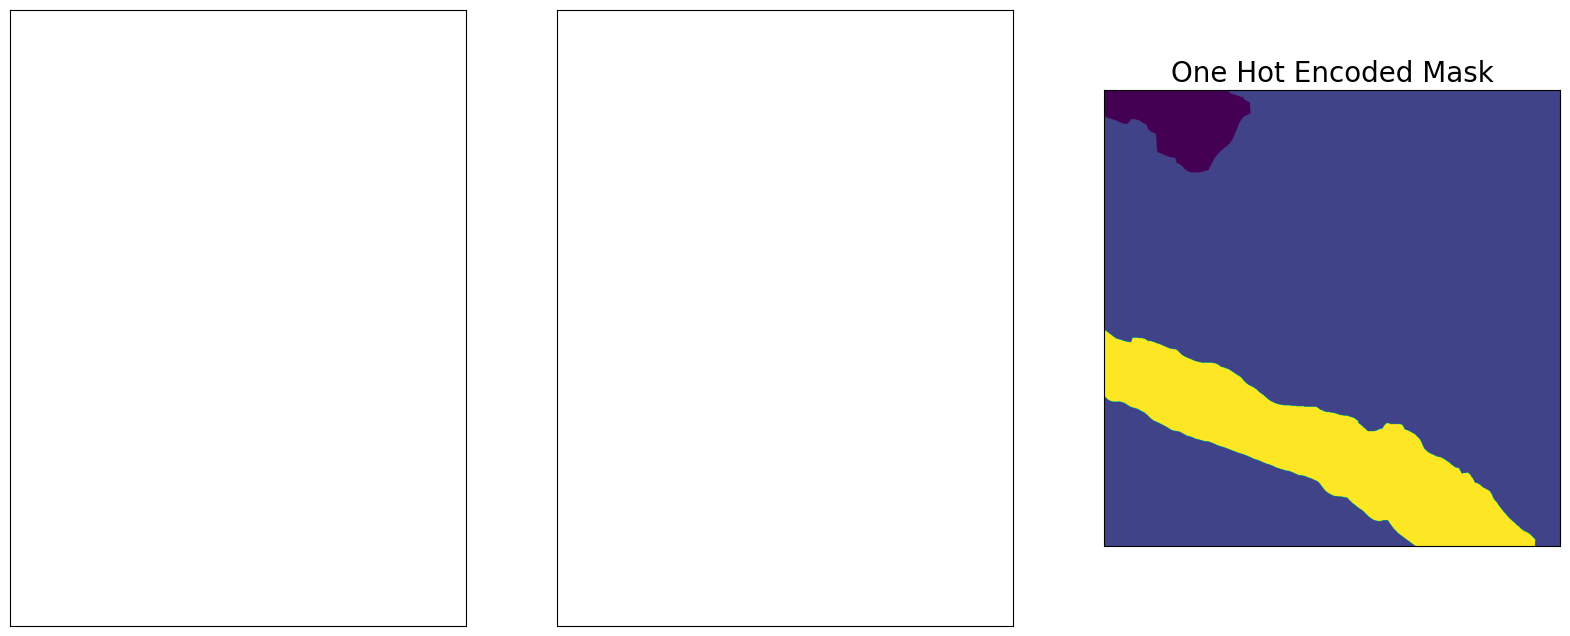

In [41]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)
# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)
# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [42]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [43]:
best_model = model

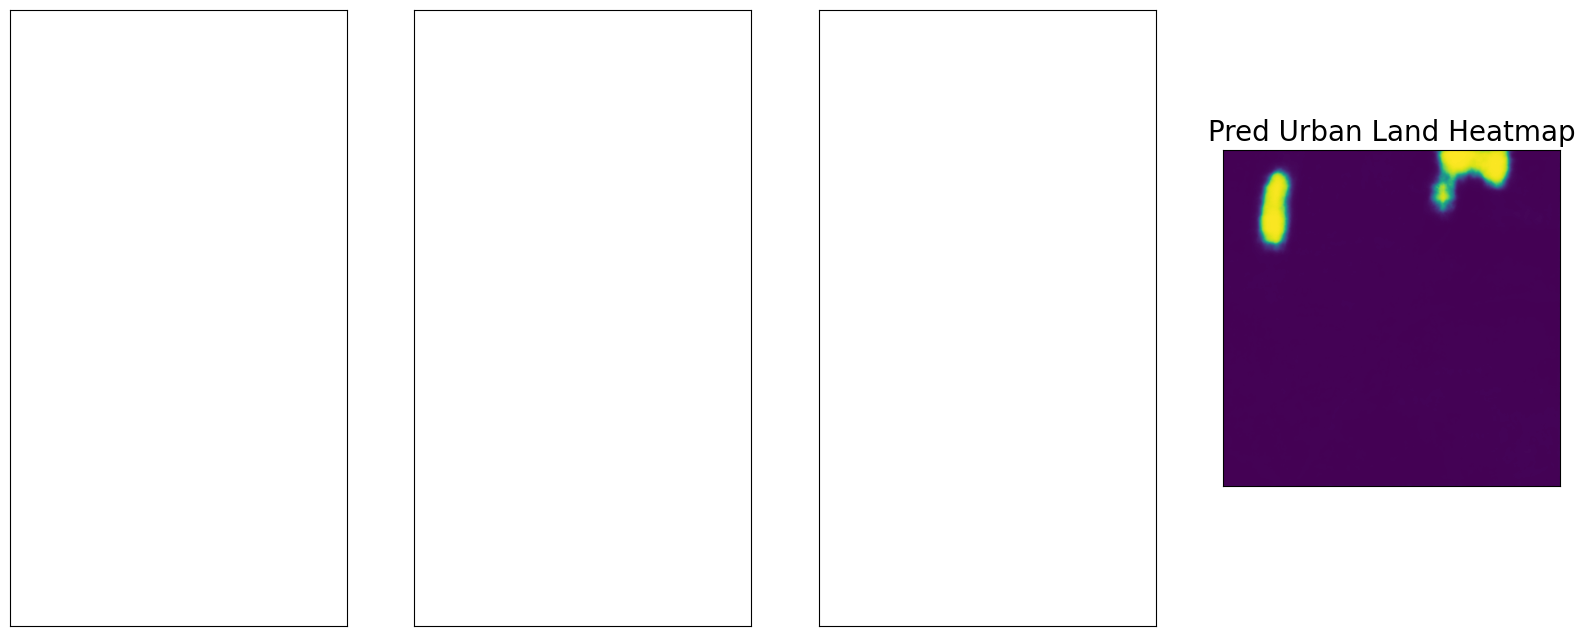

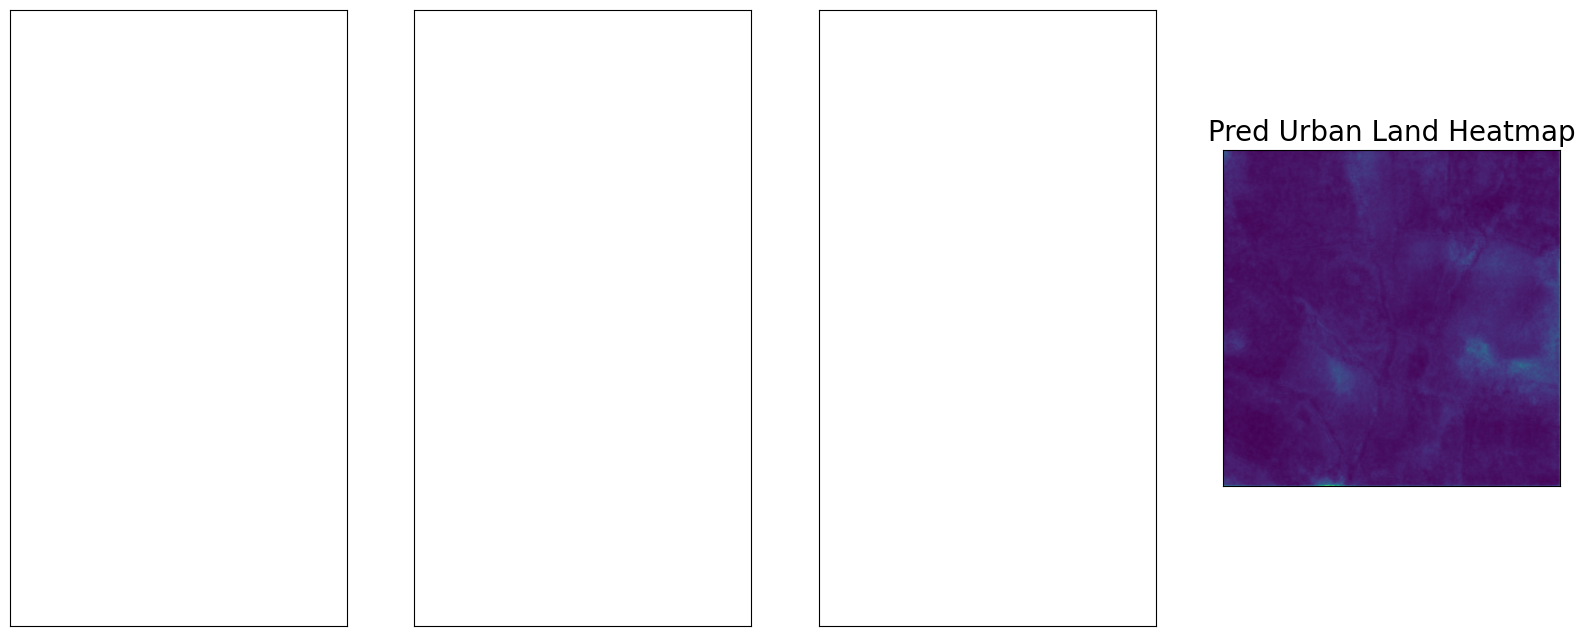

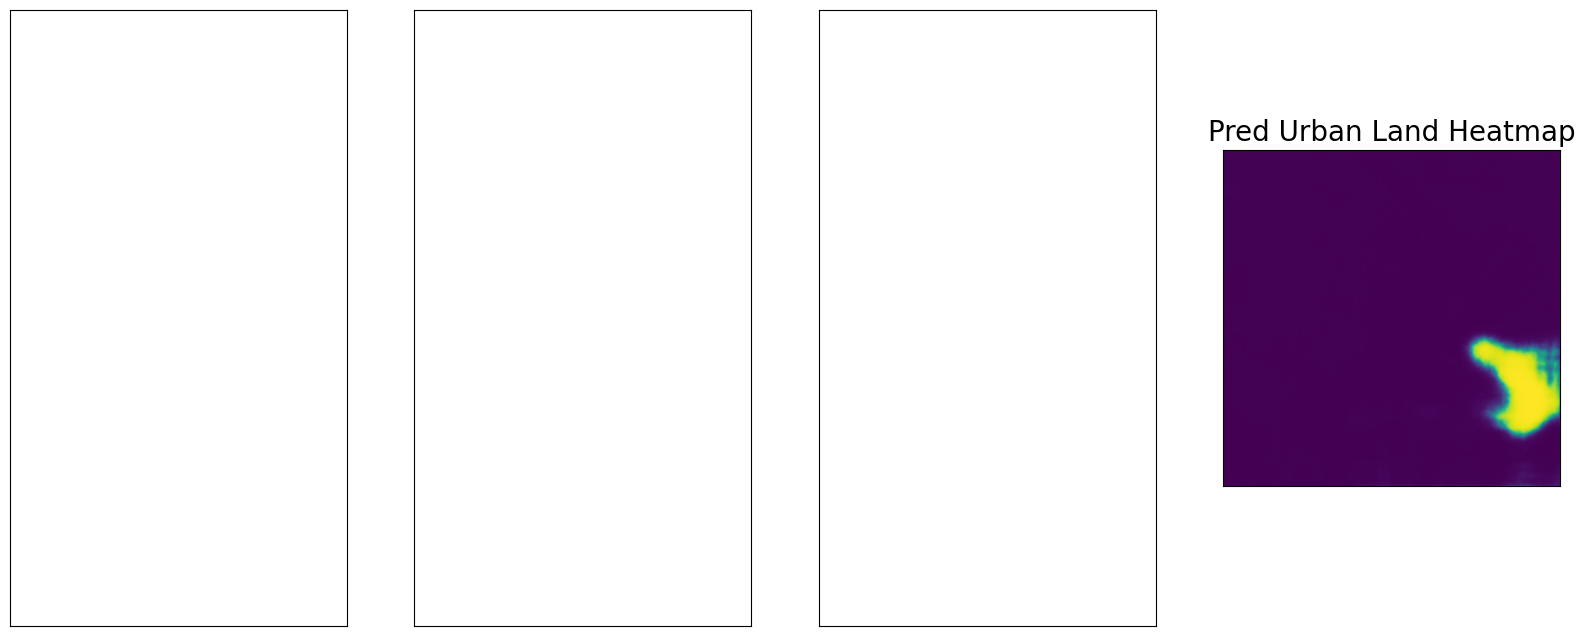

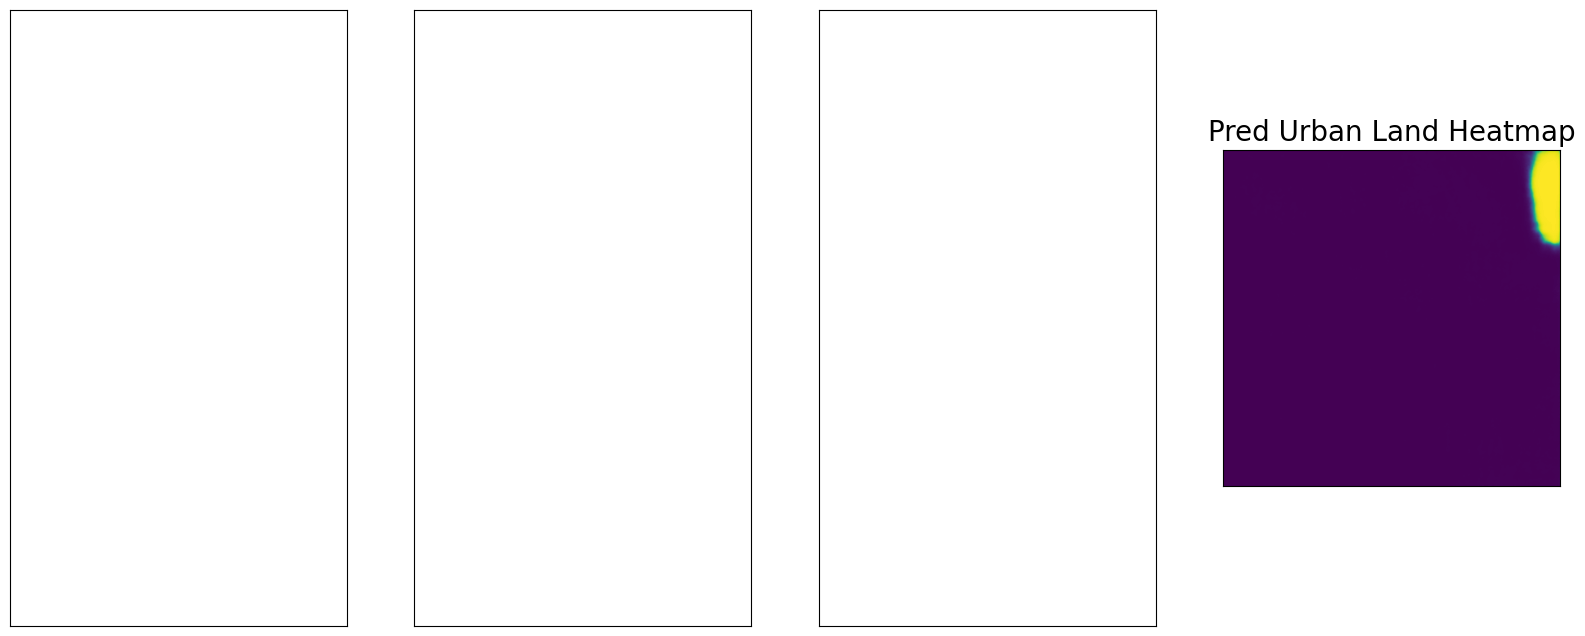

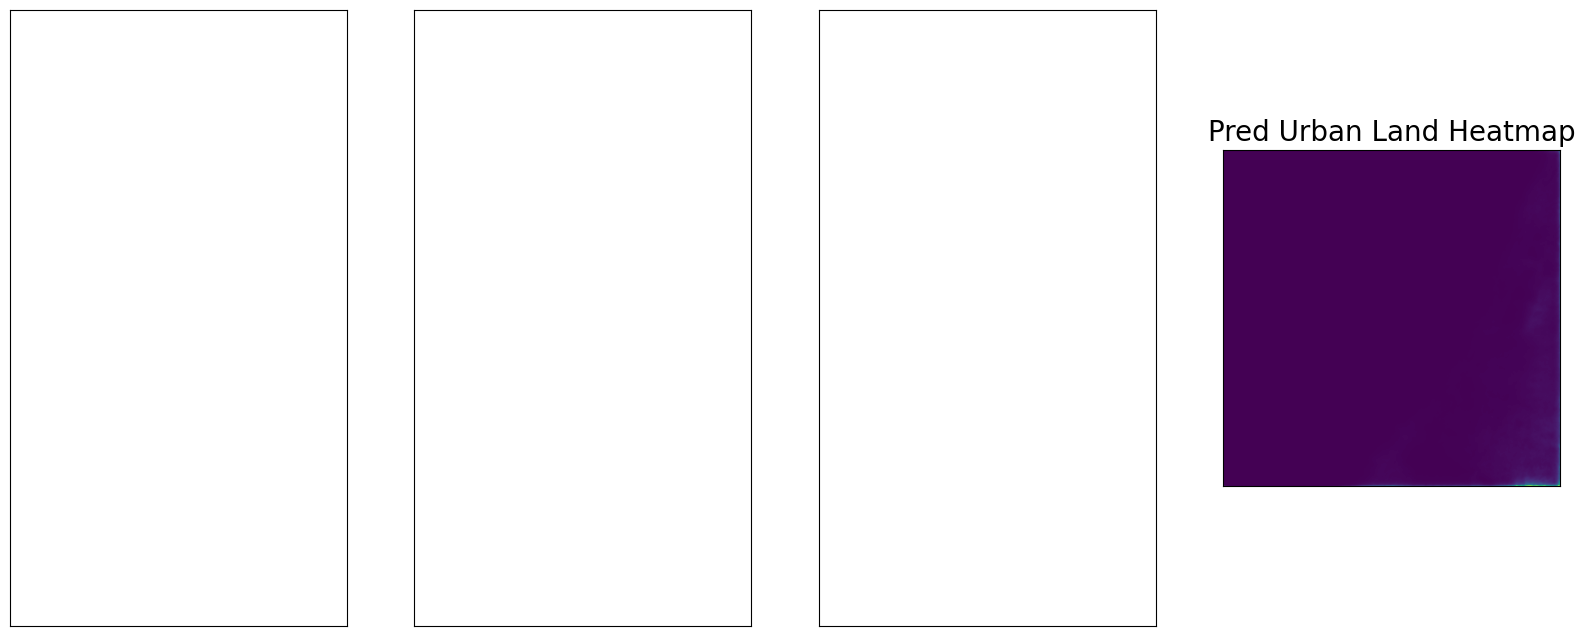

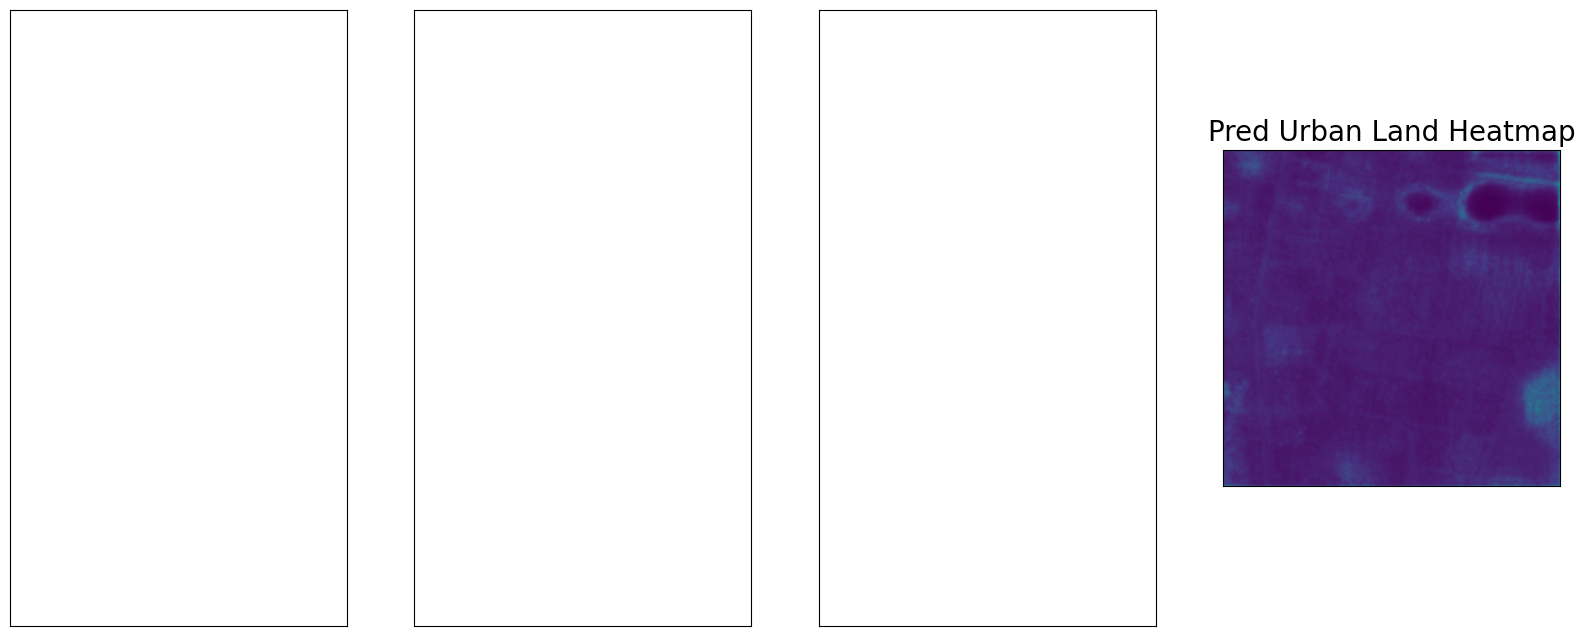

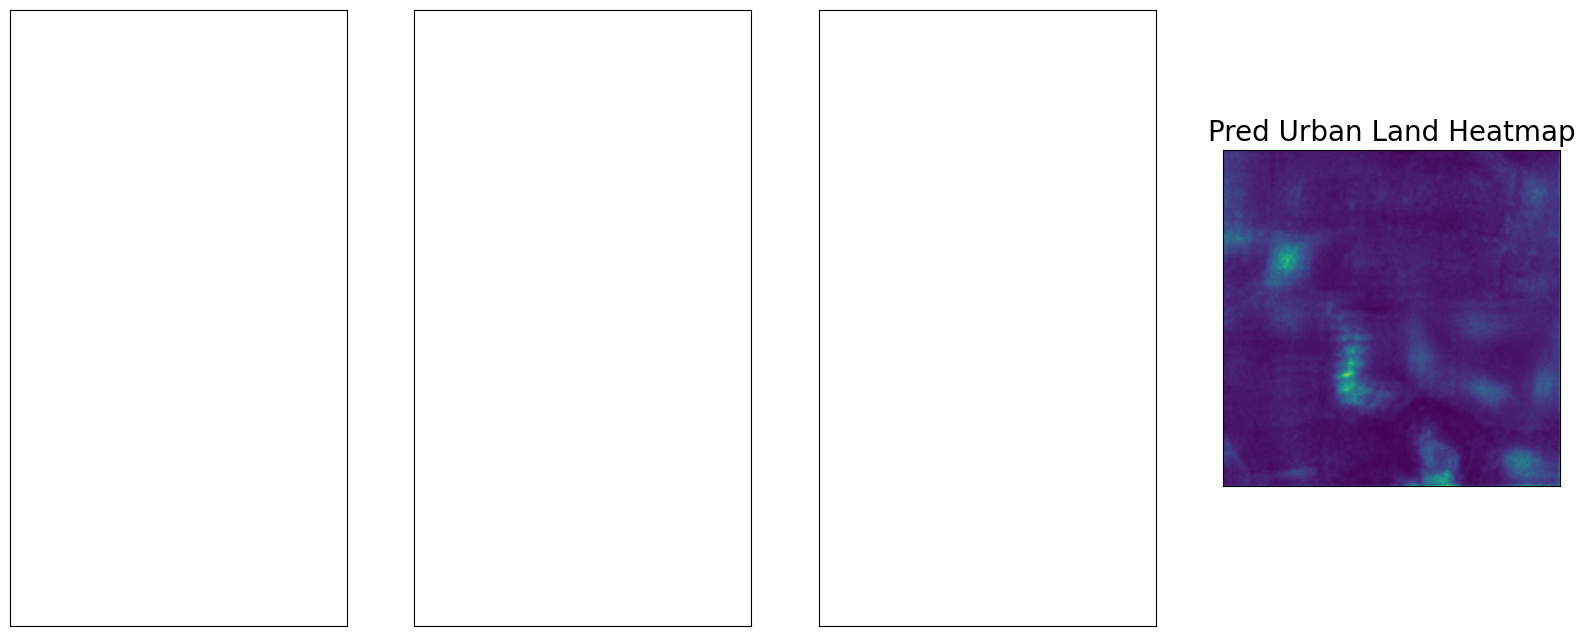

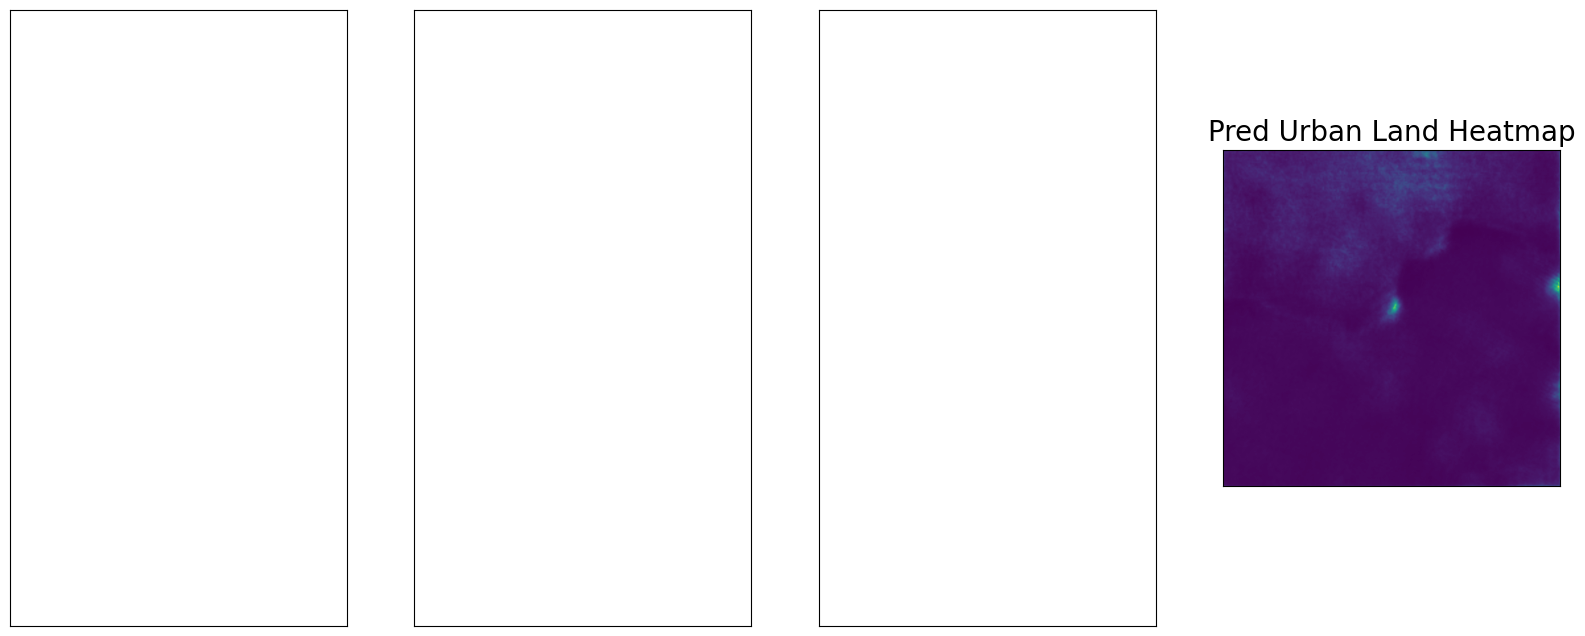

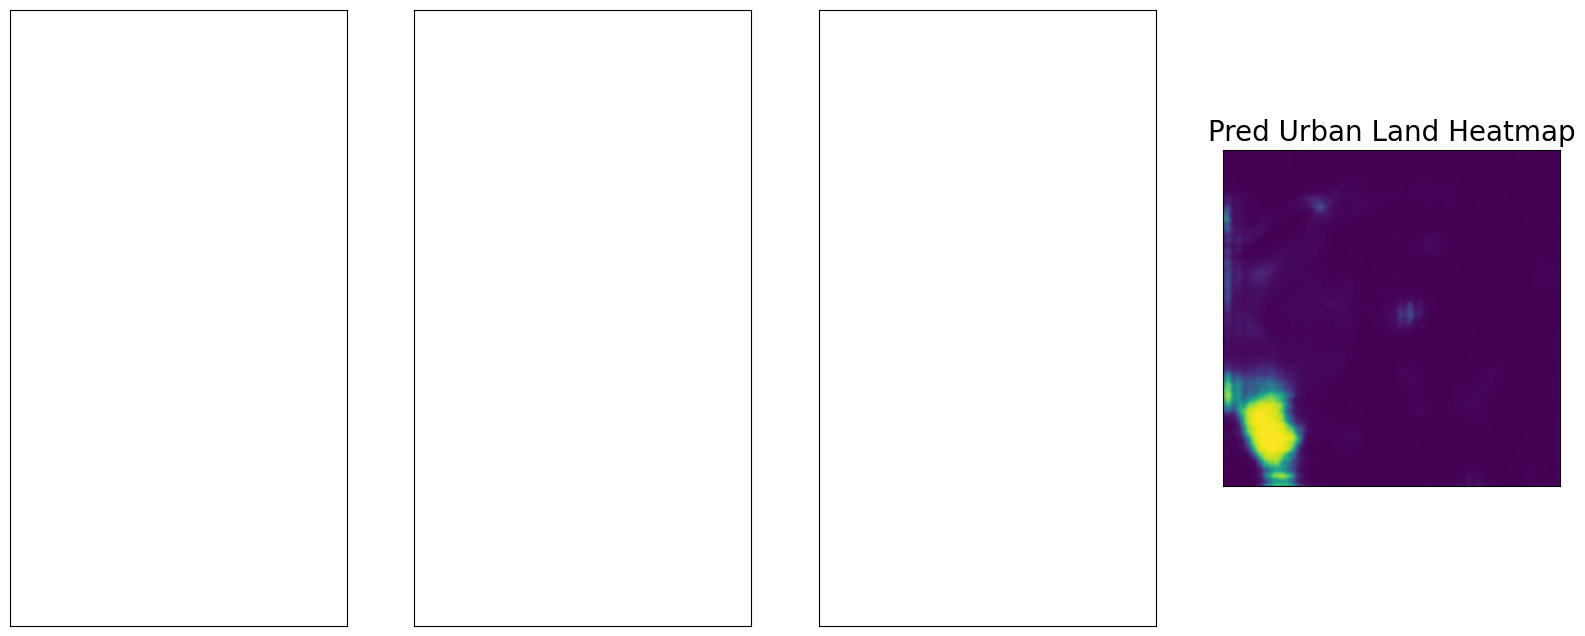

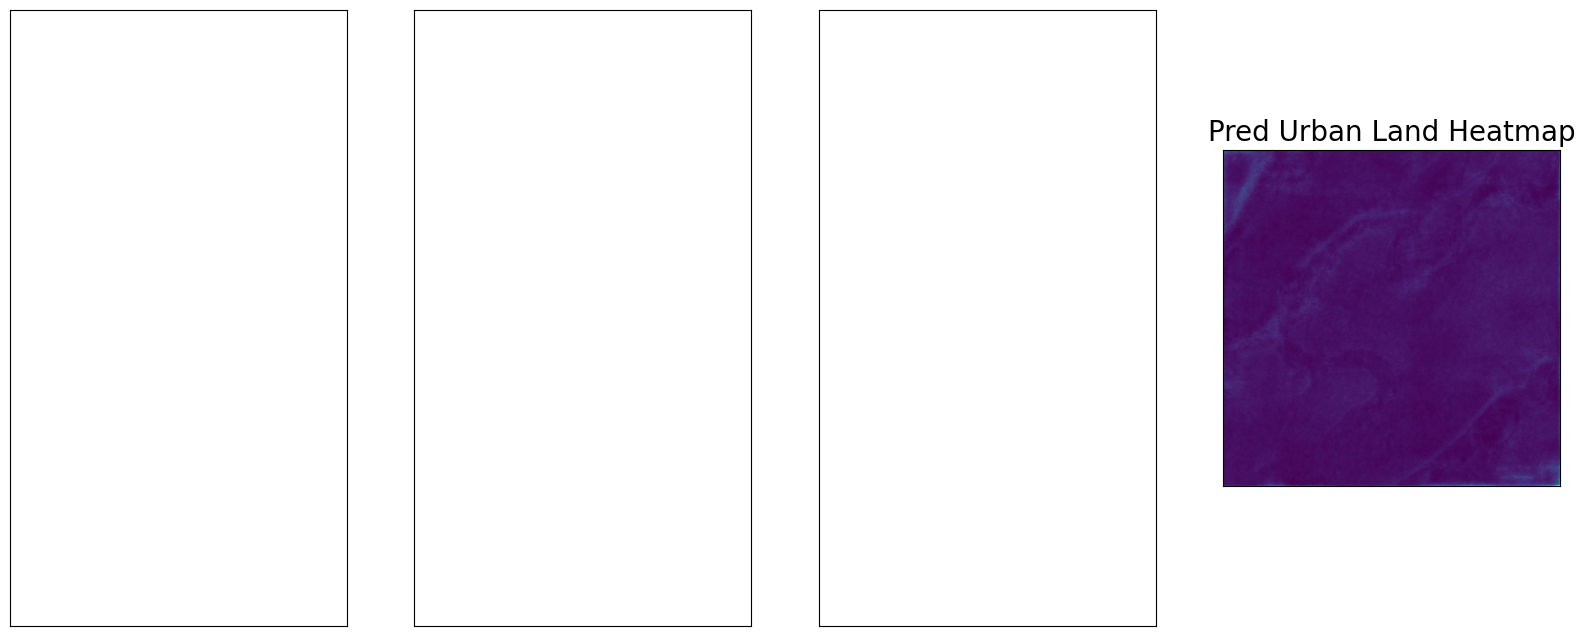

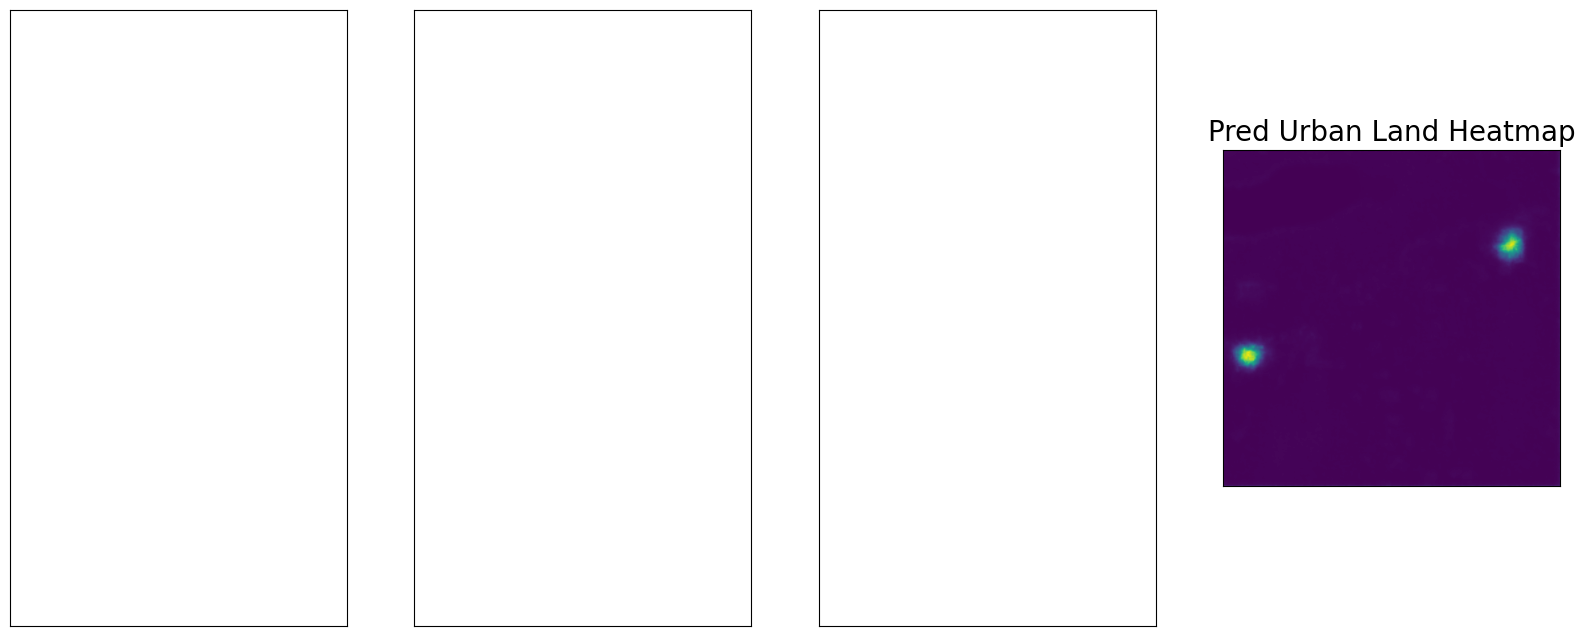

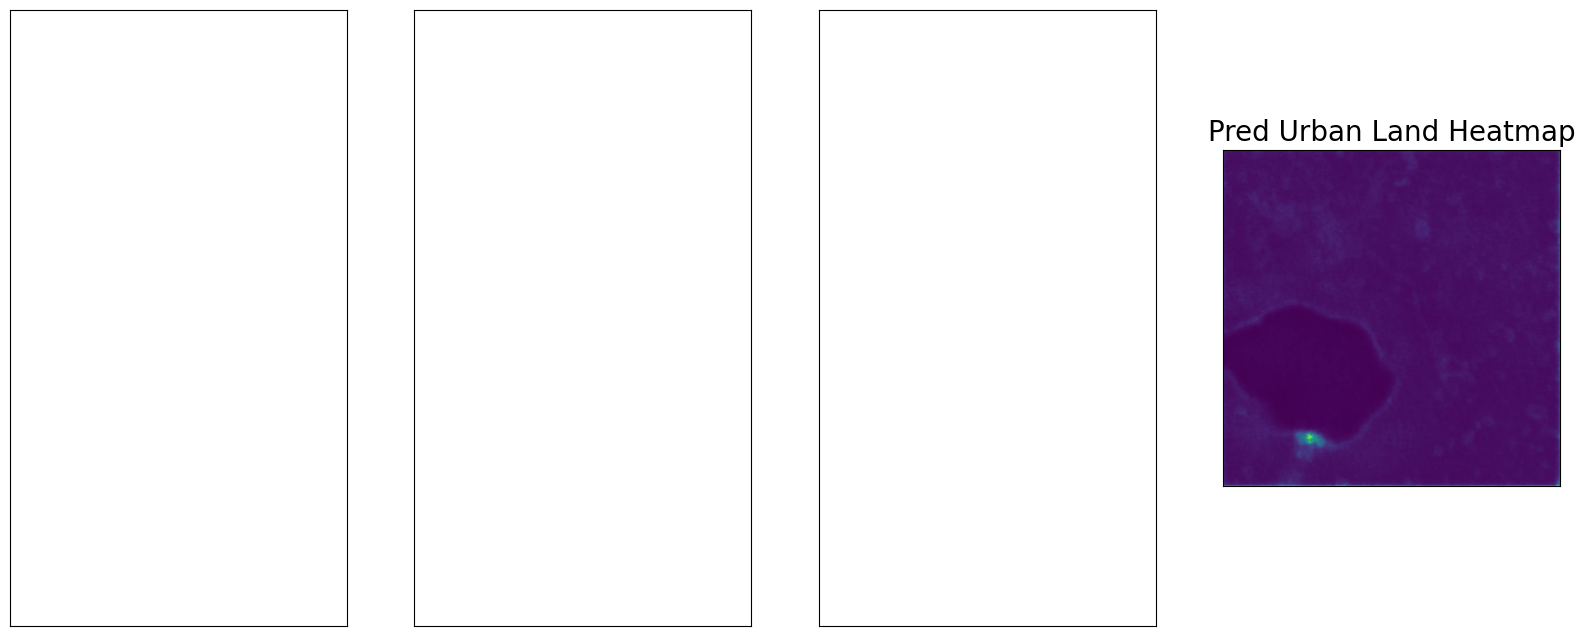

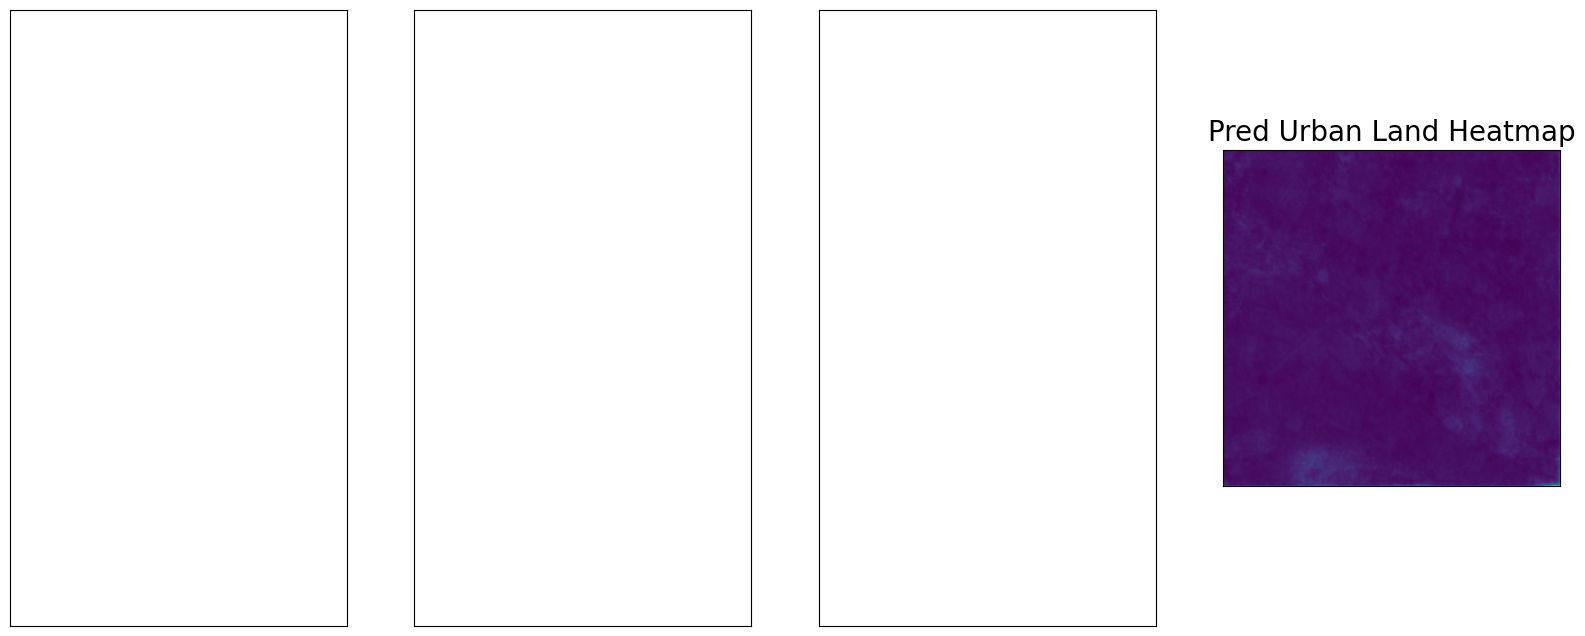

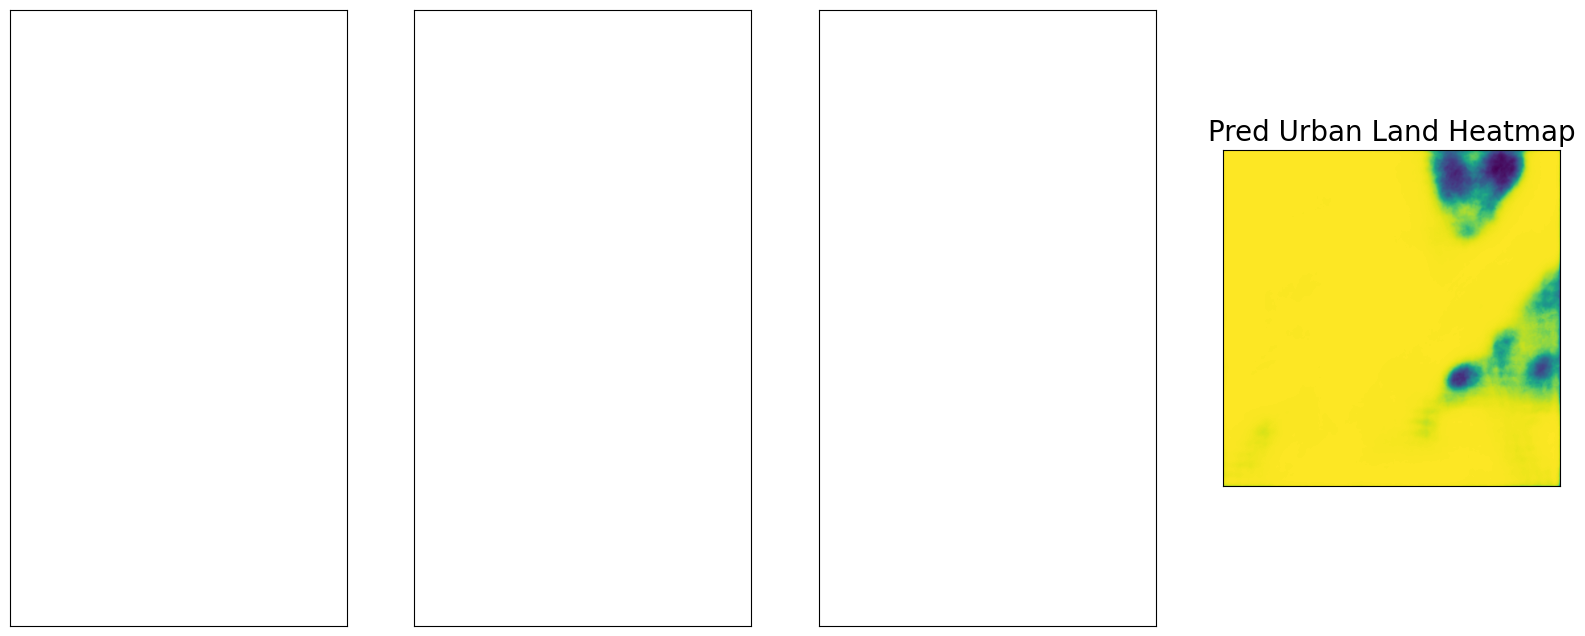

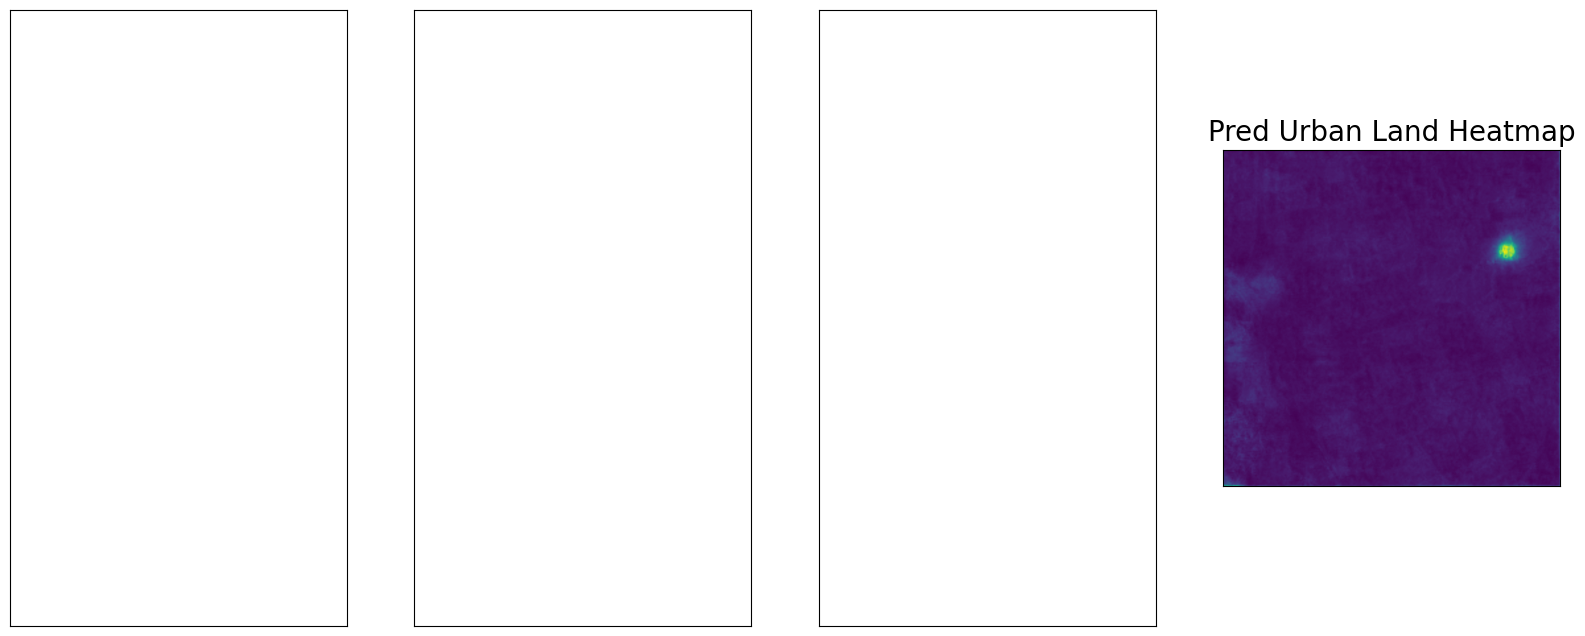

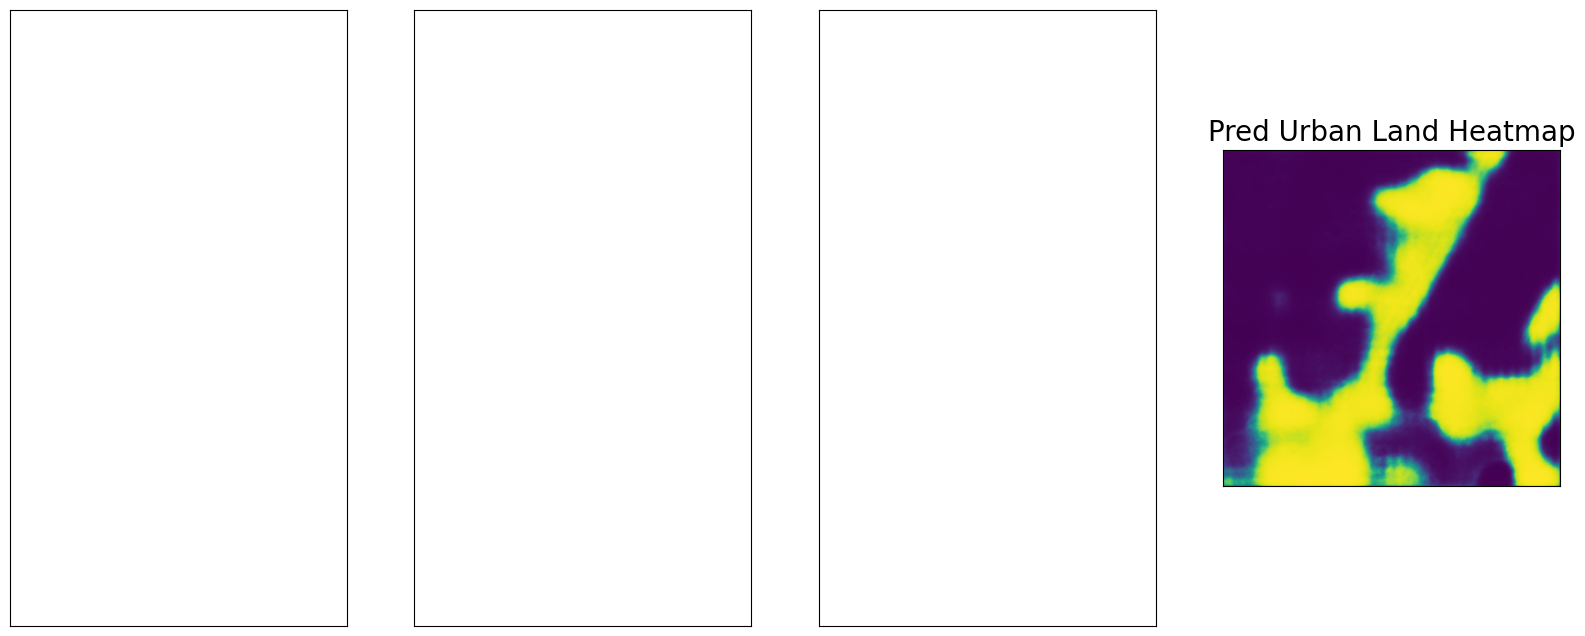

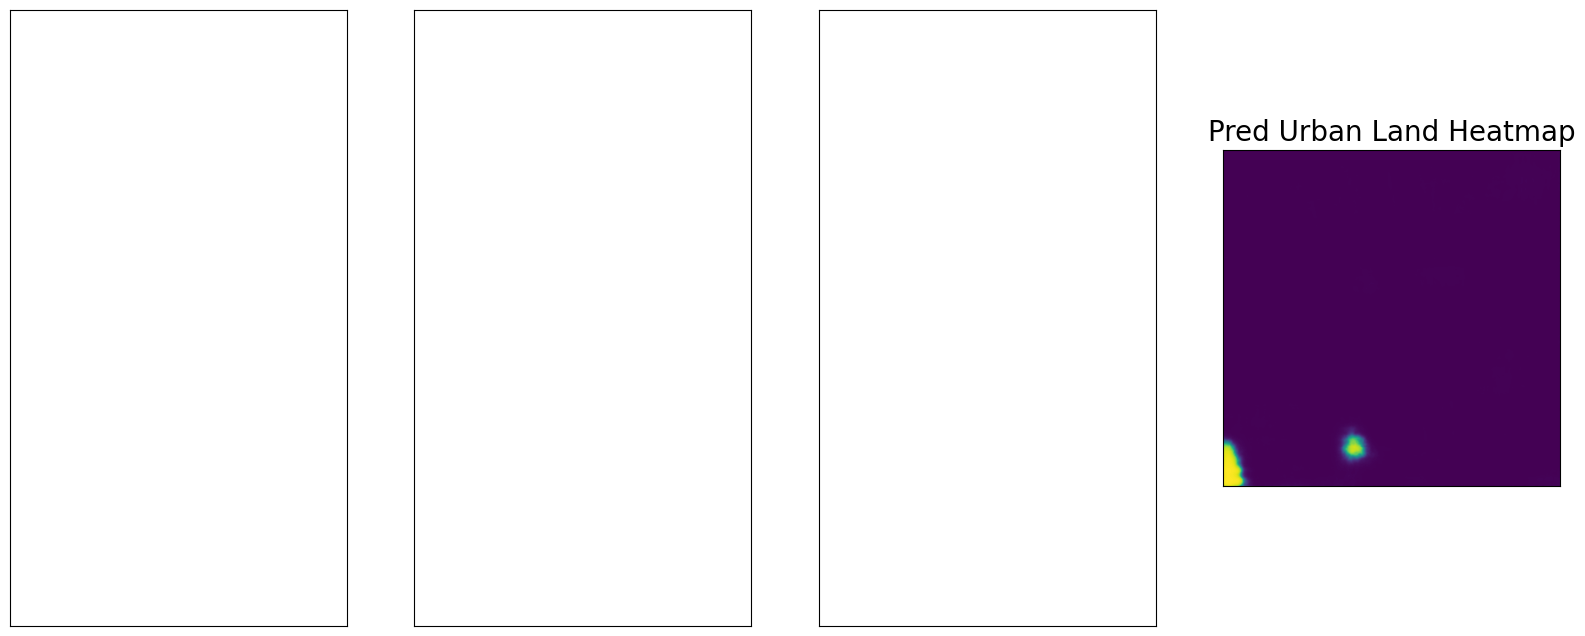

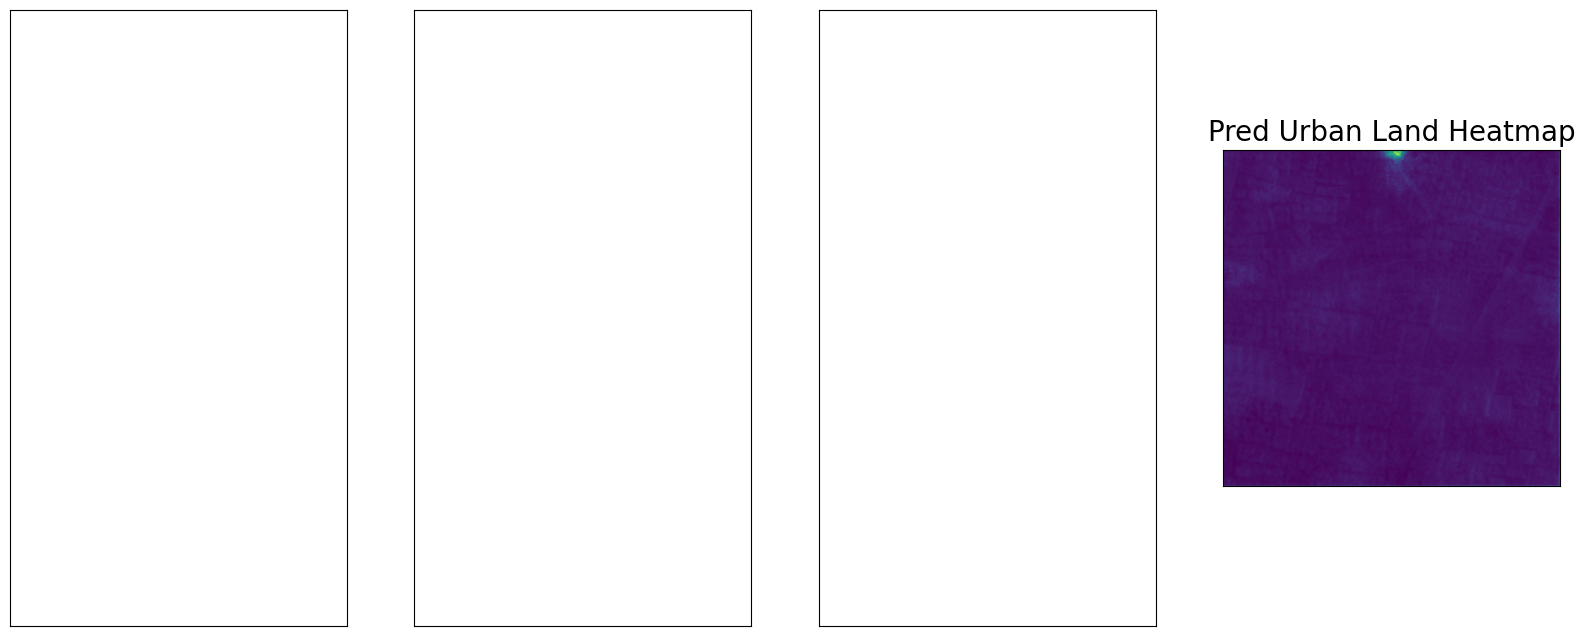

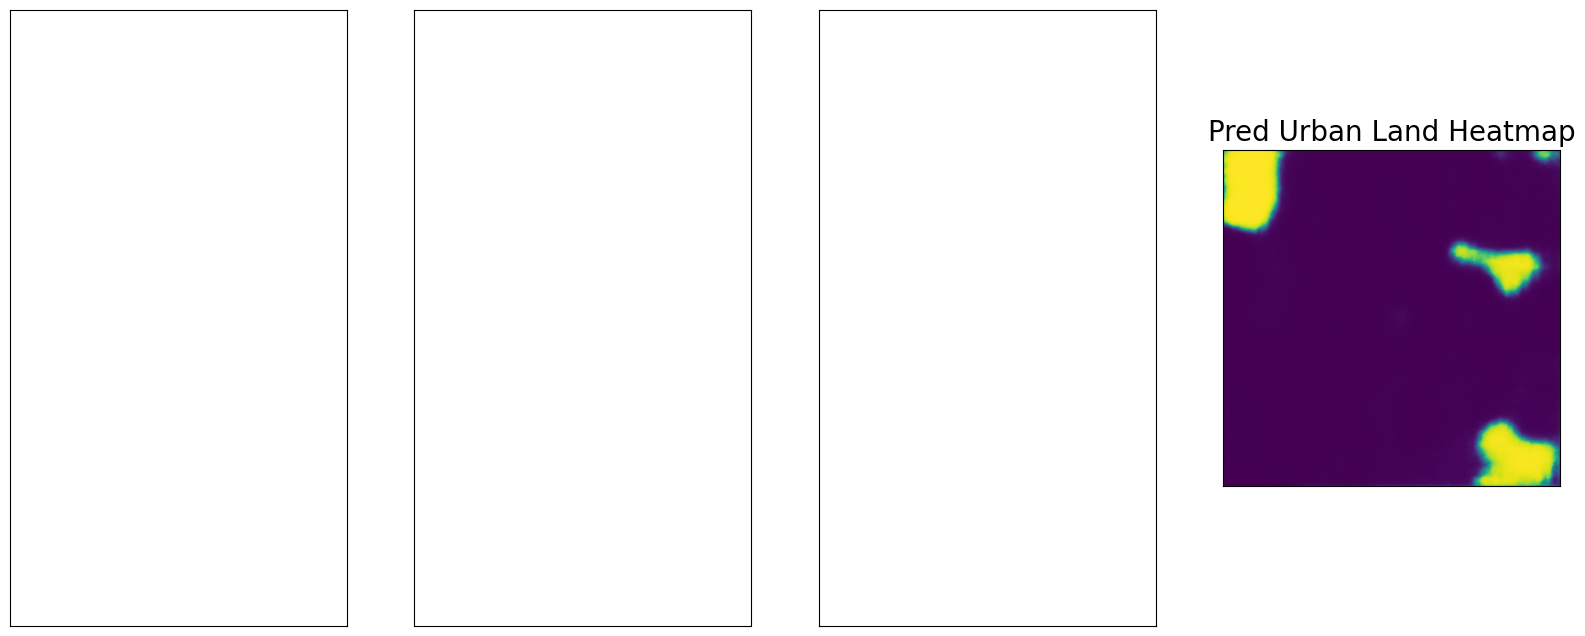

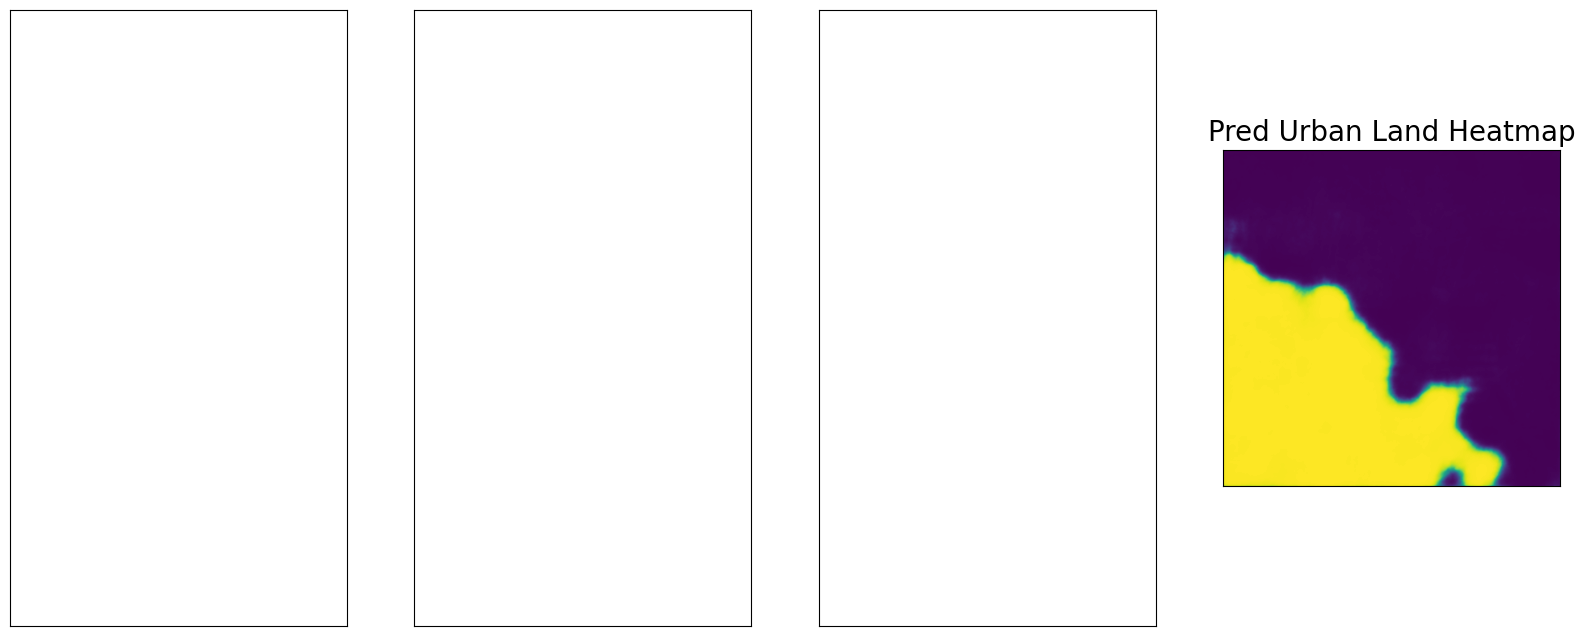

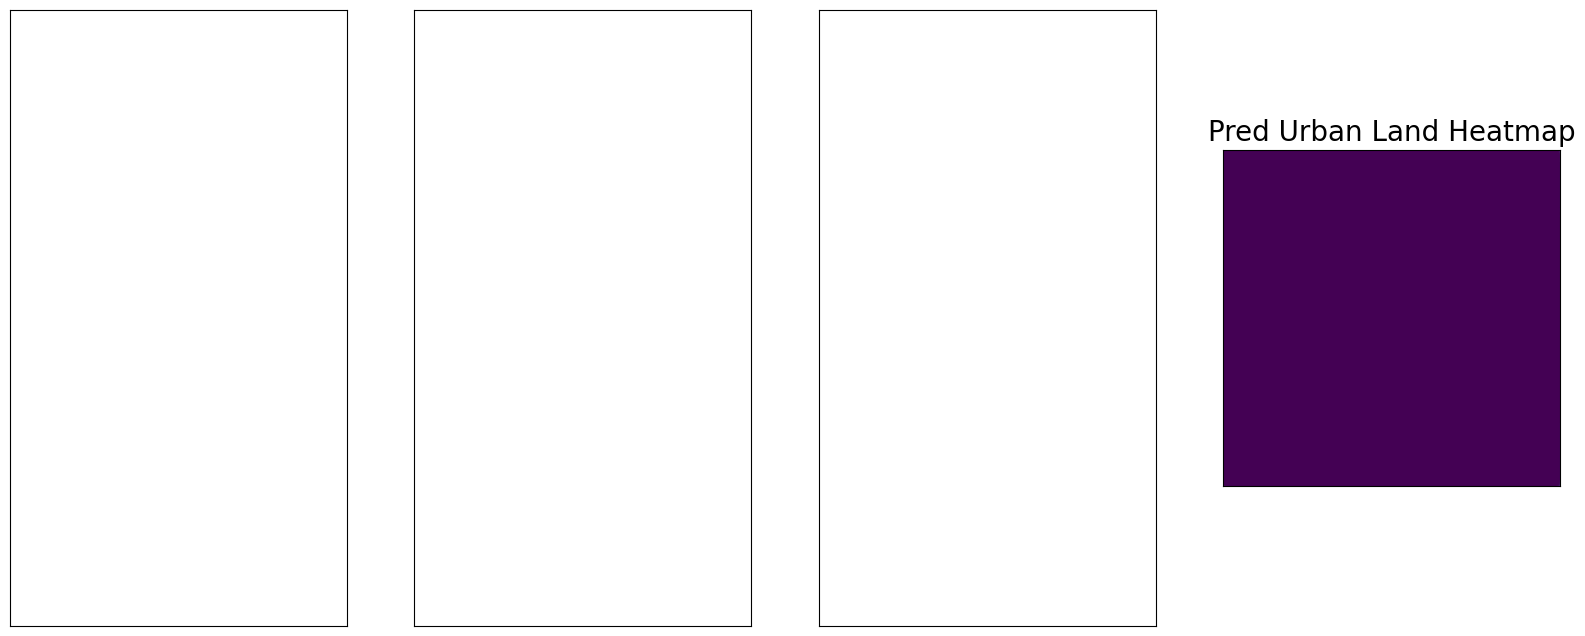

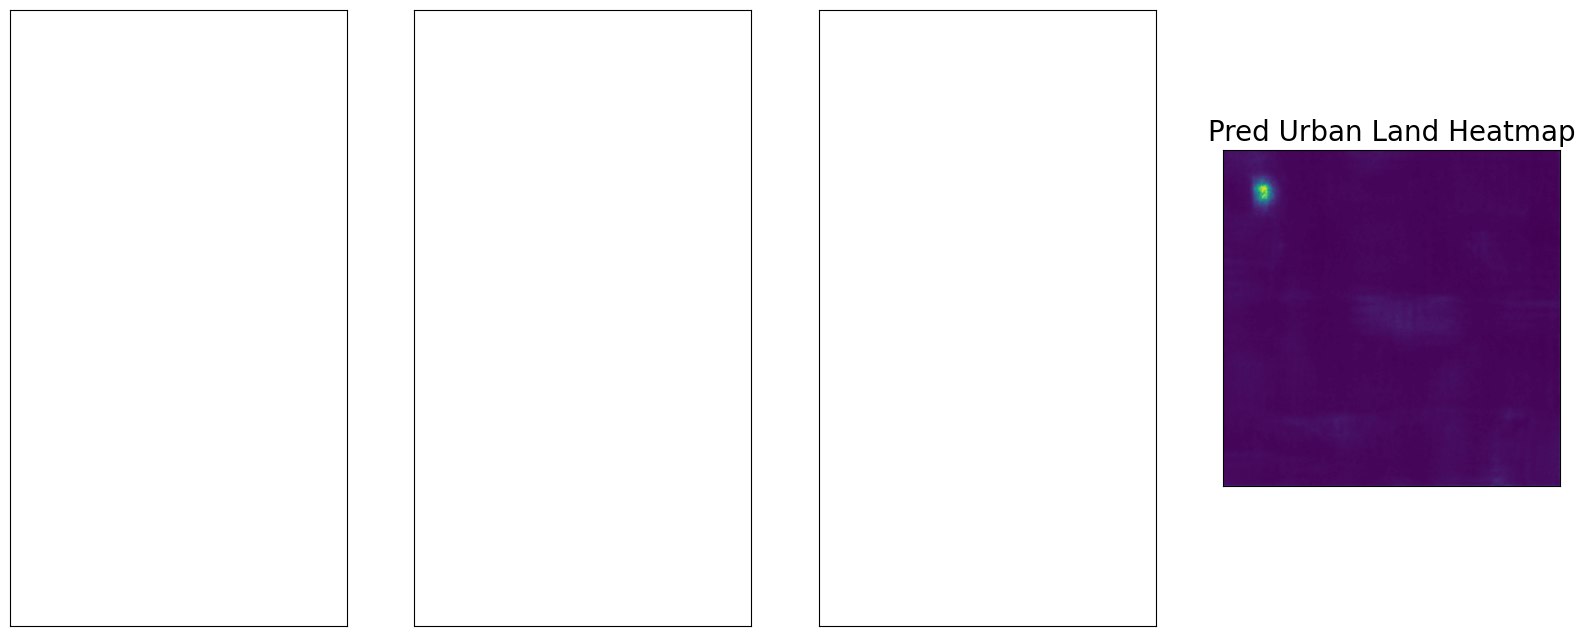

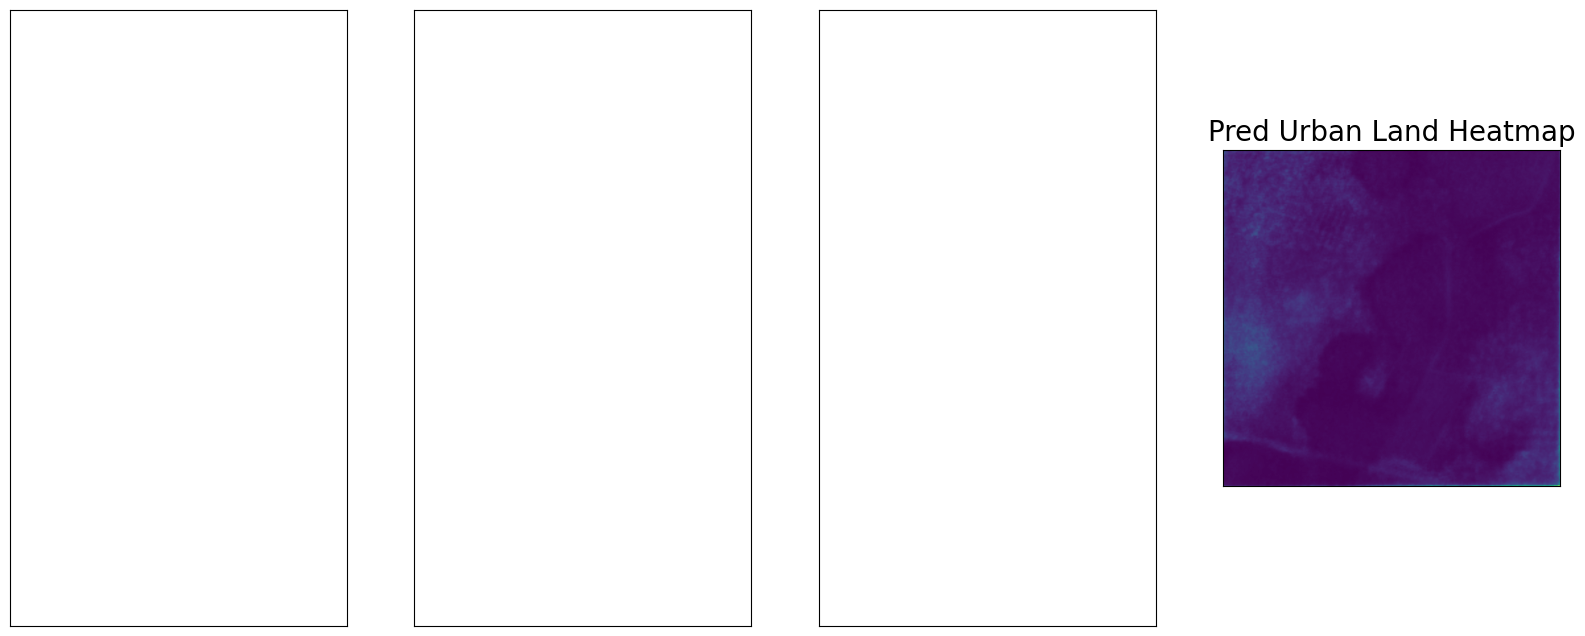

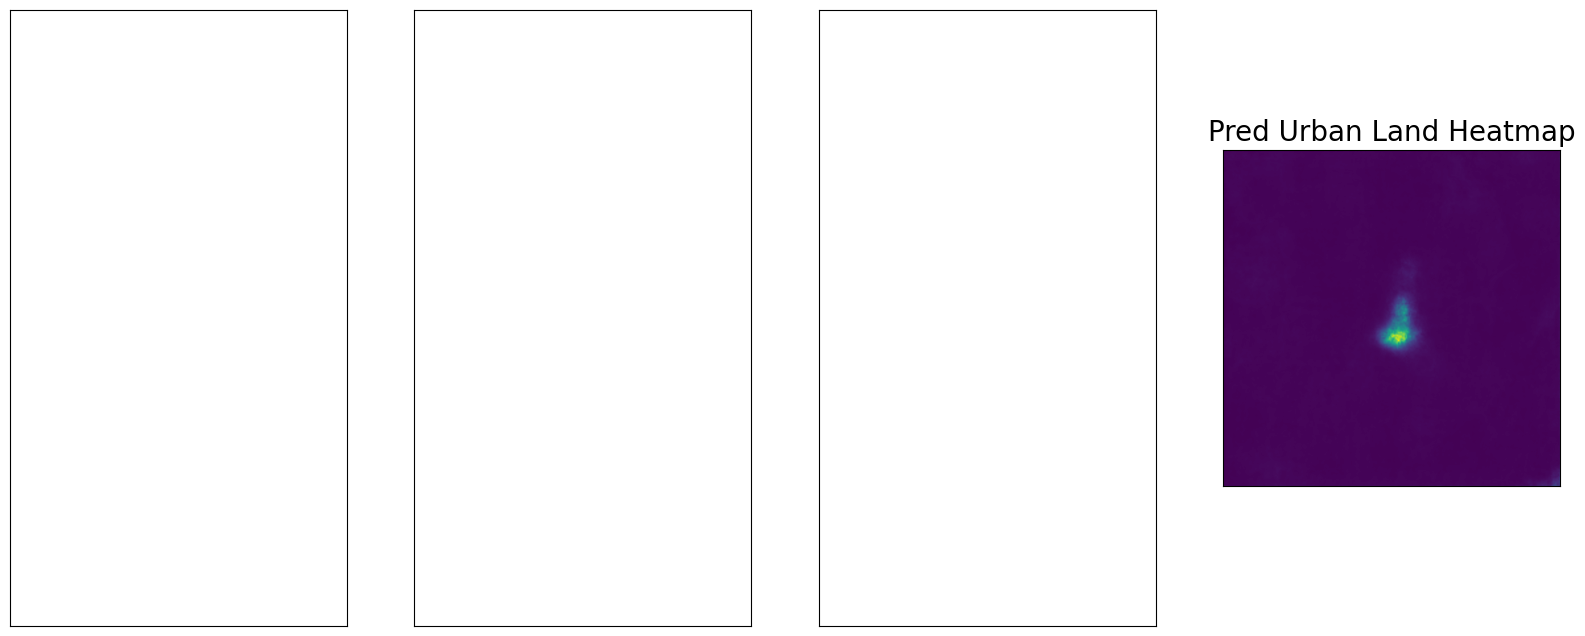

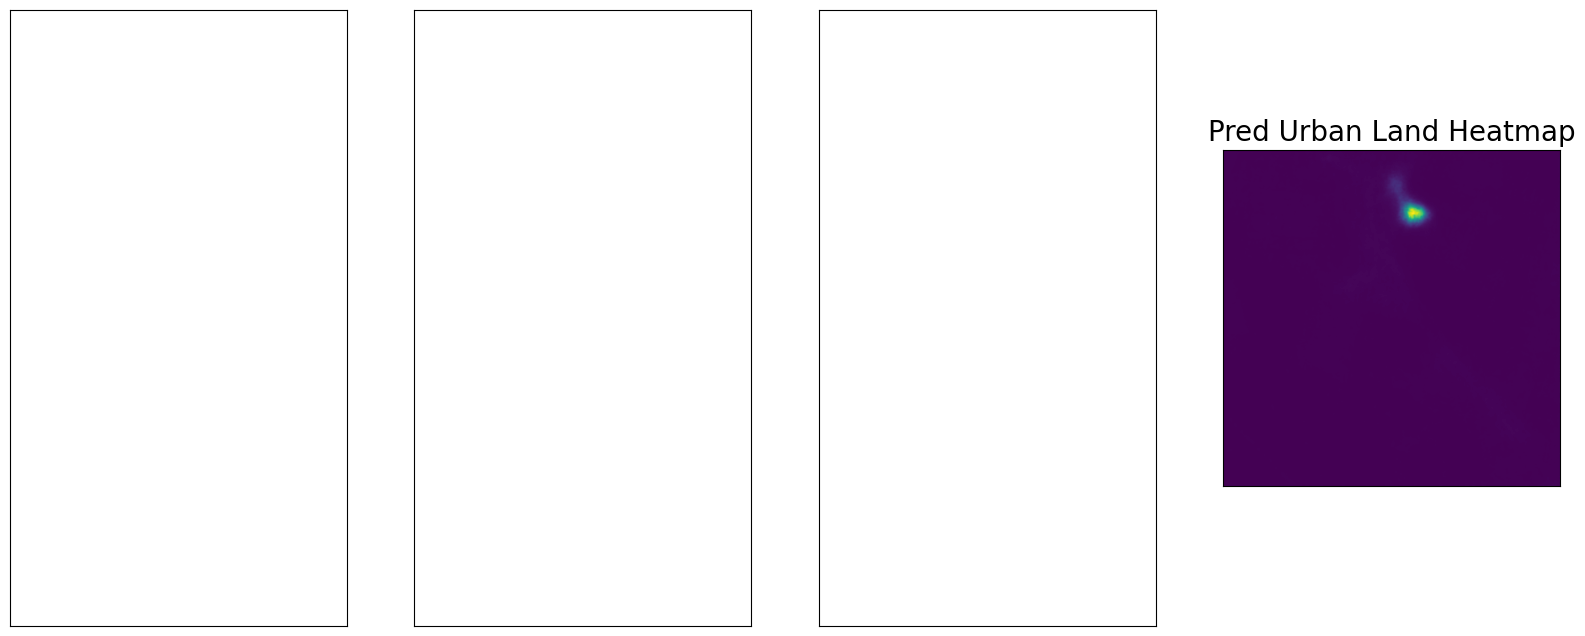

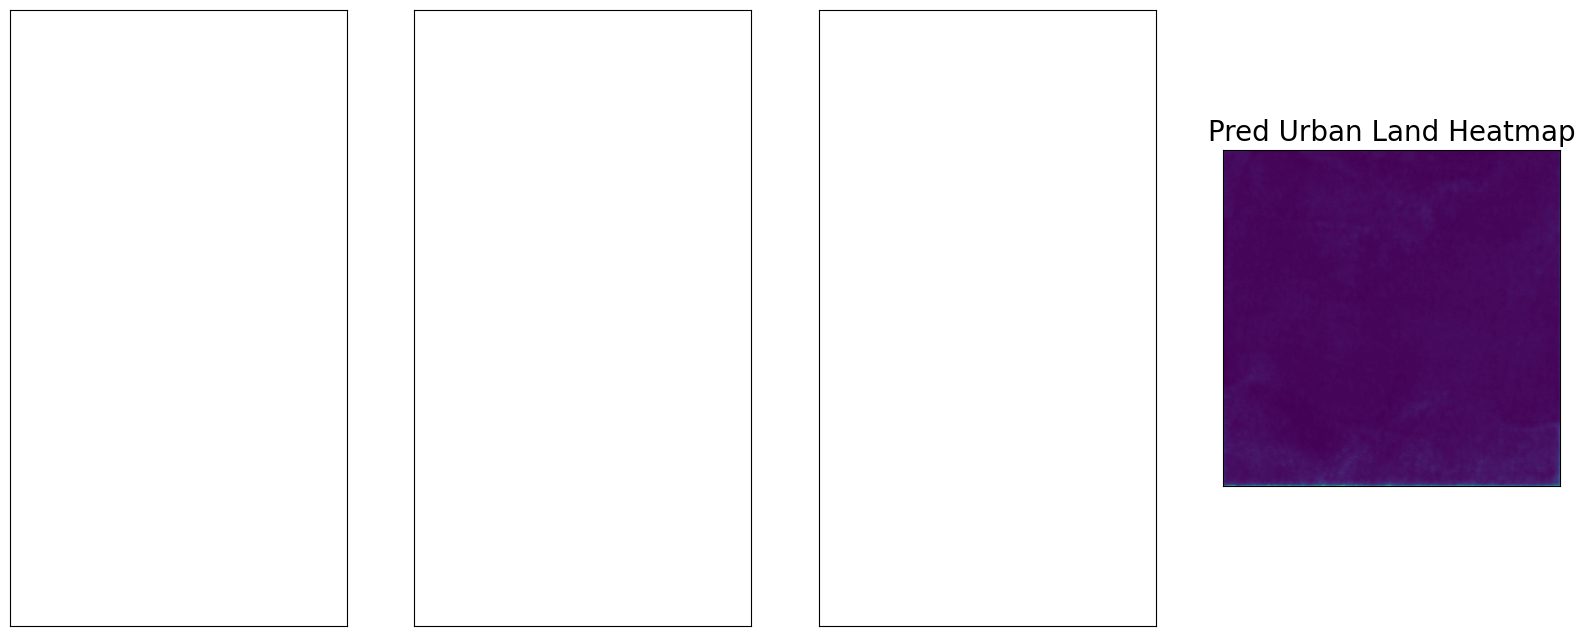

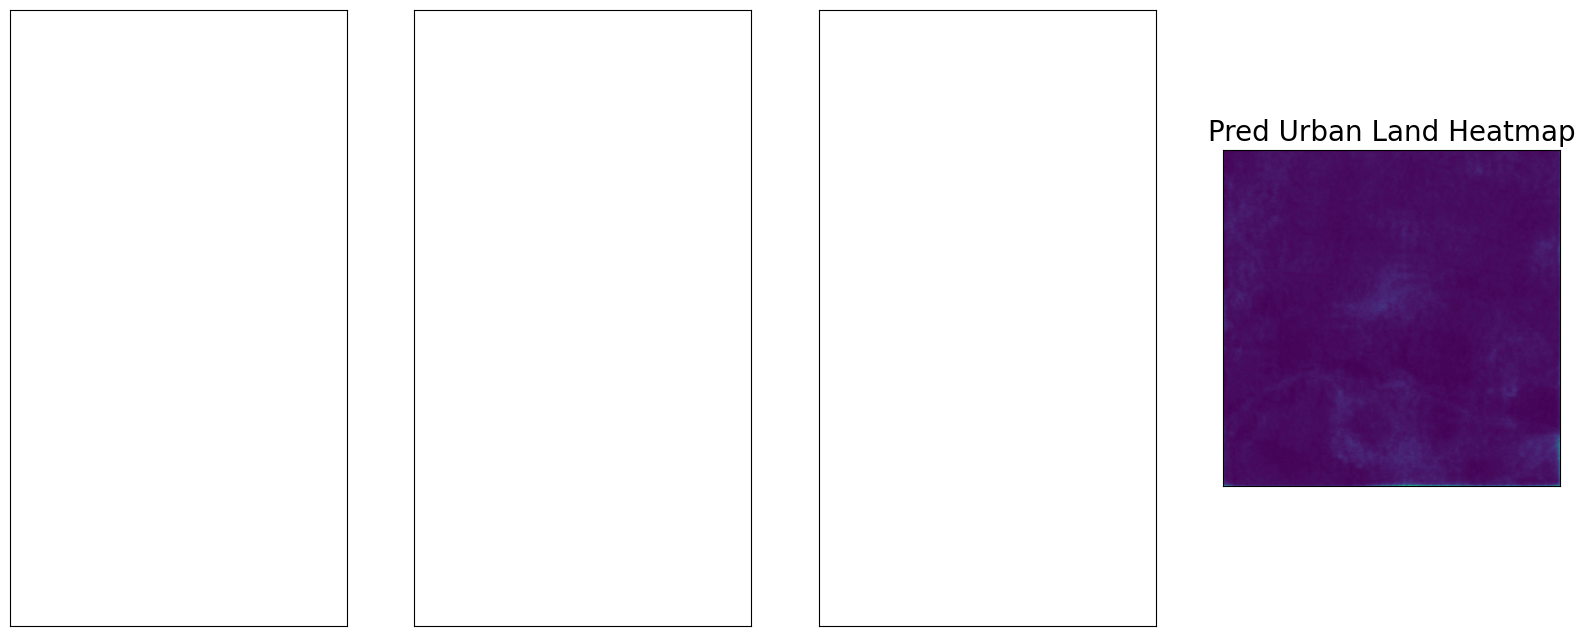

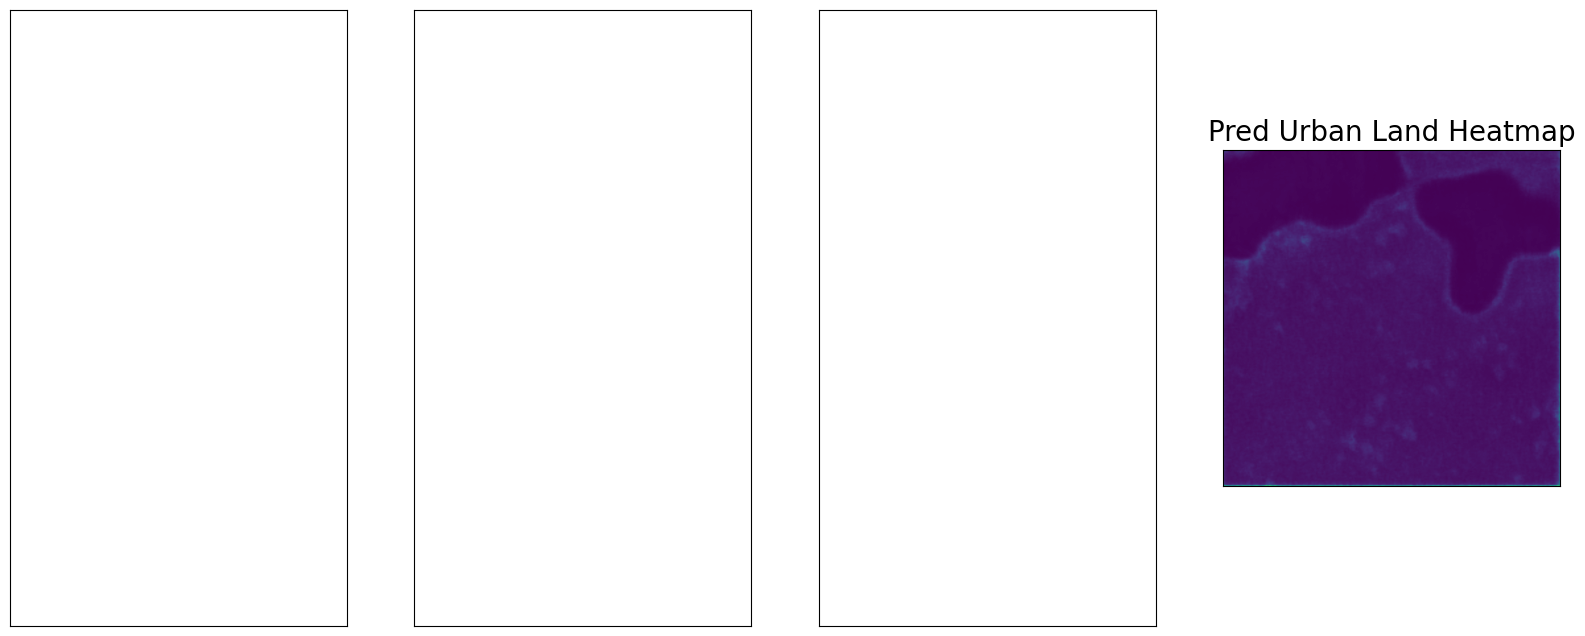

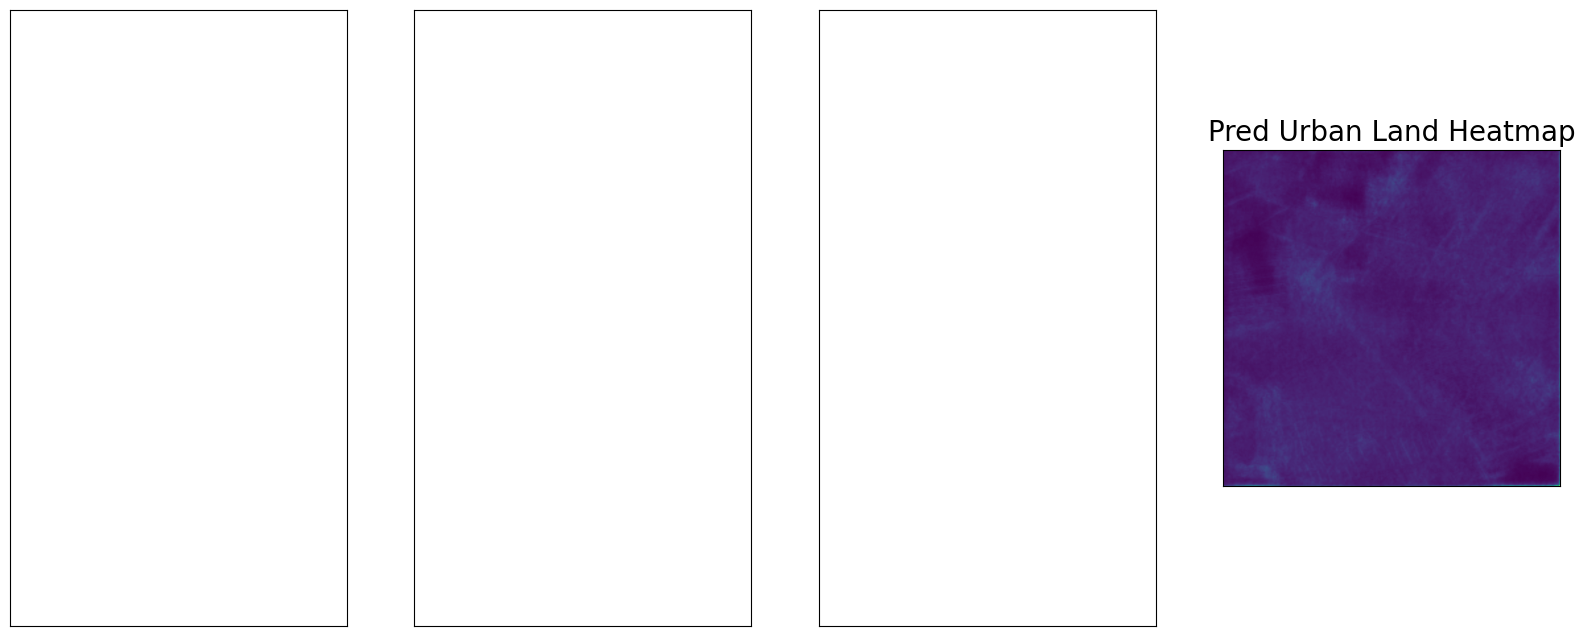

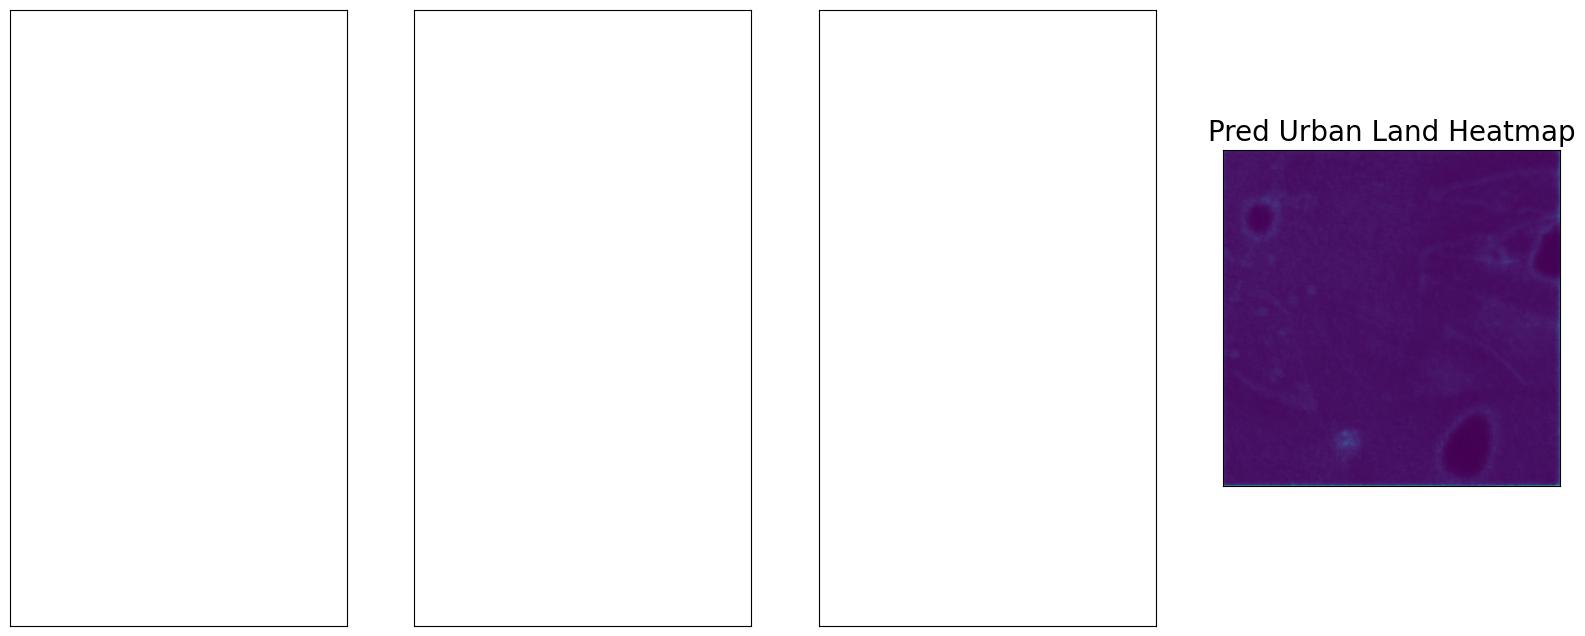

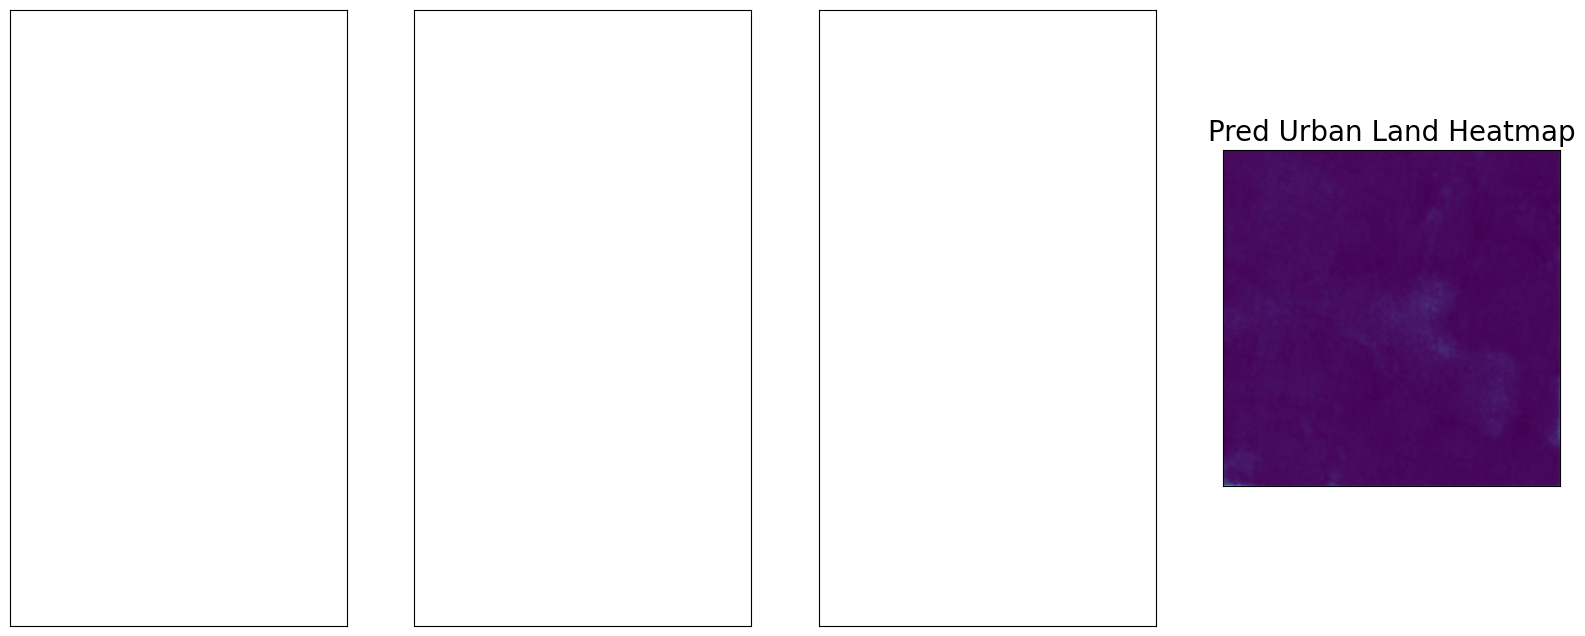

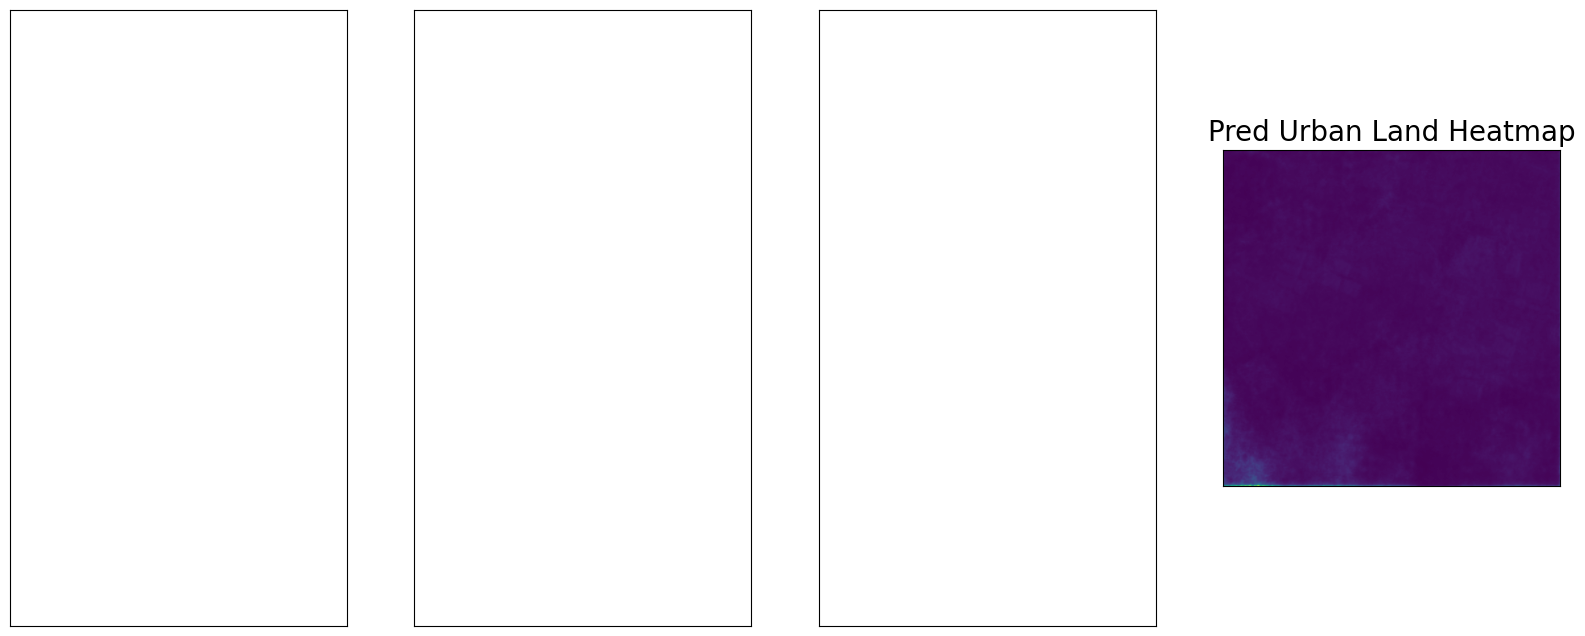

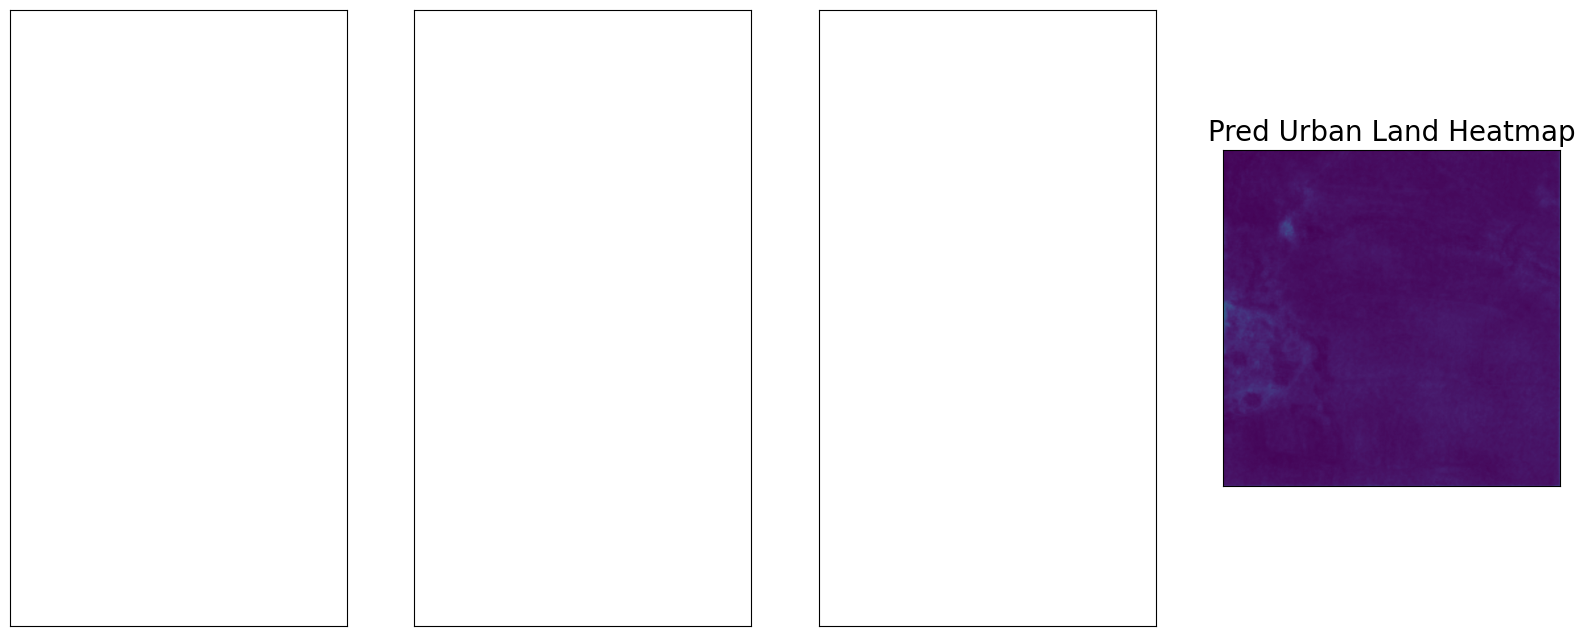

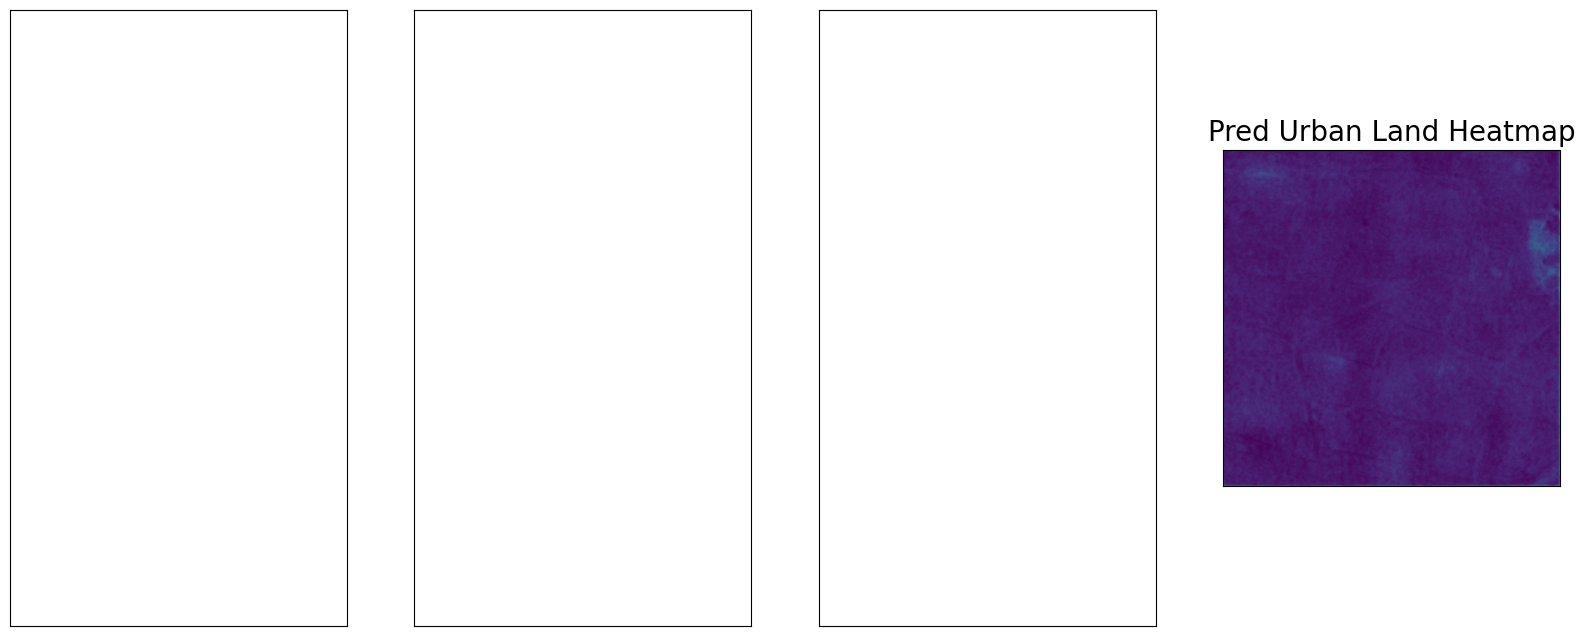

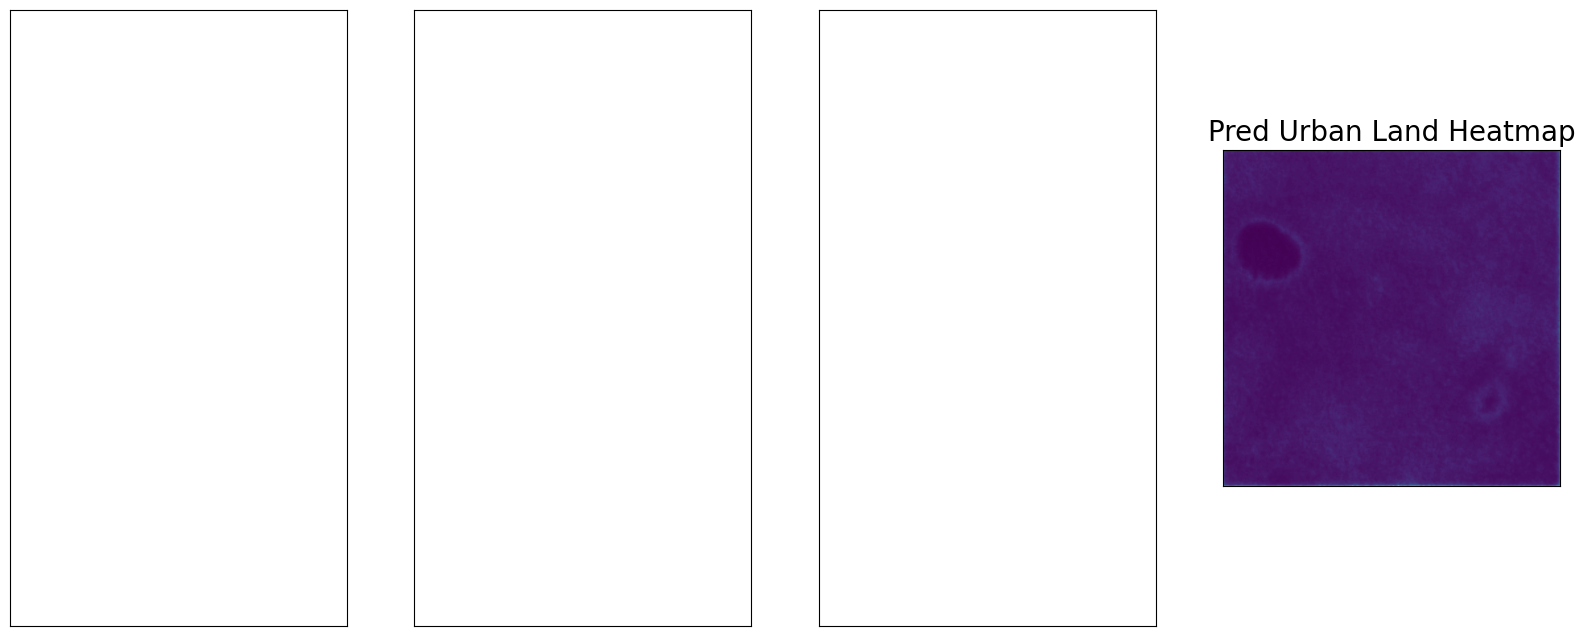

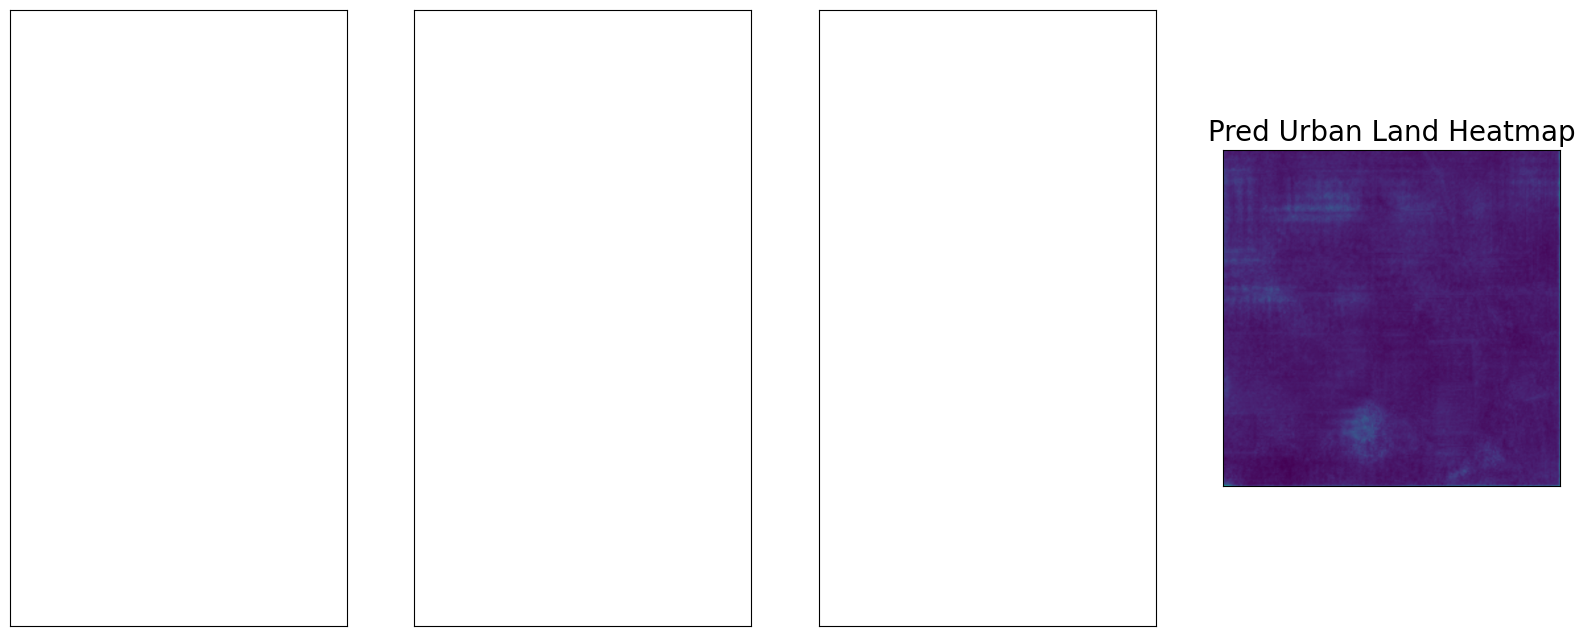

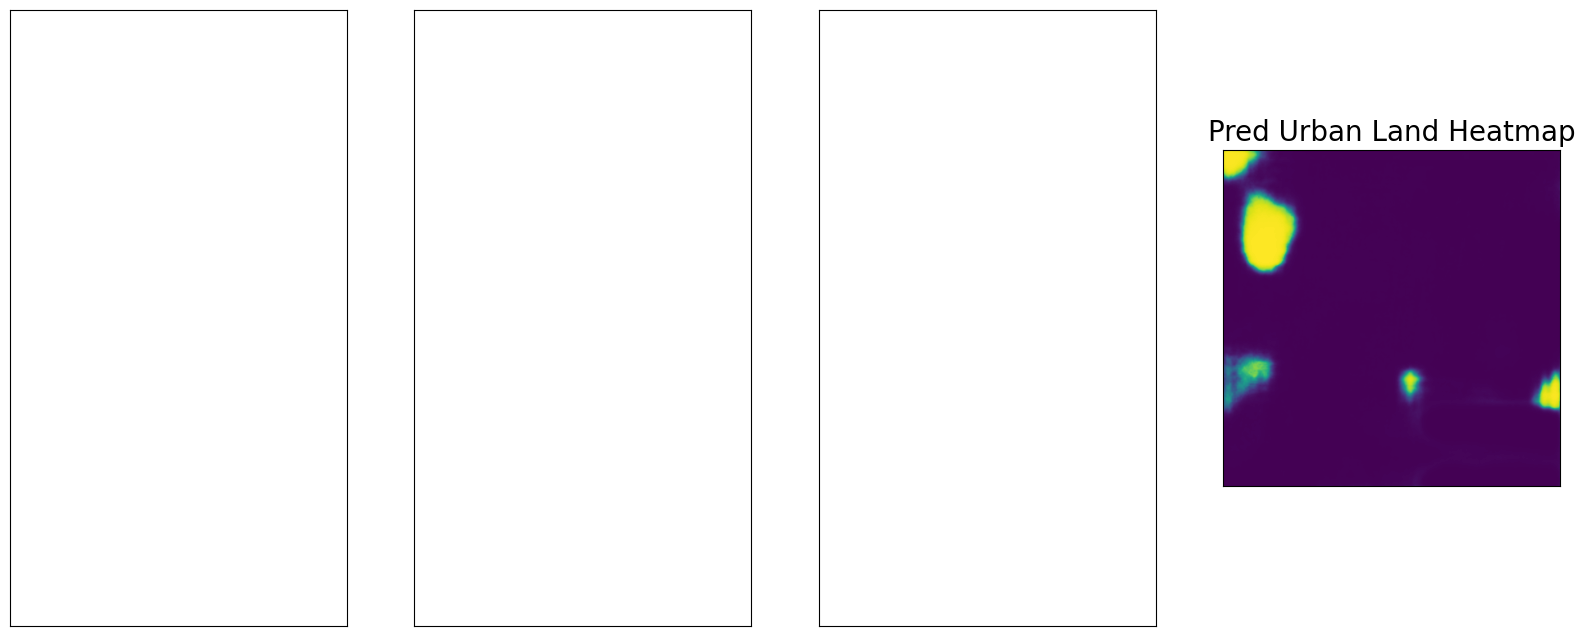

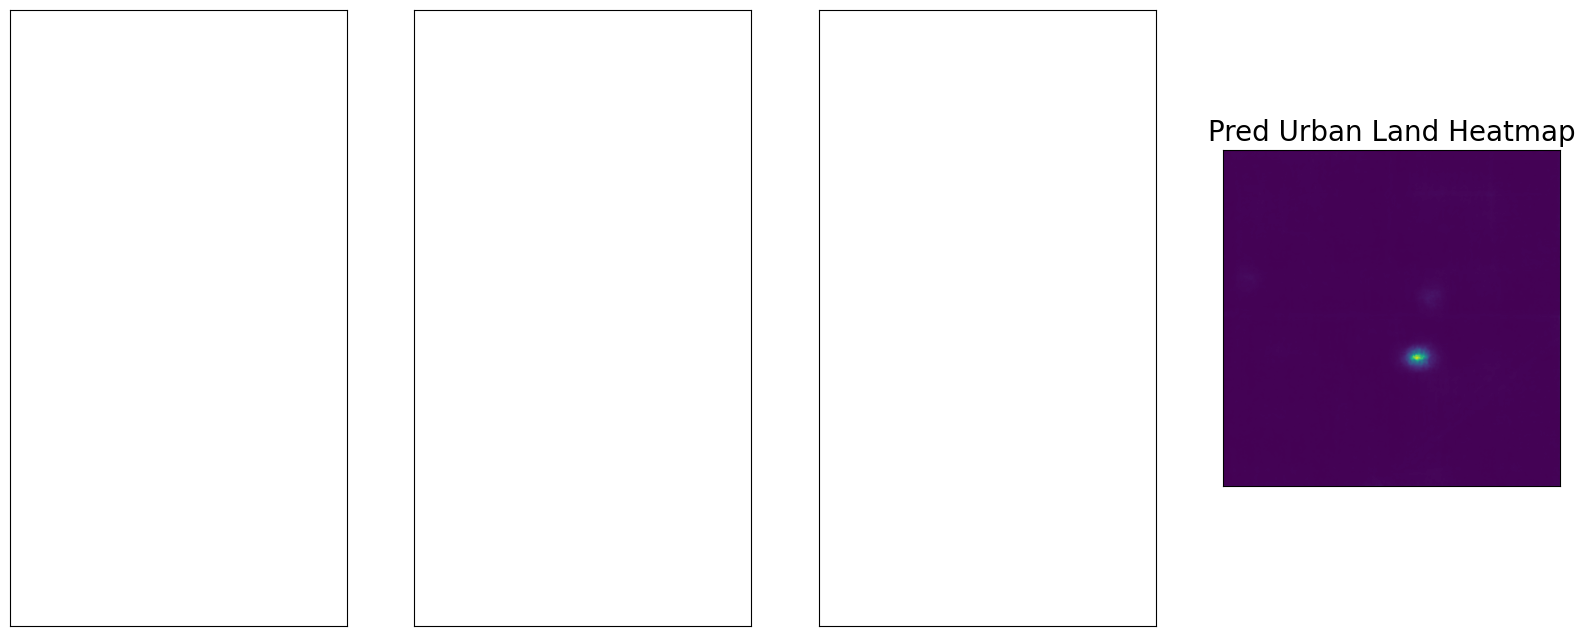

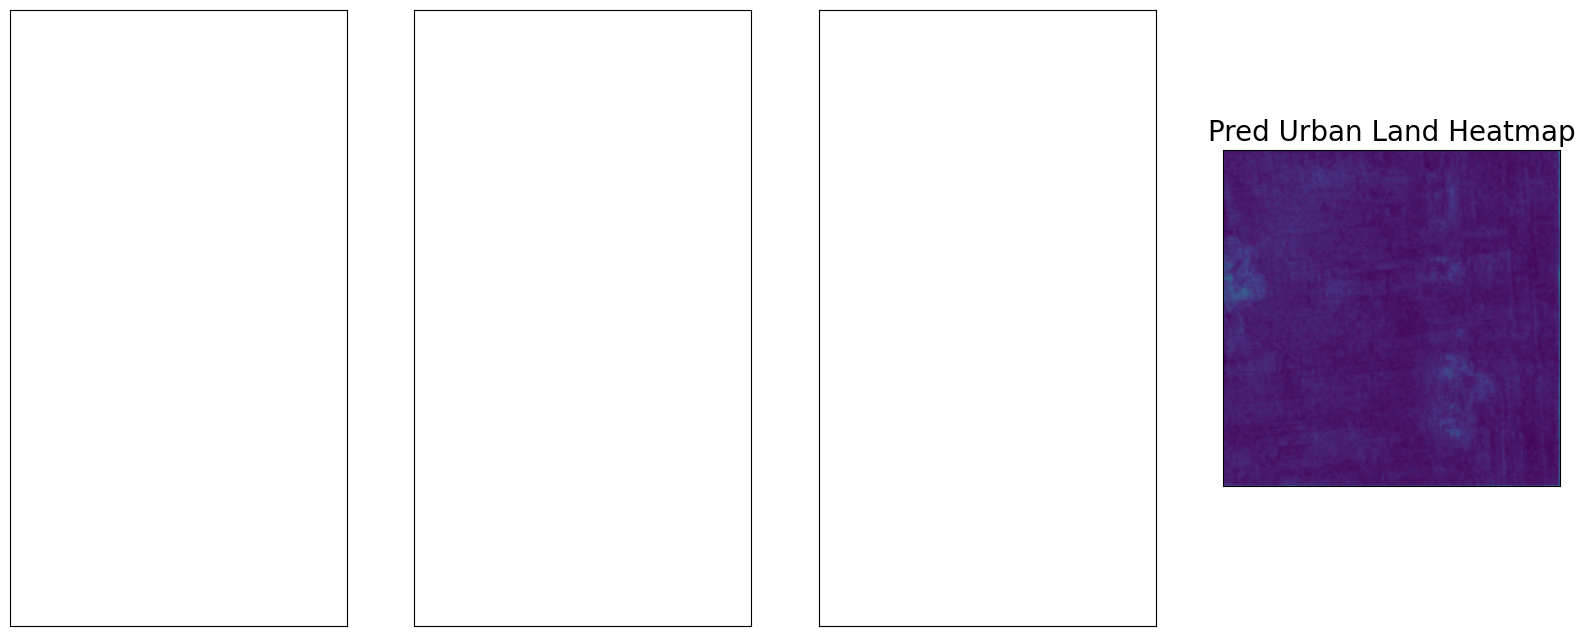

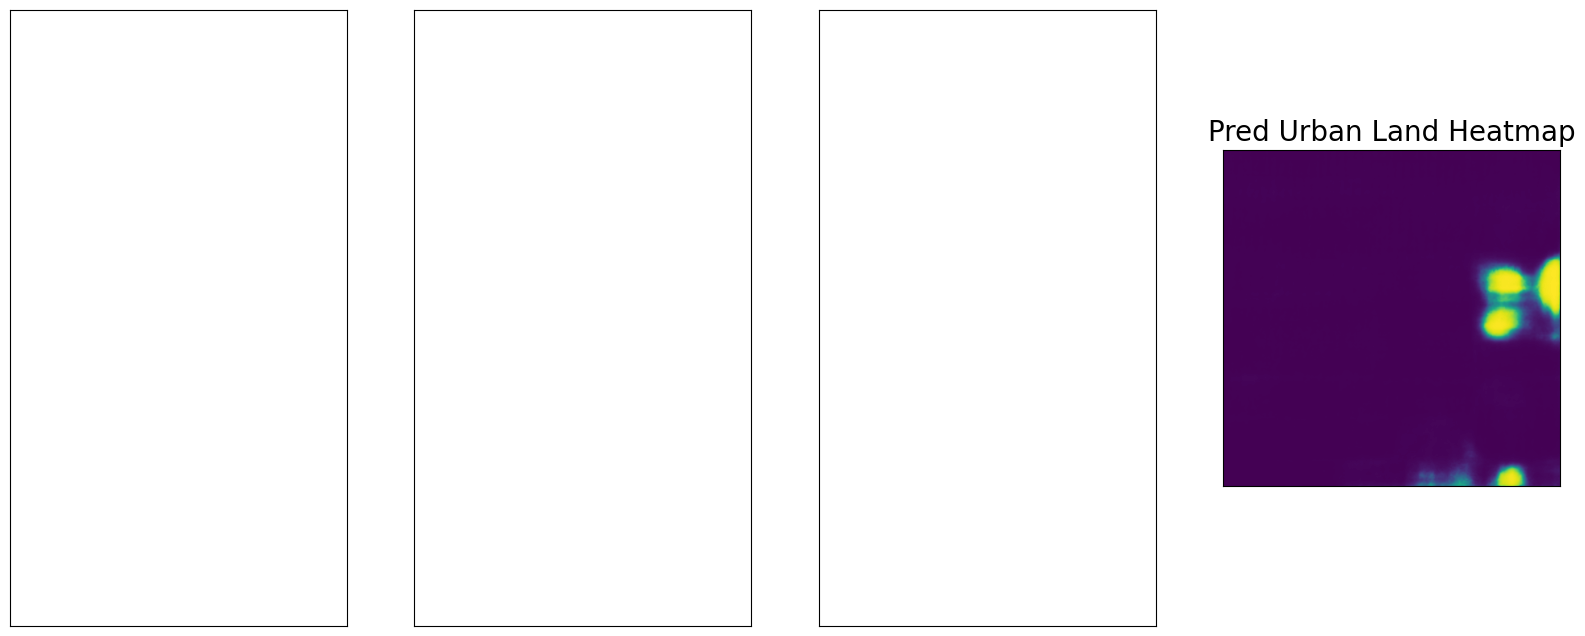

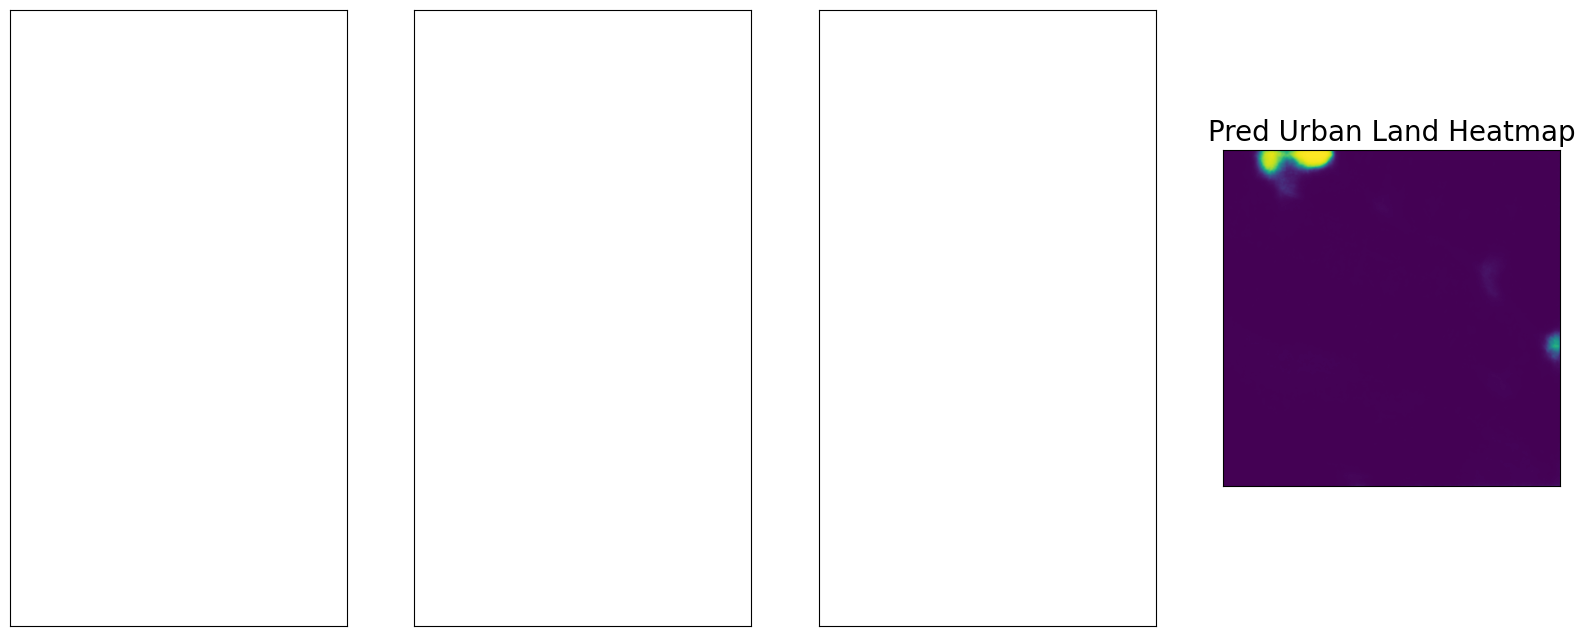

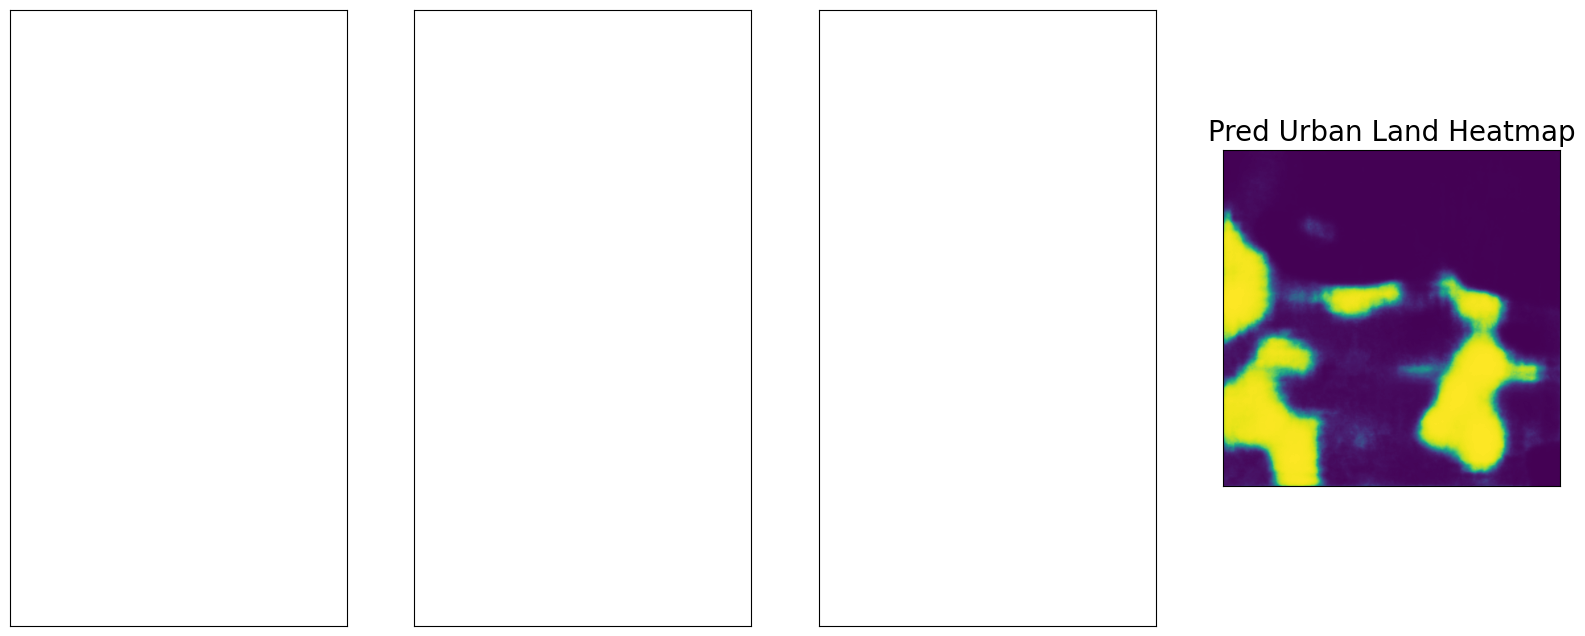

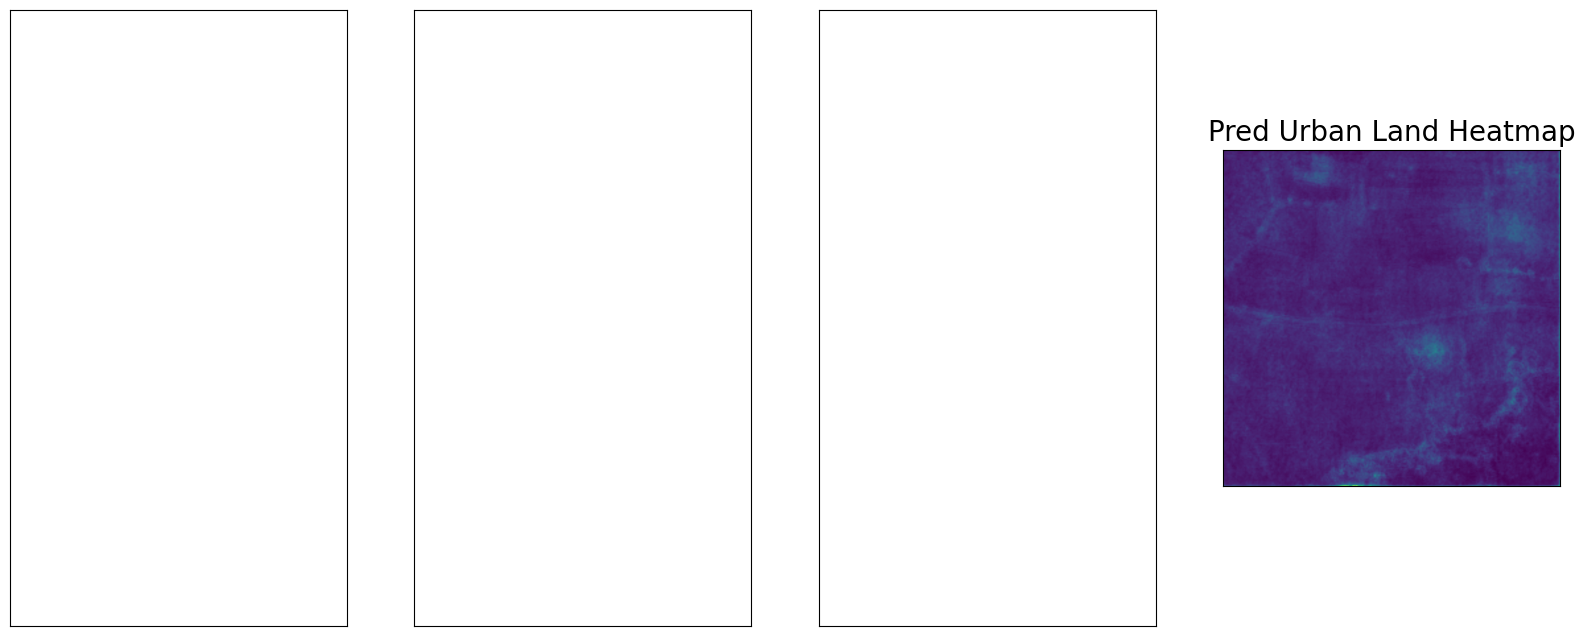

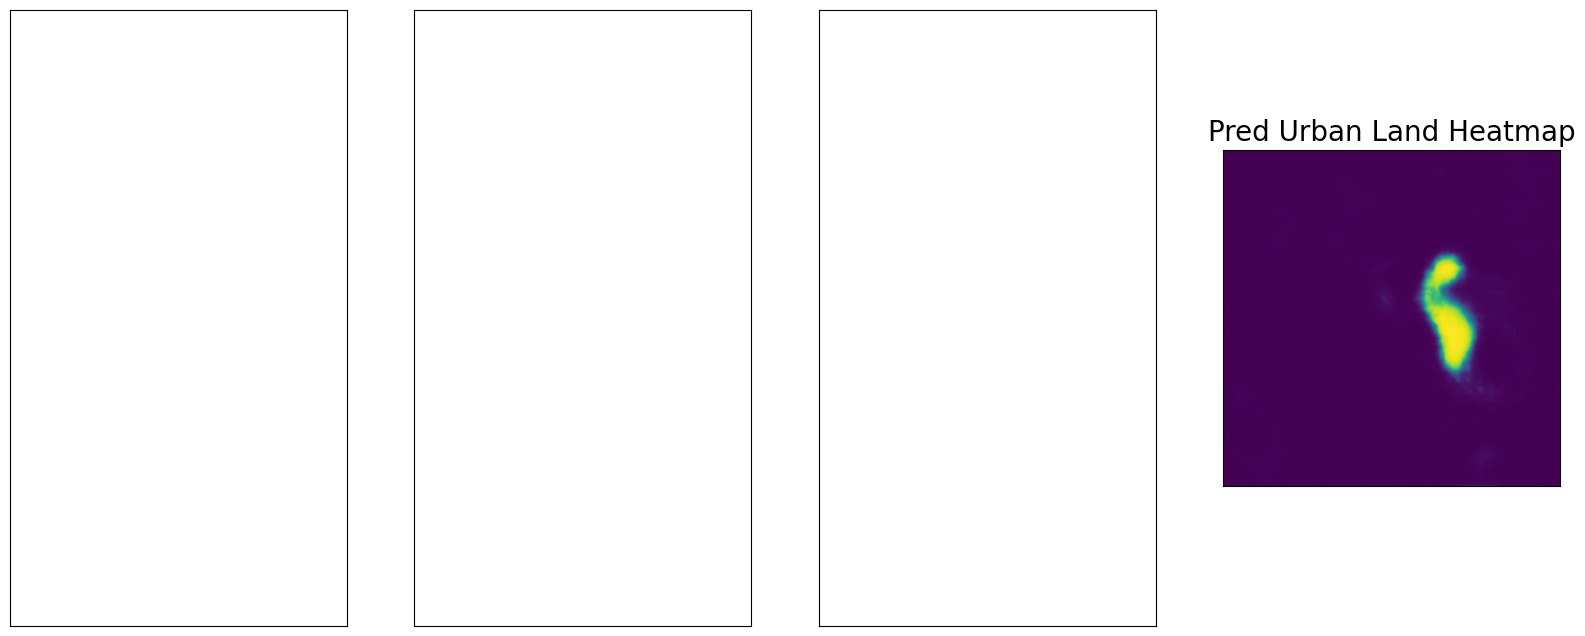

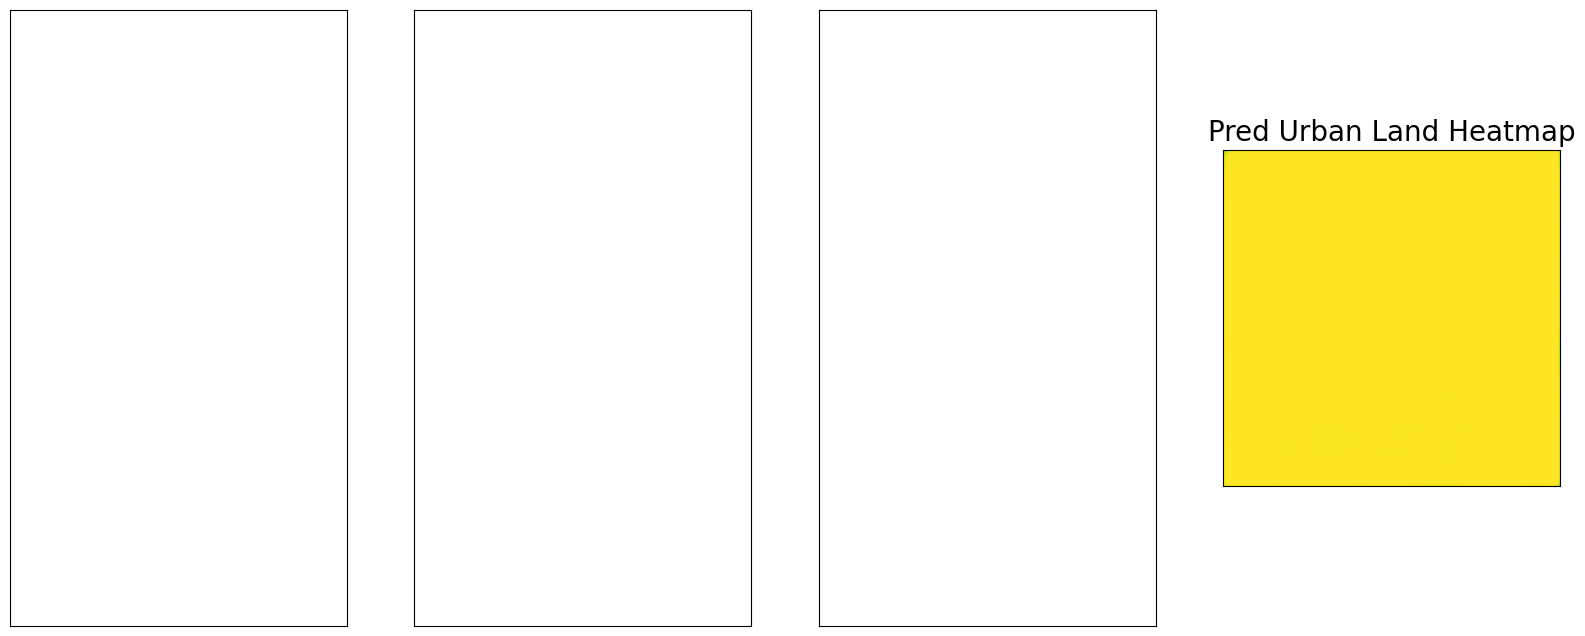

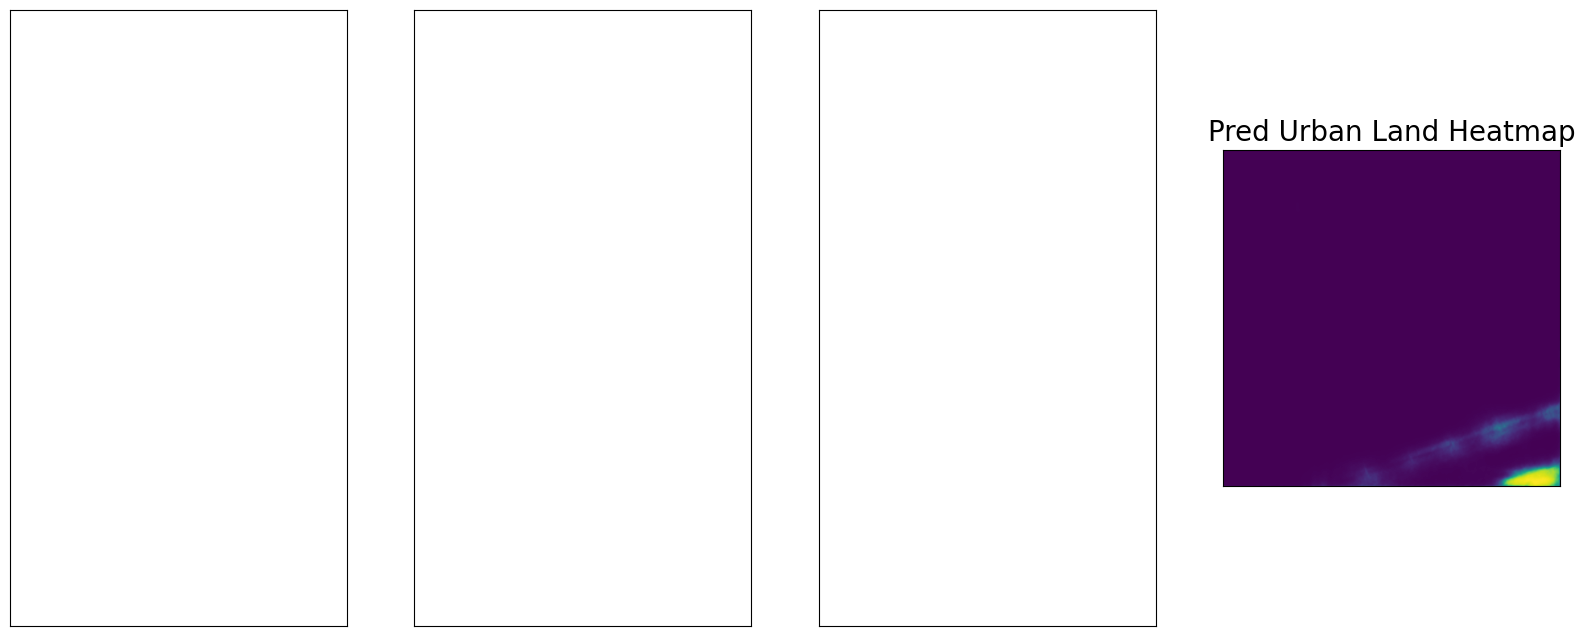

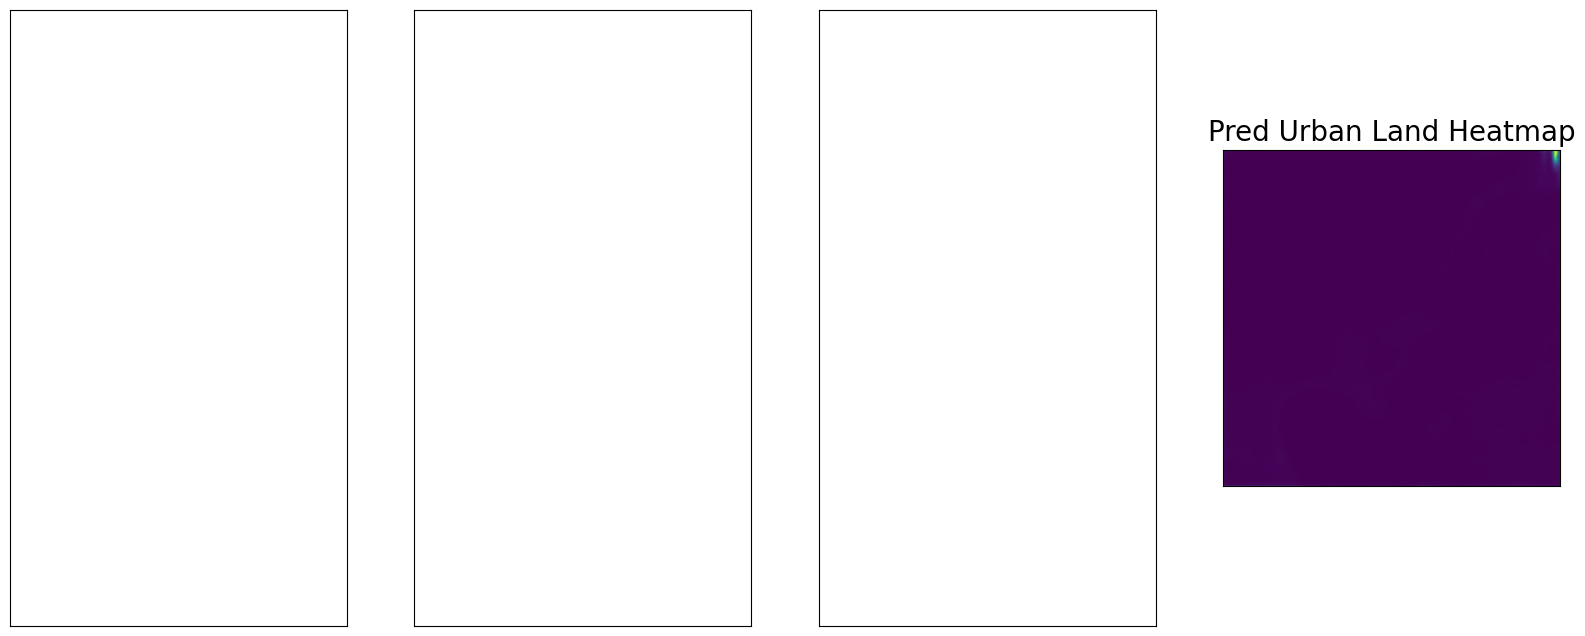

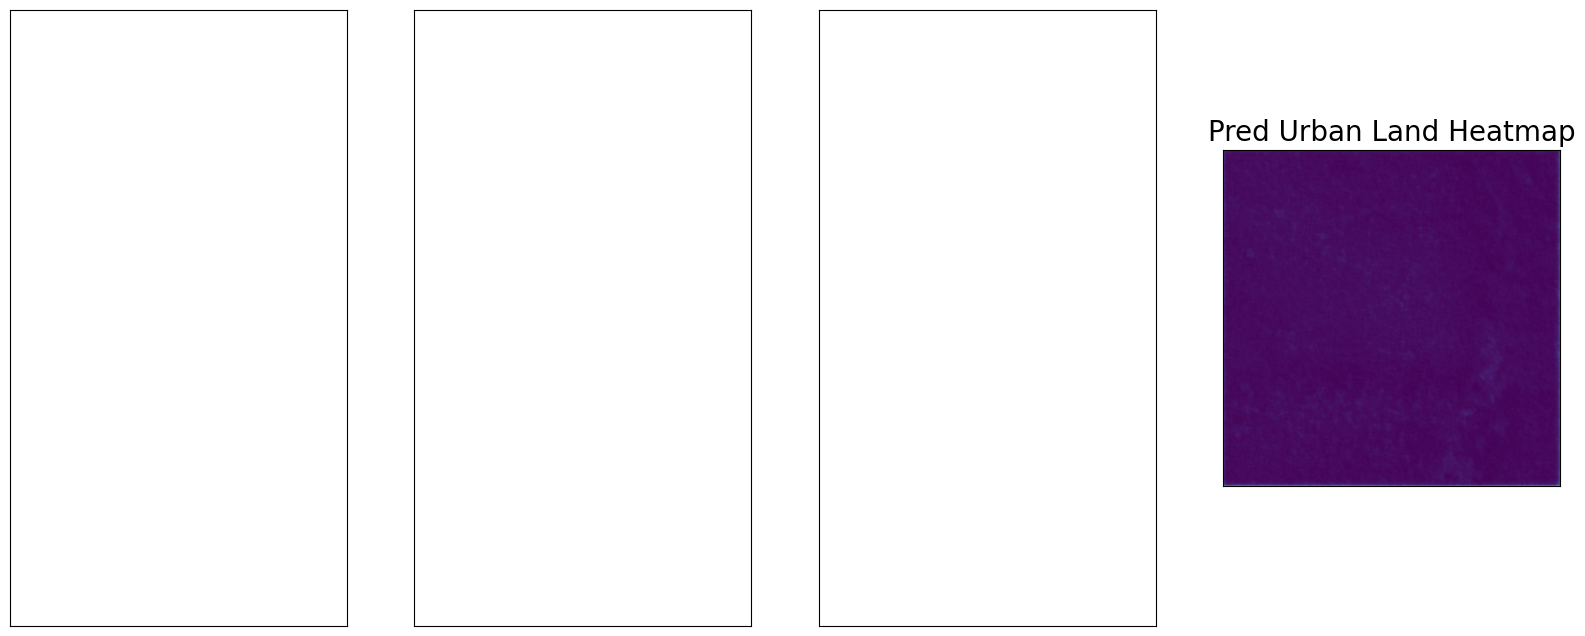

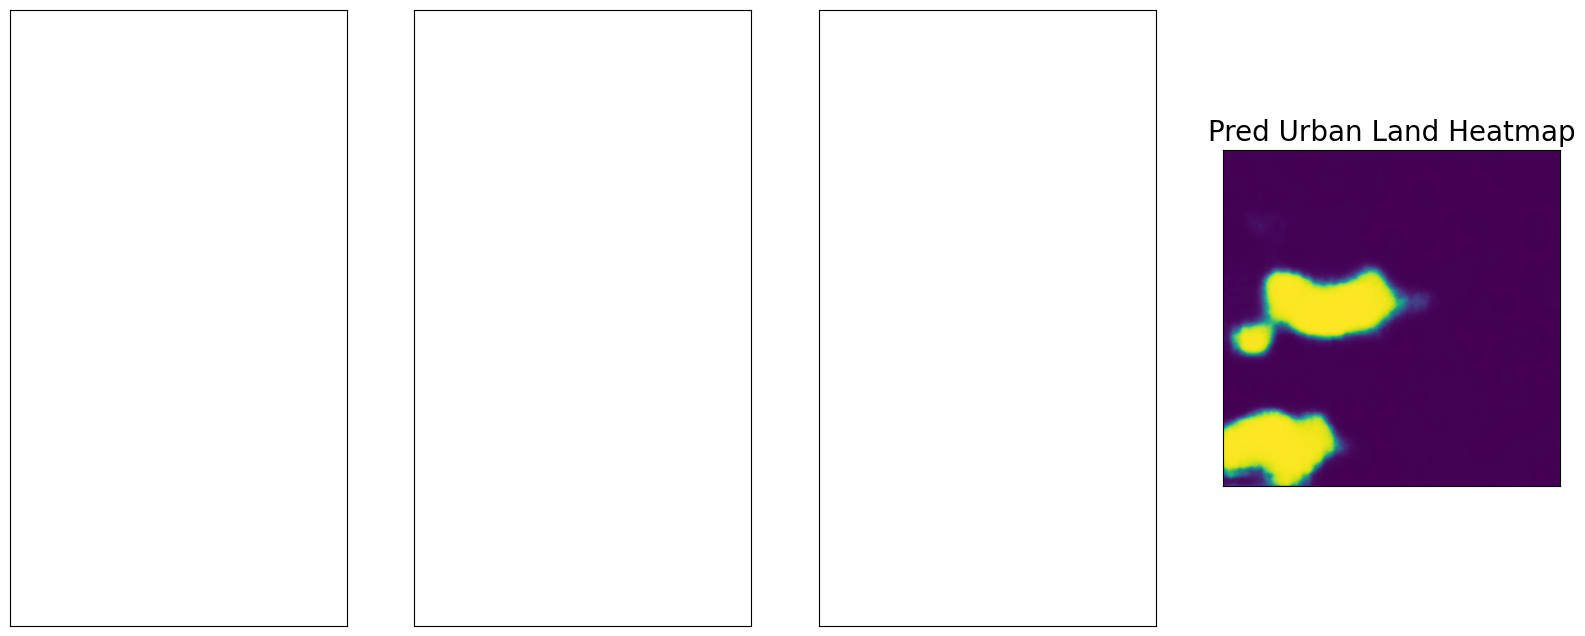

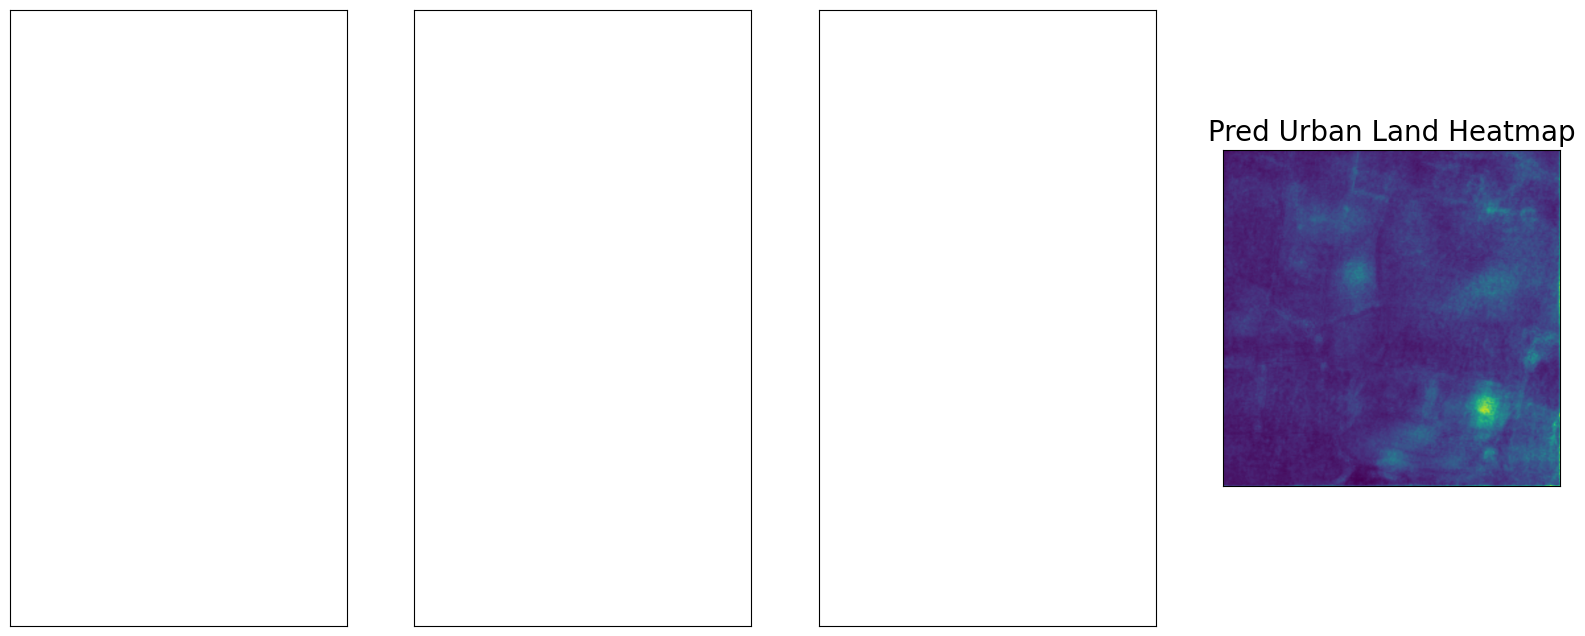

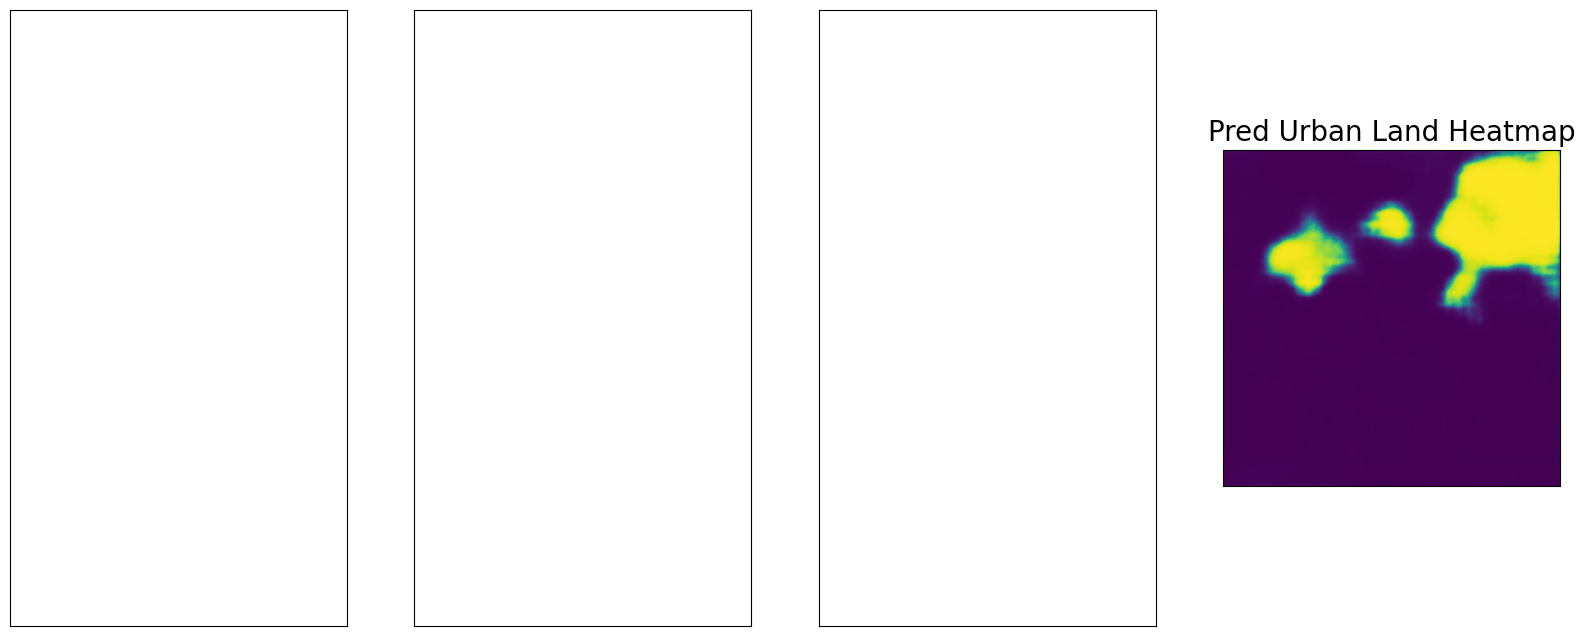

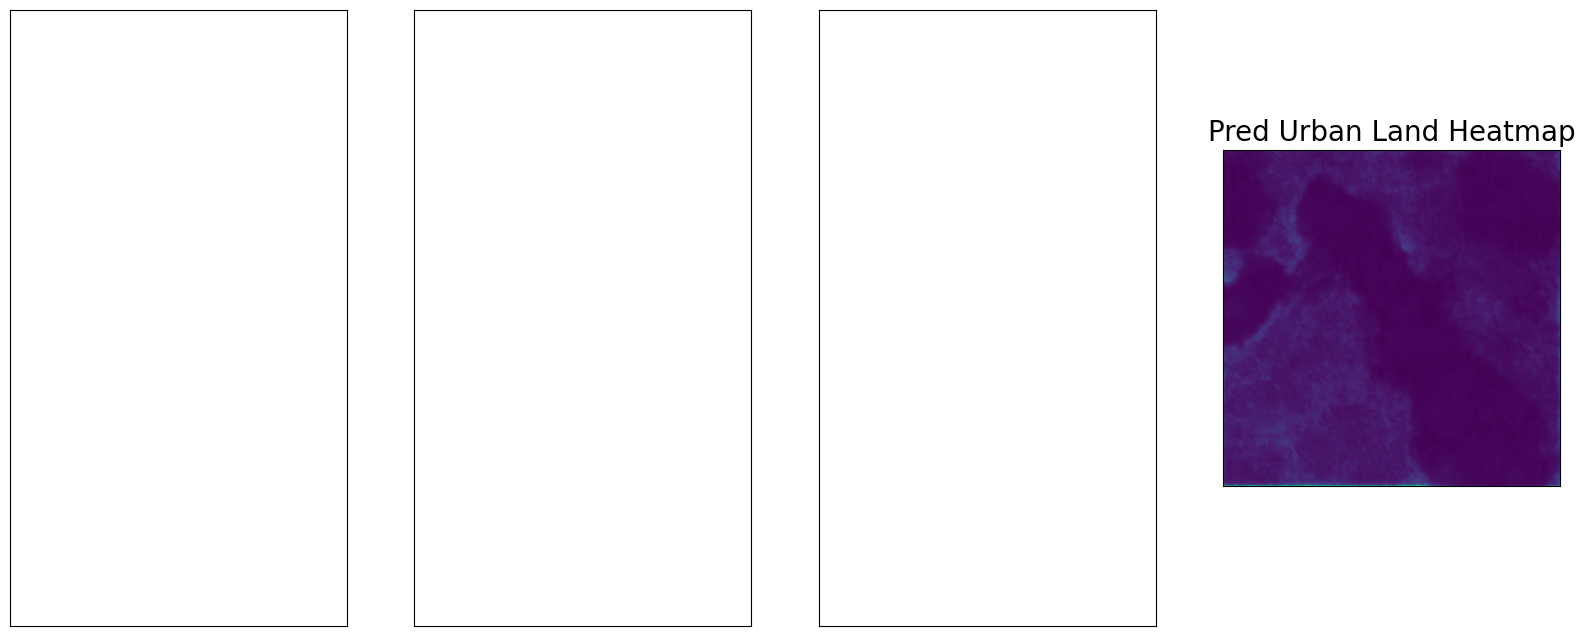

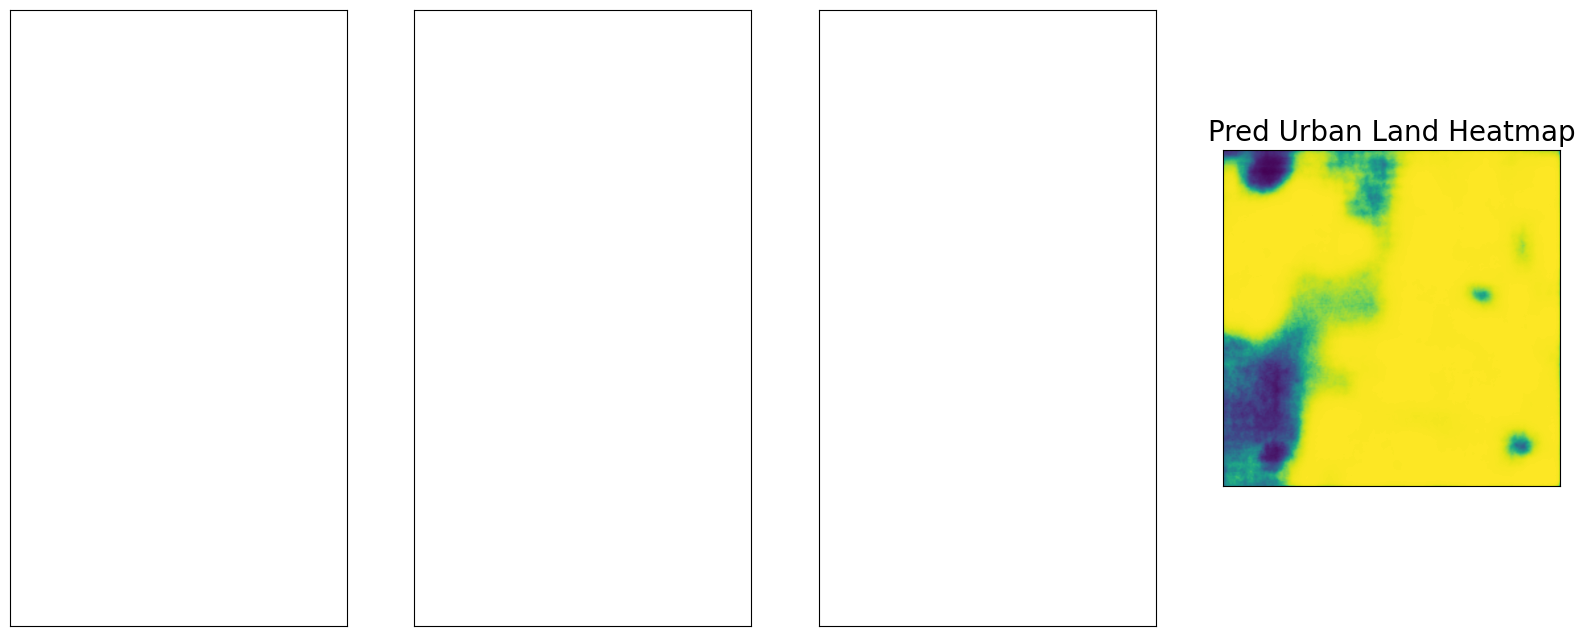

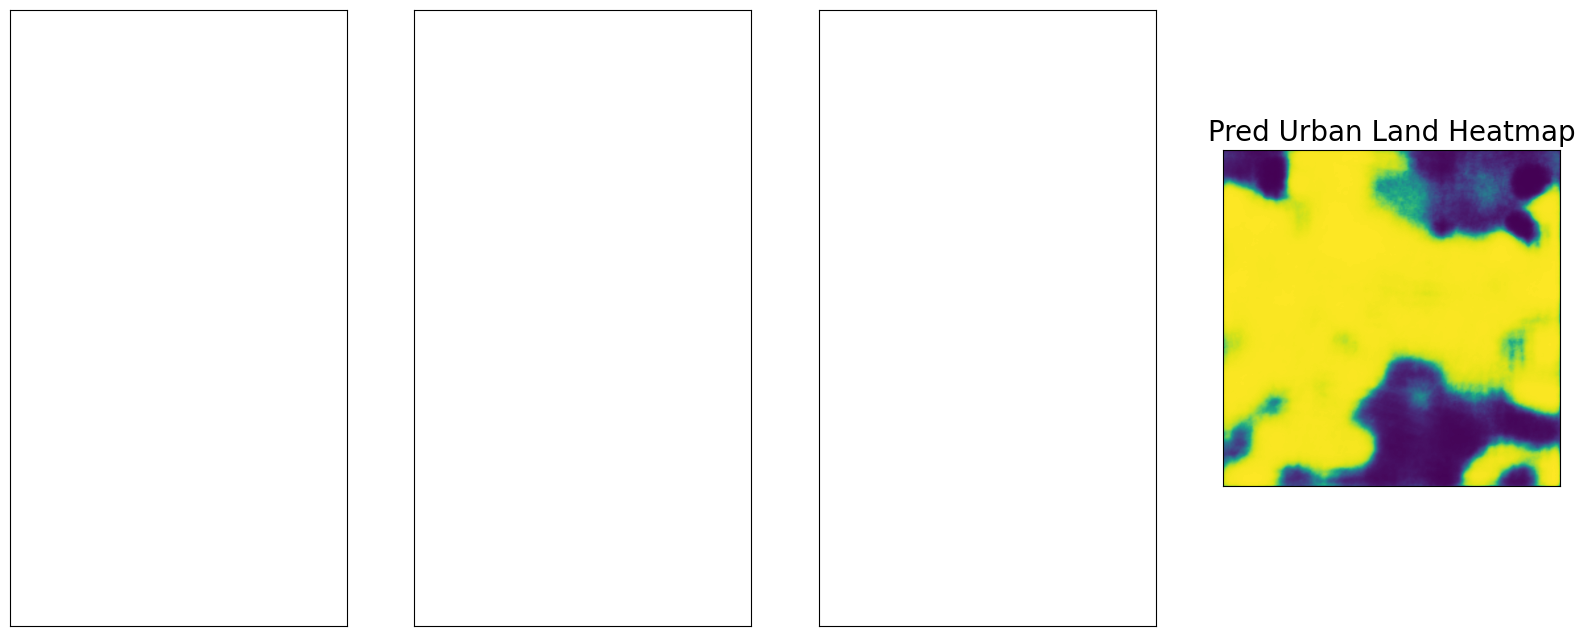

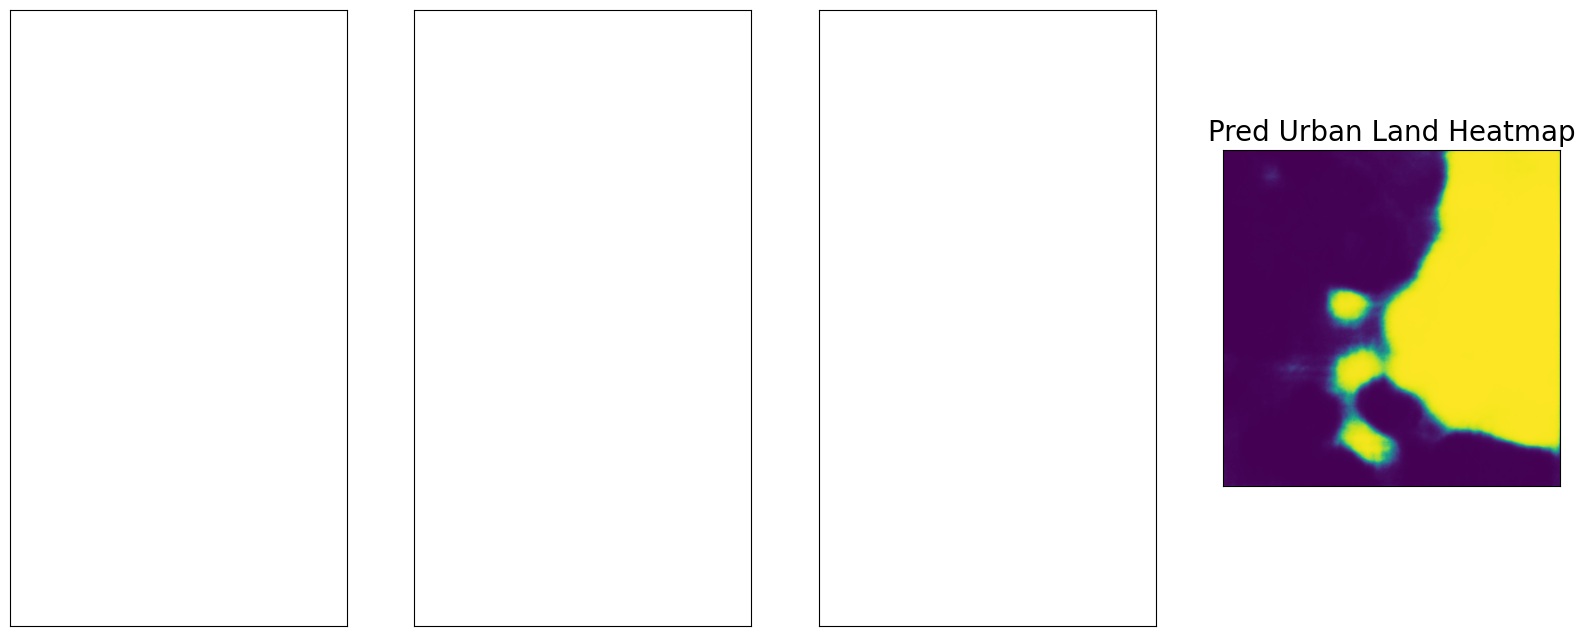

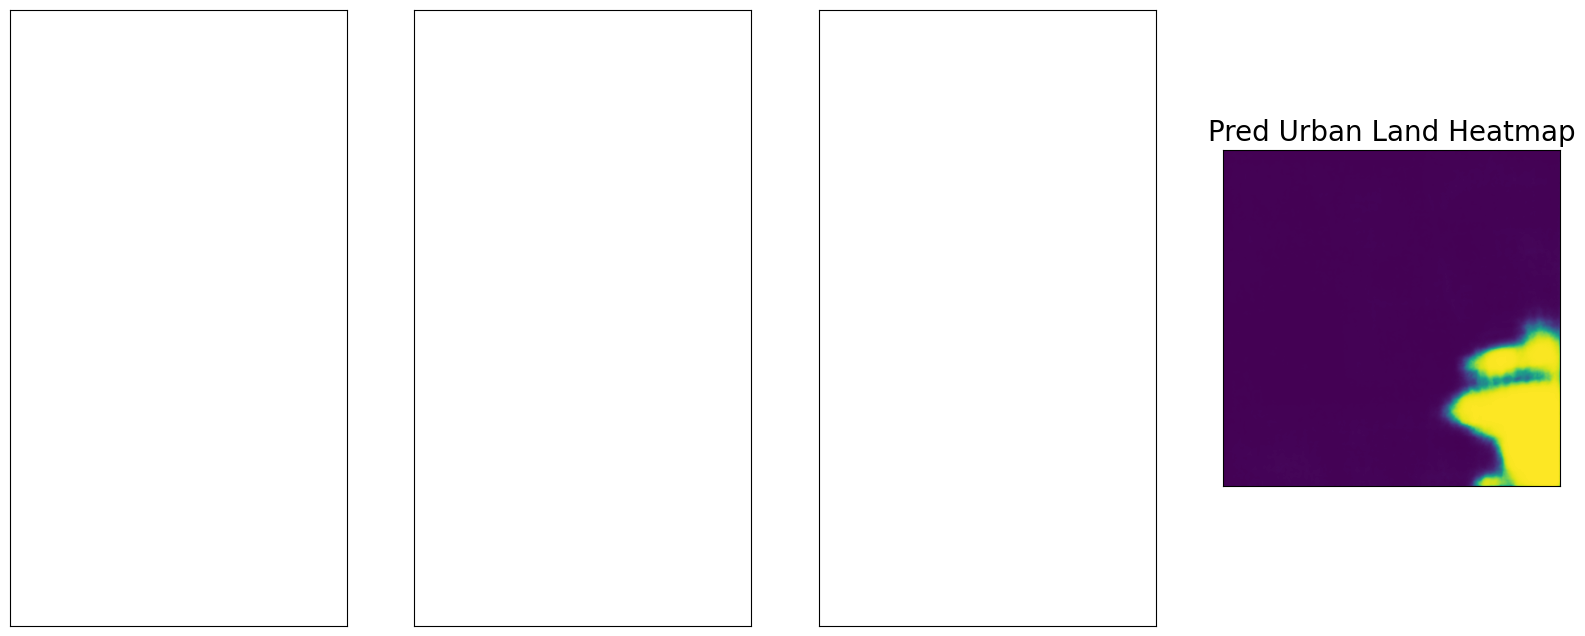

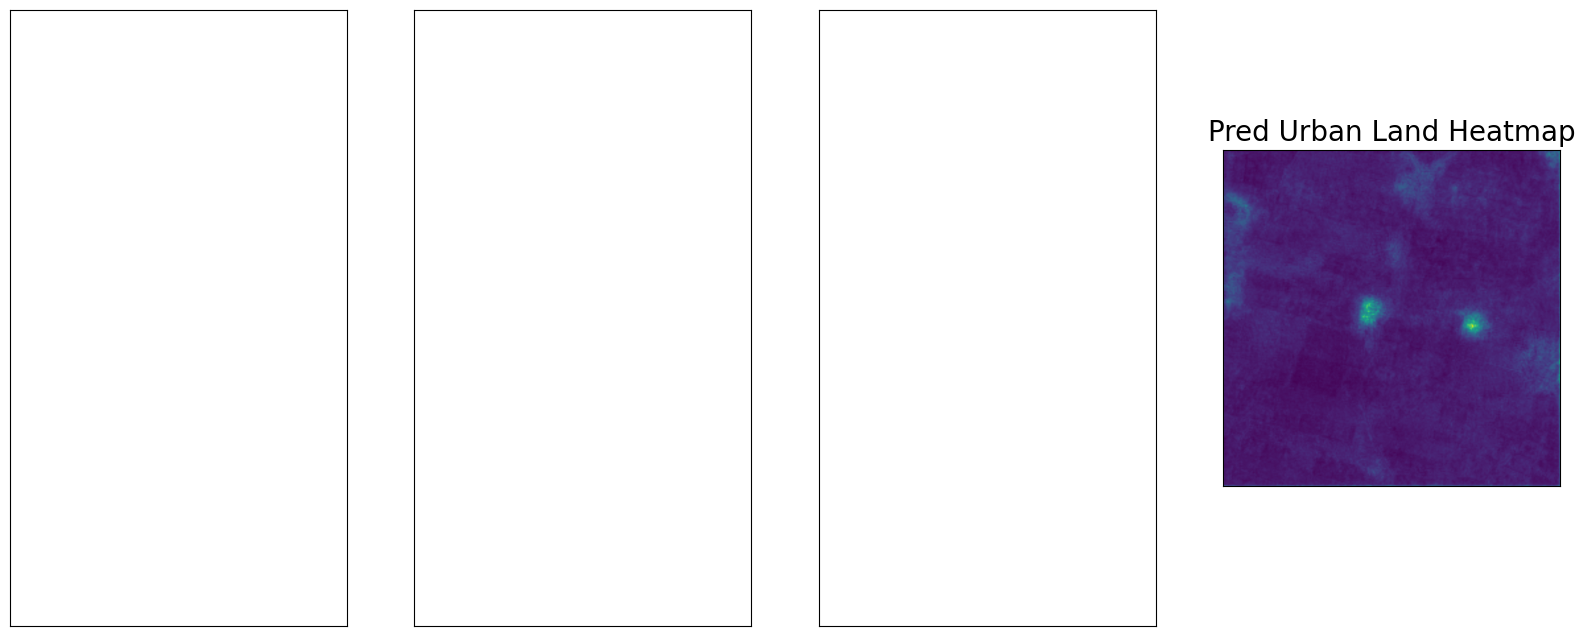

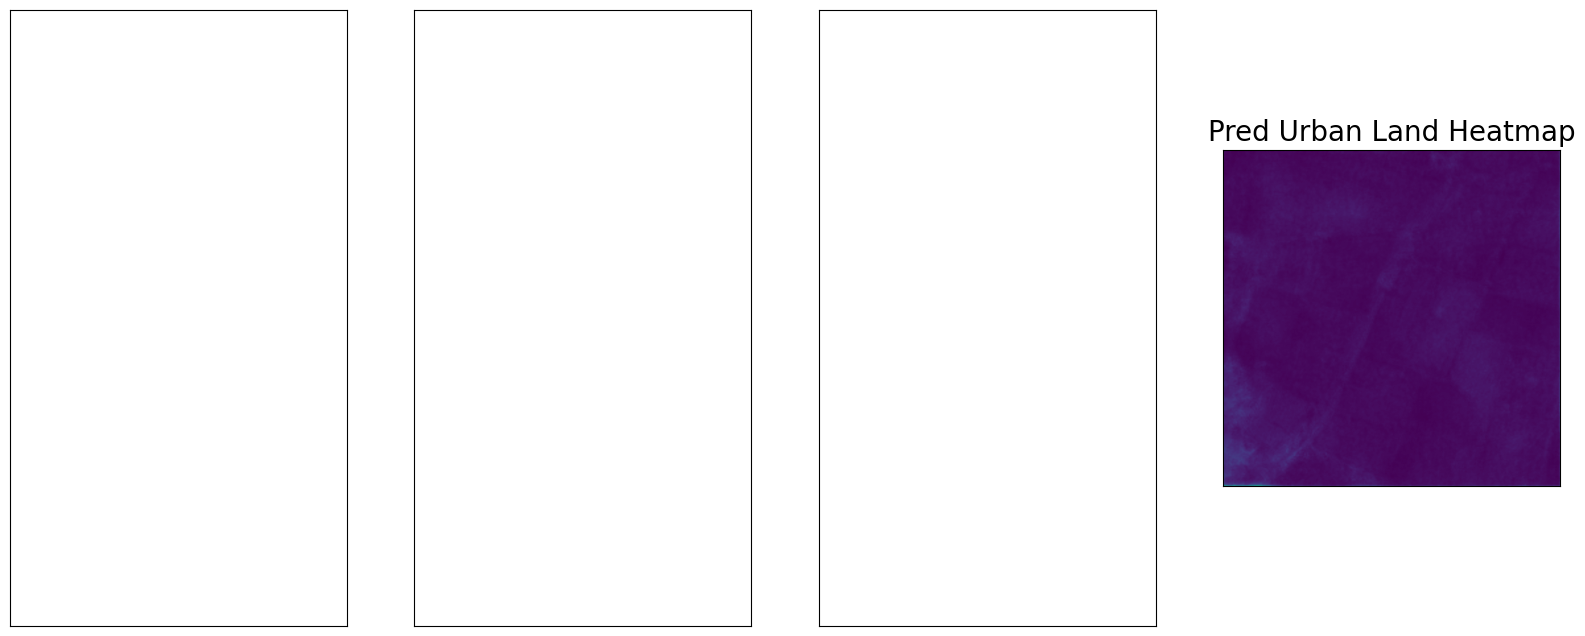

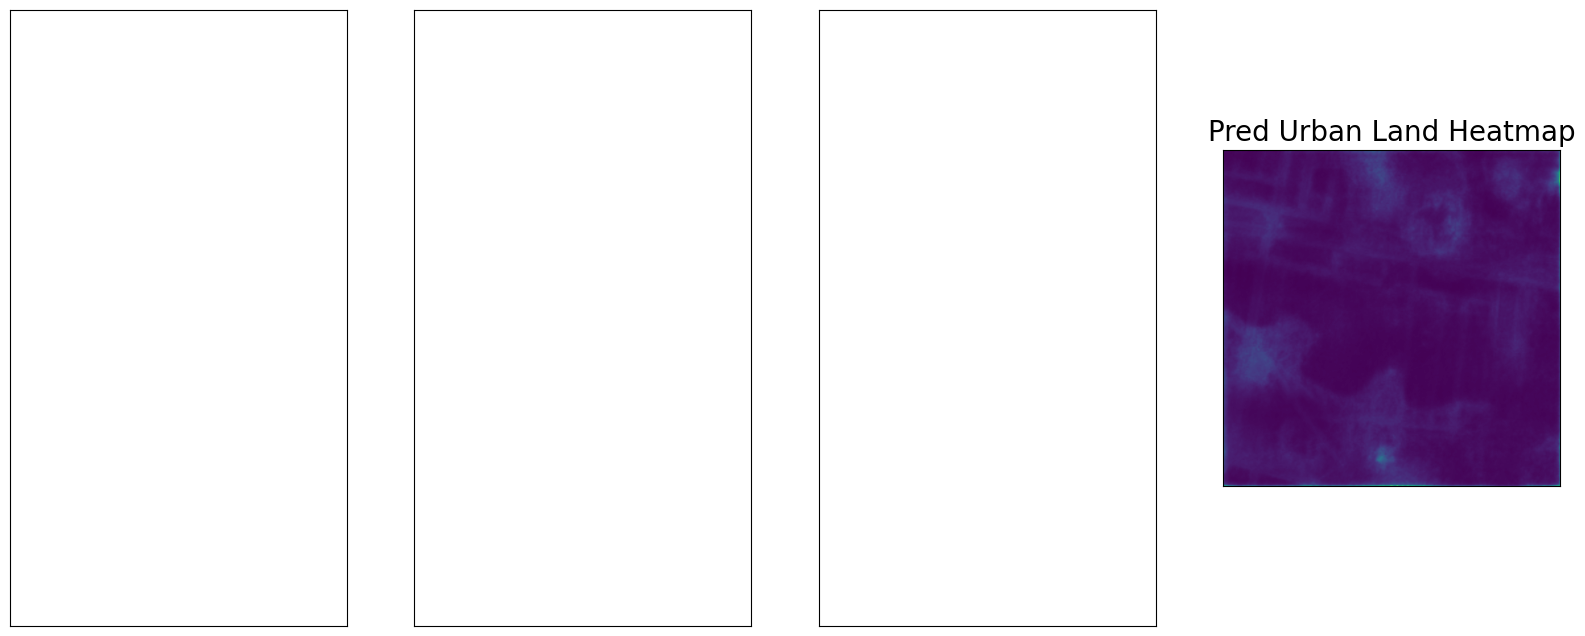

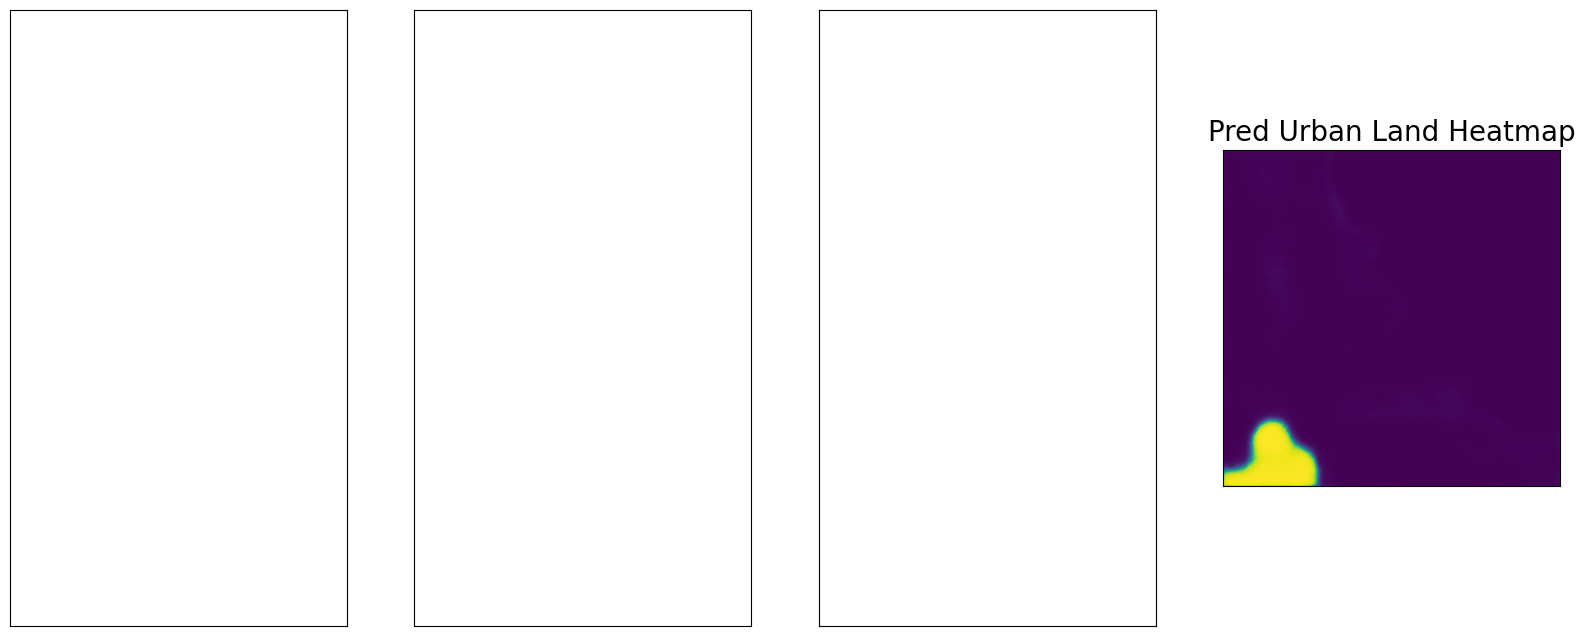

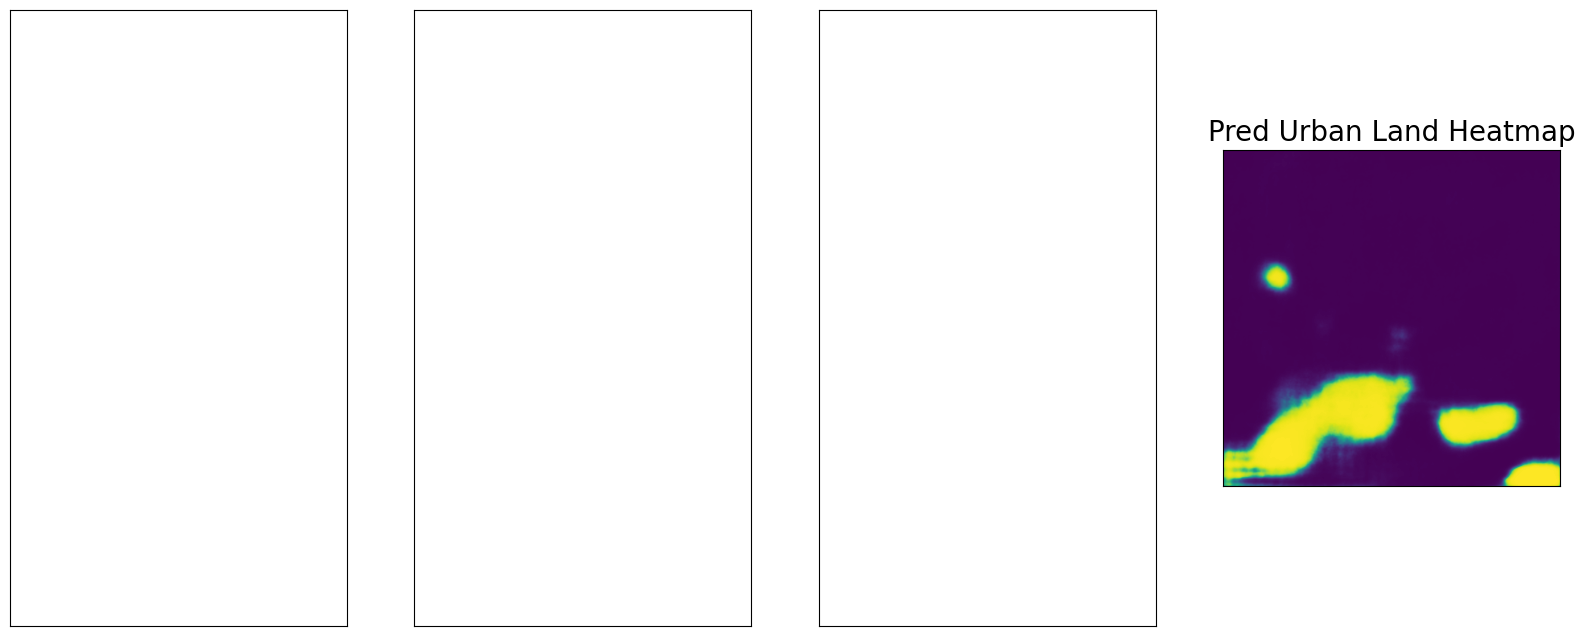

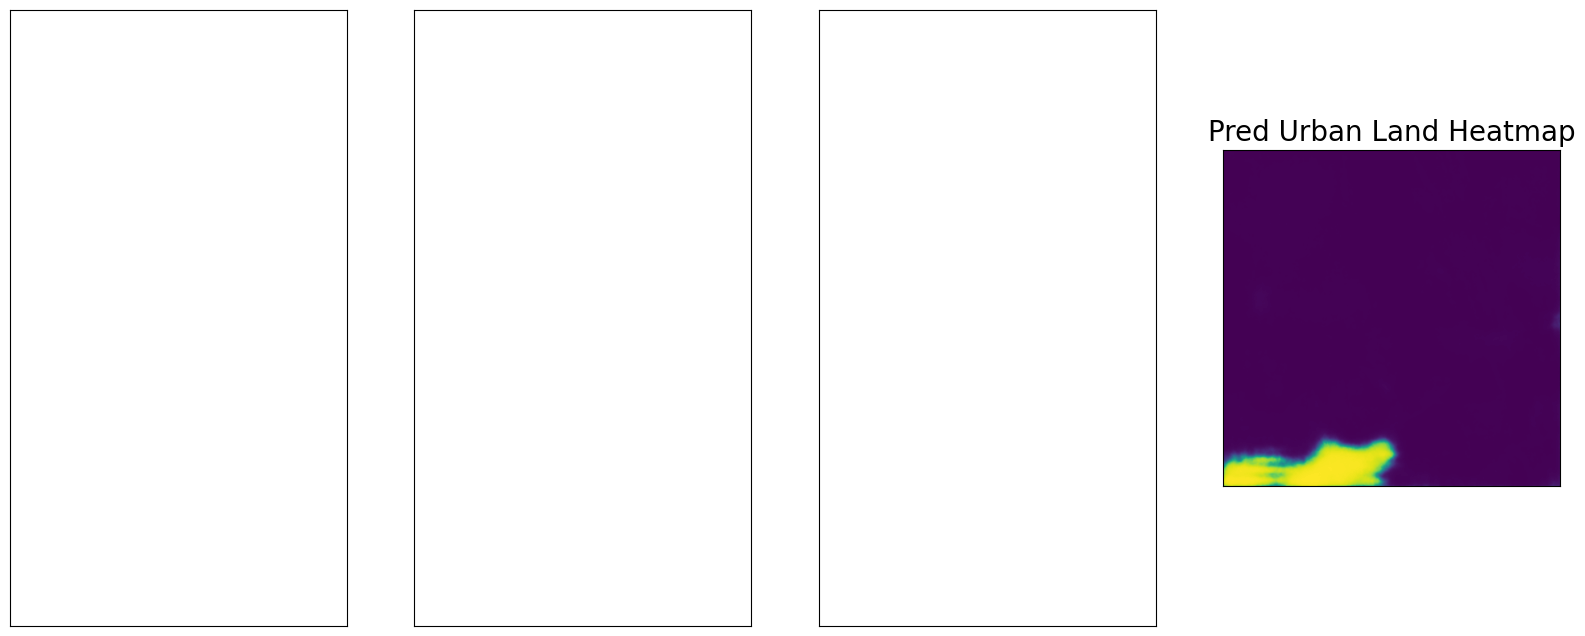

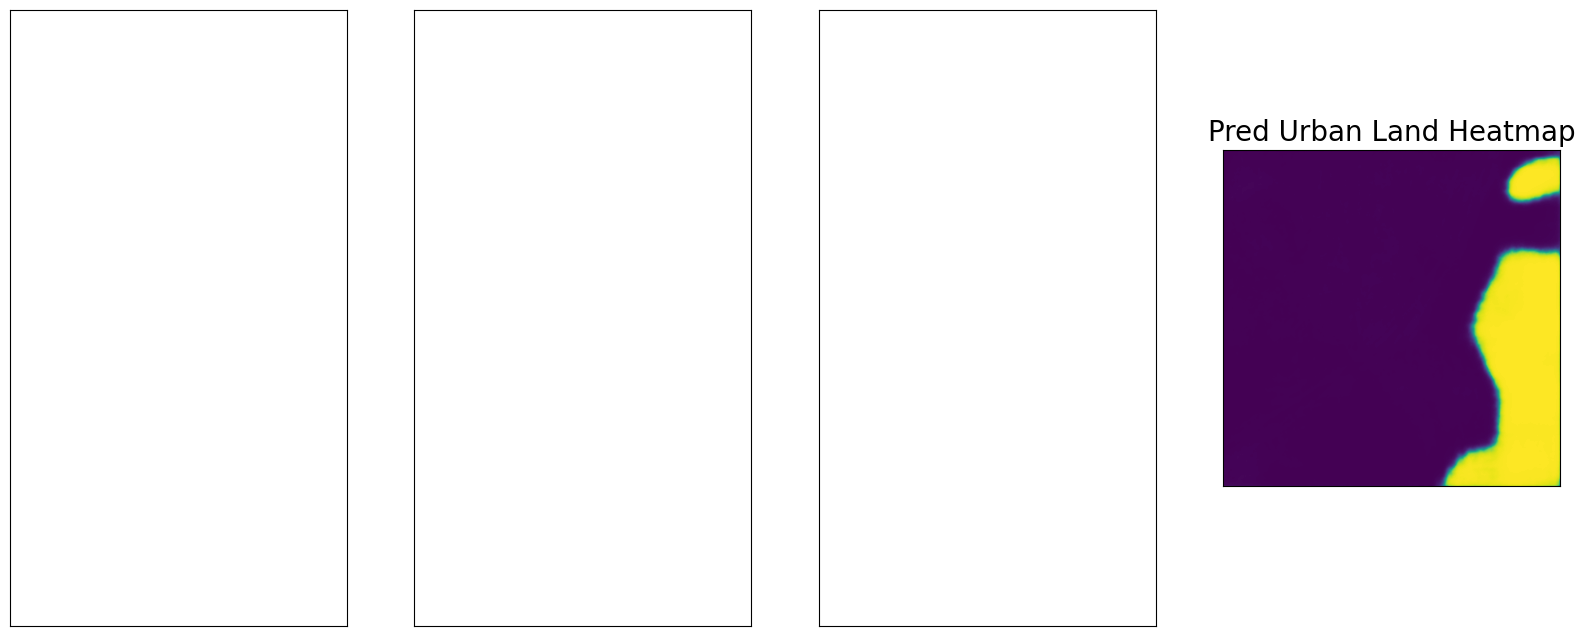

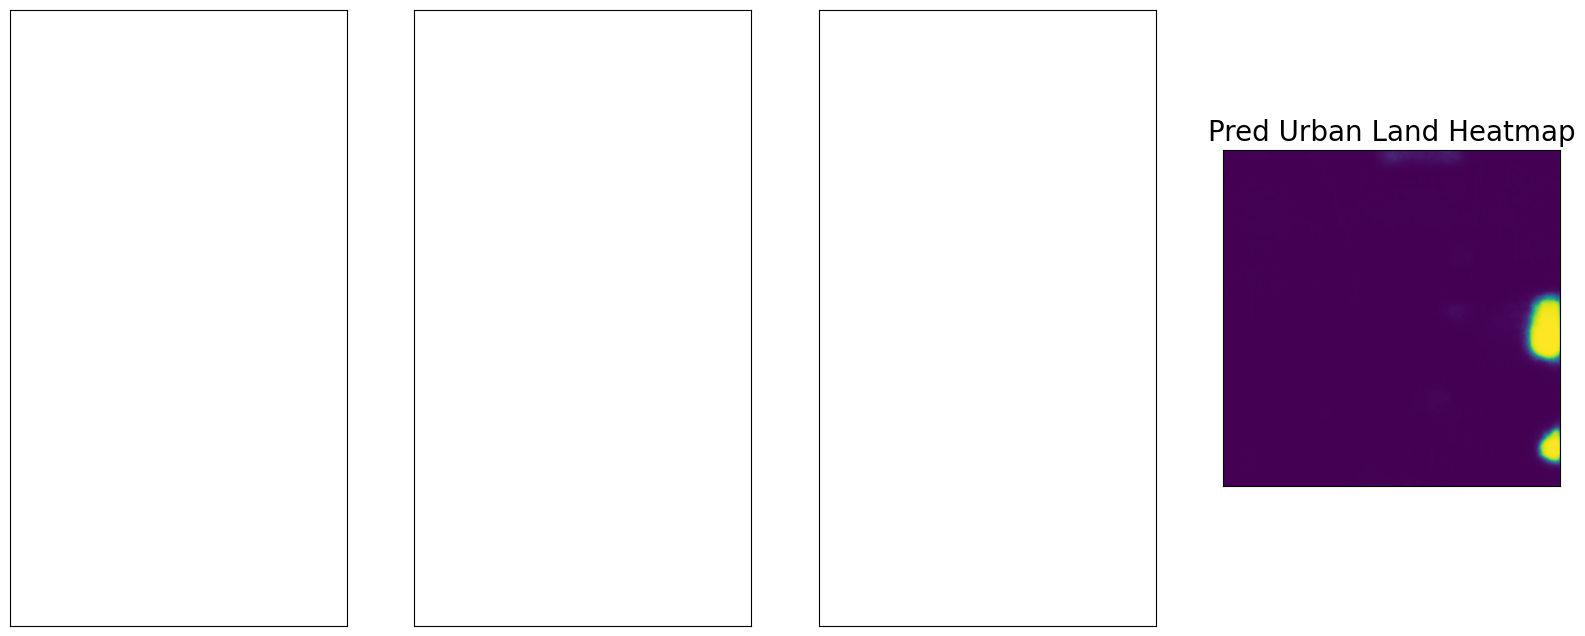

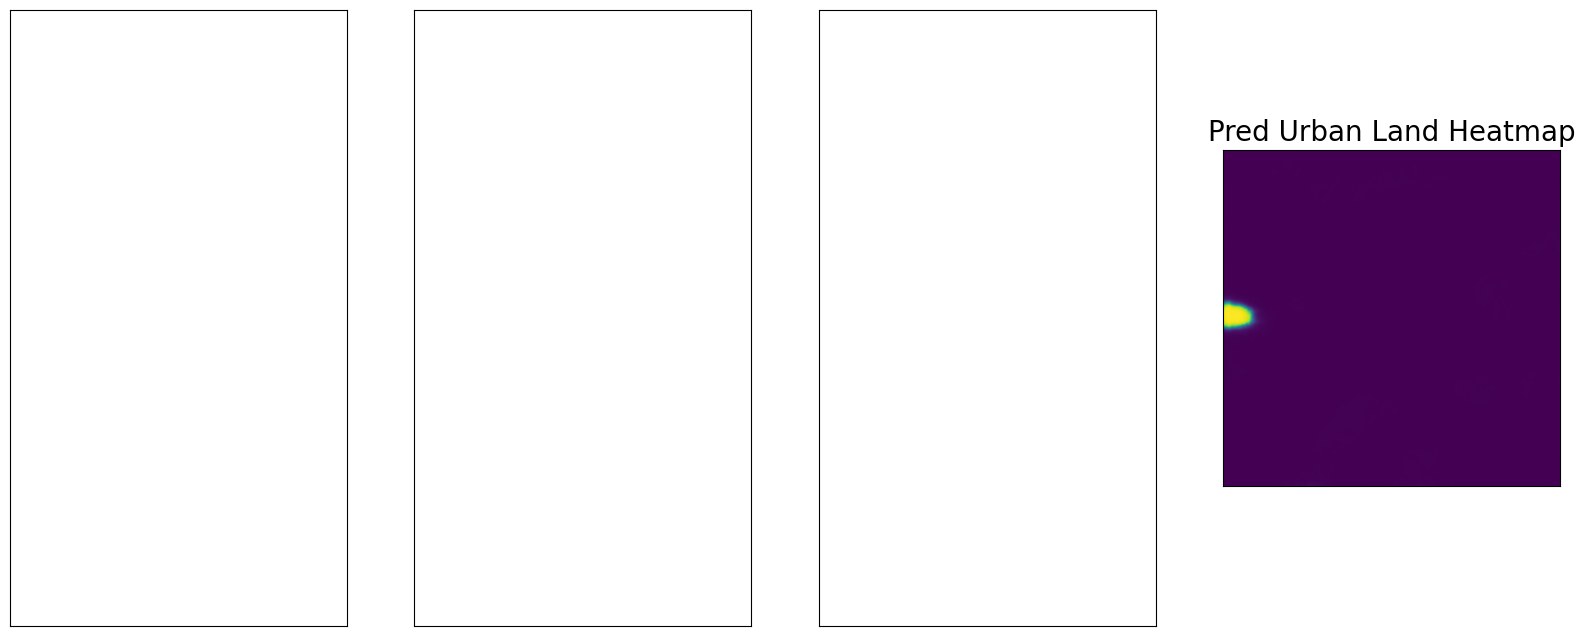

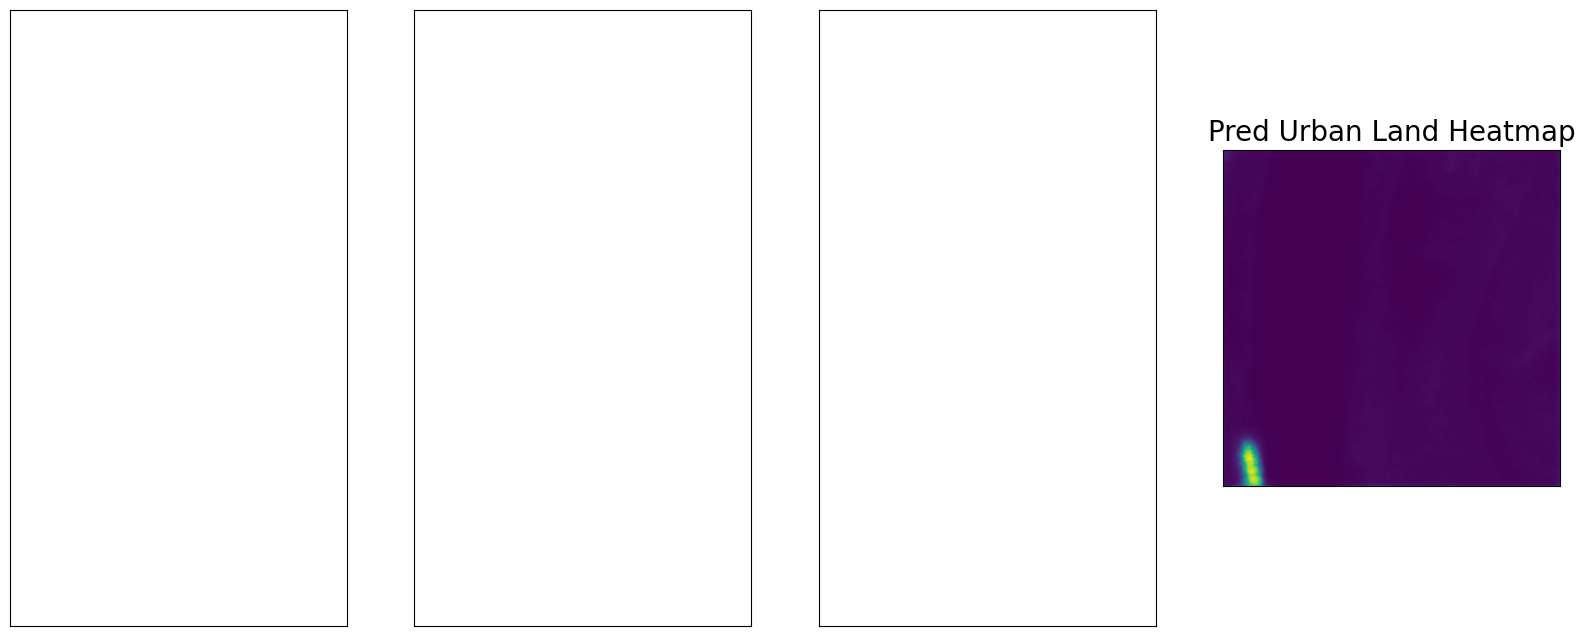

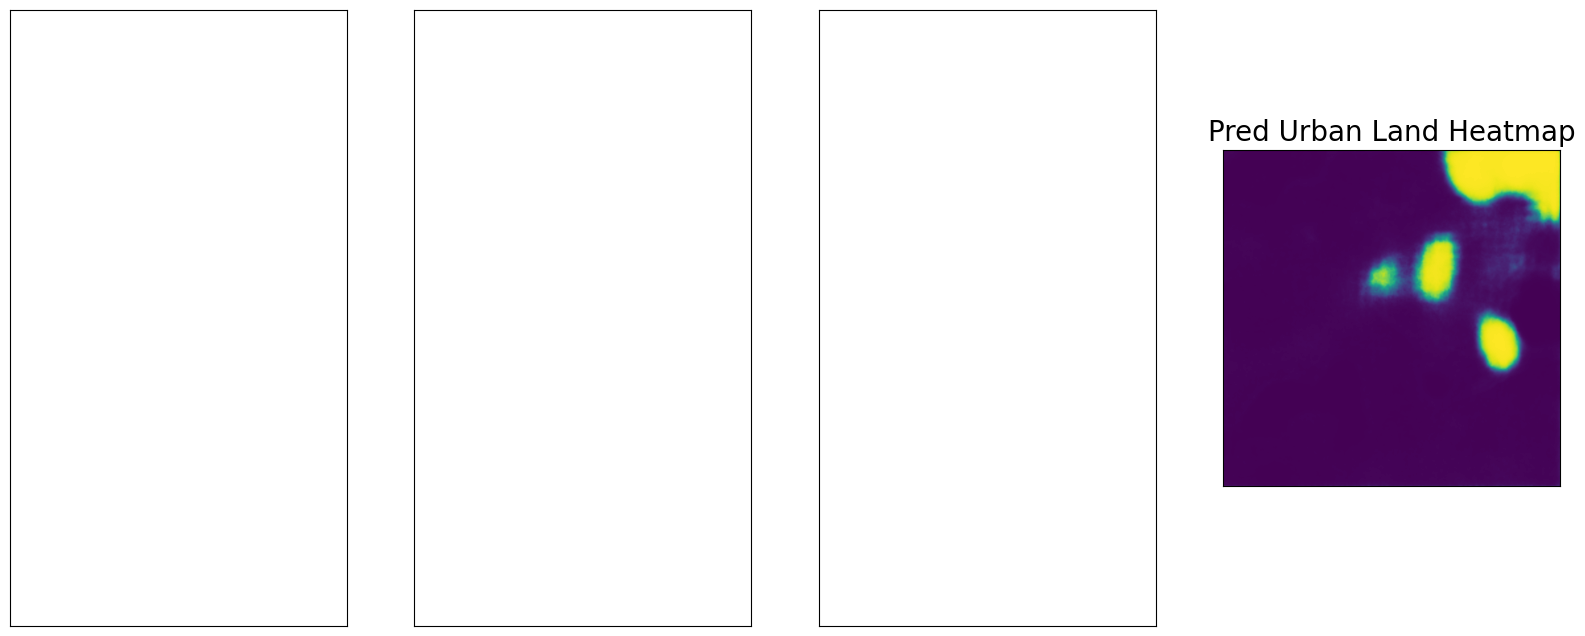

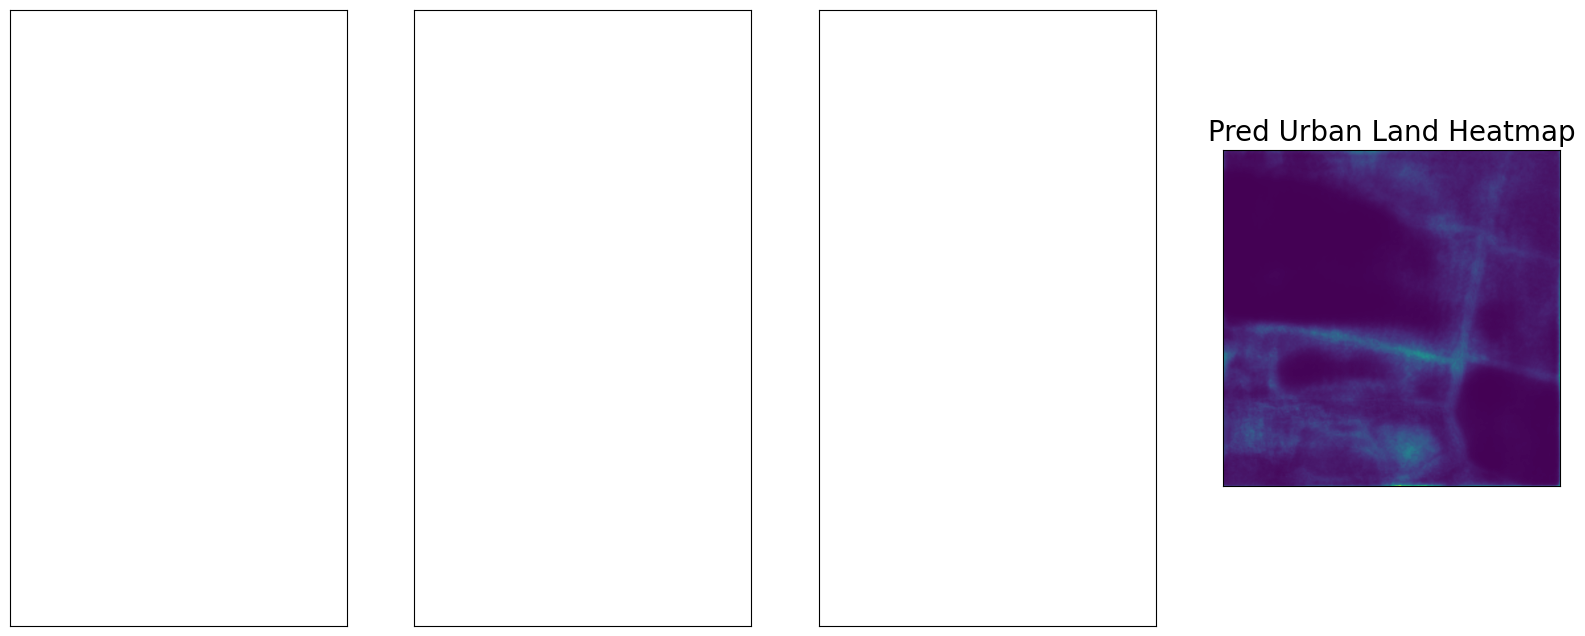

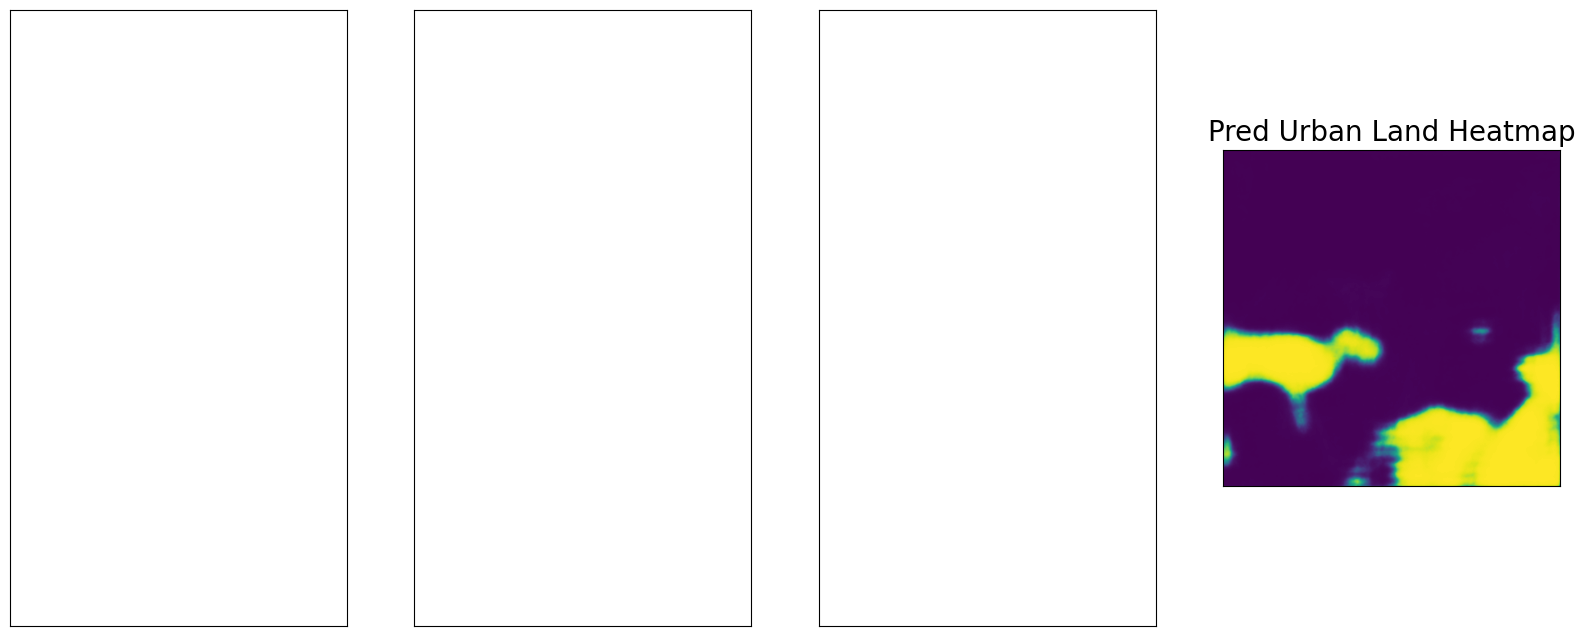

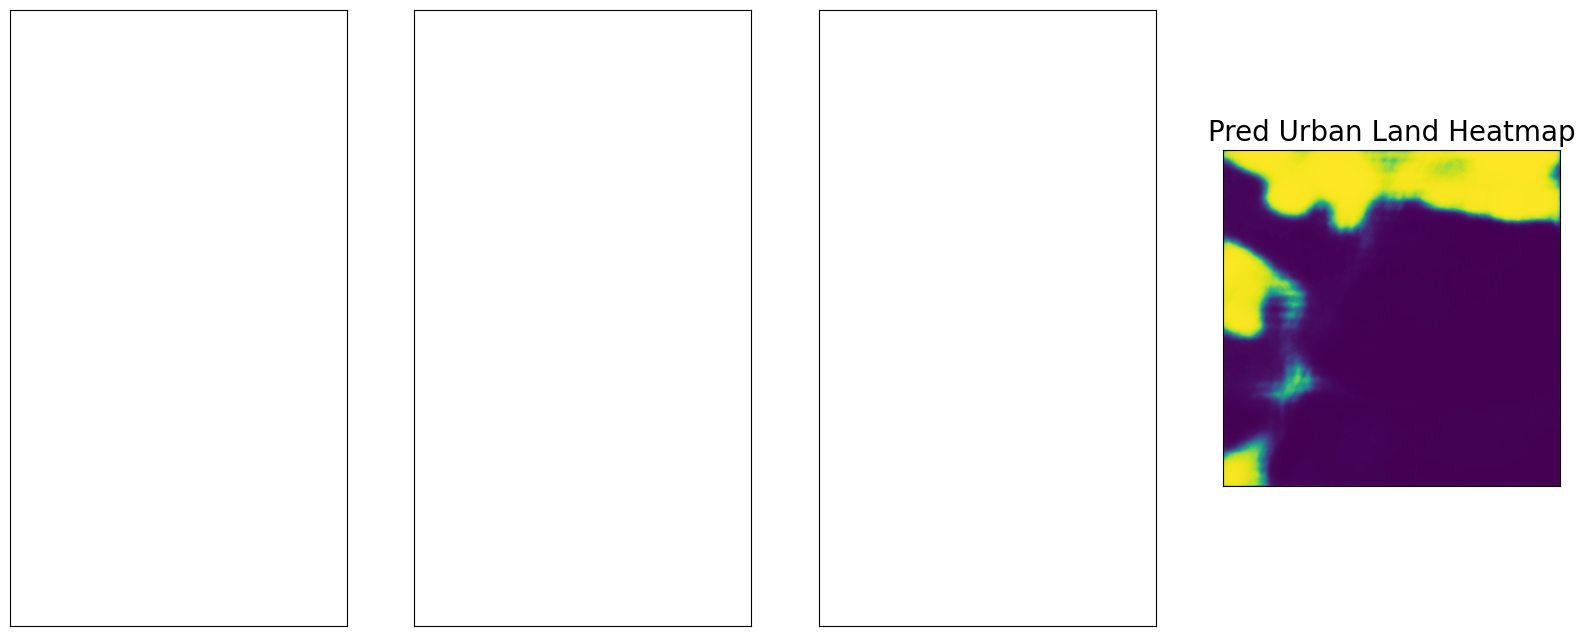

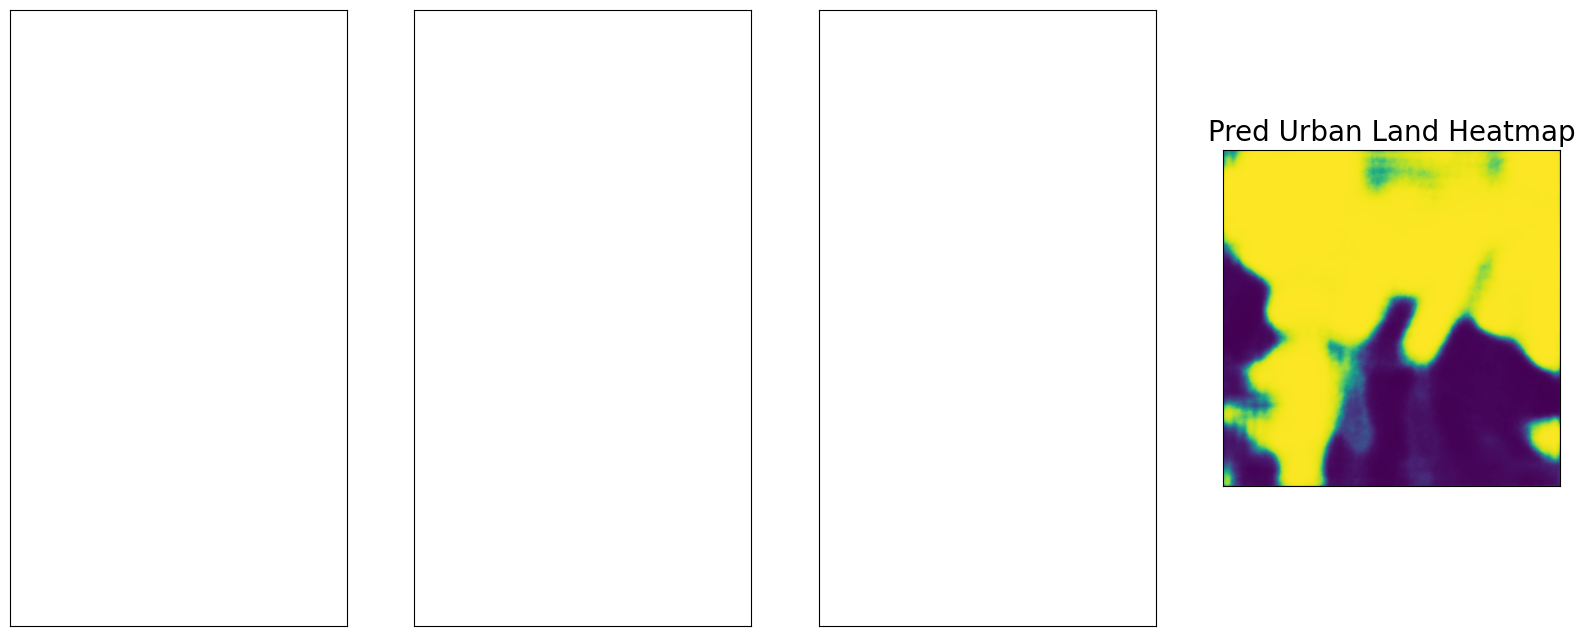

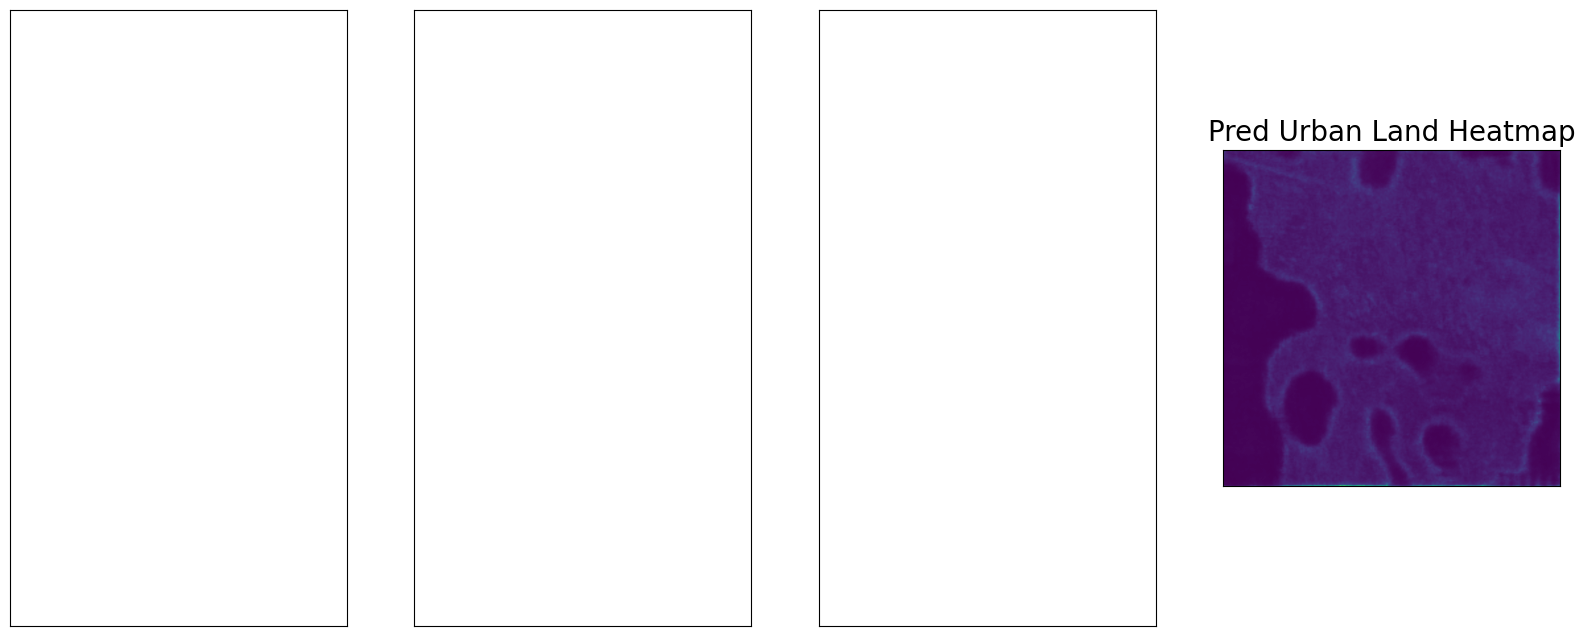

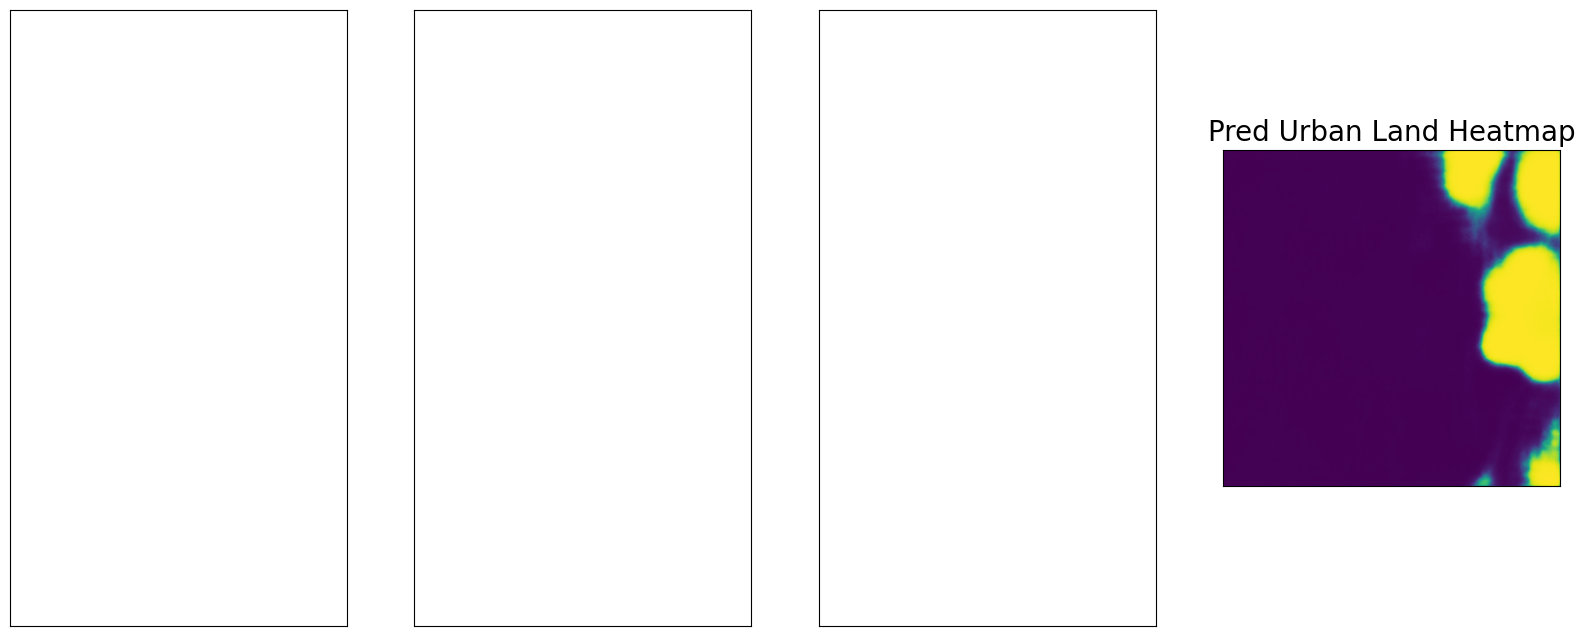

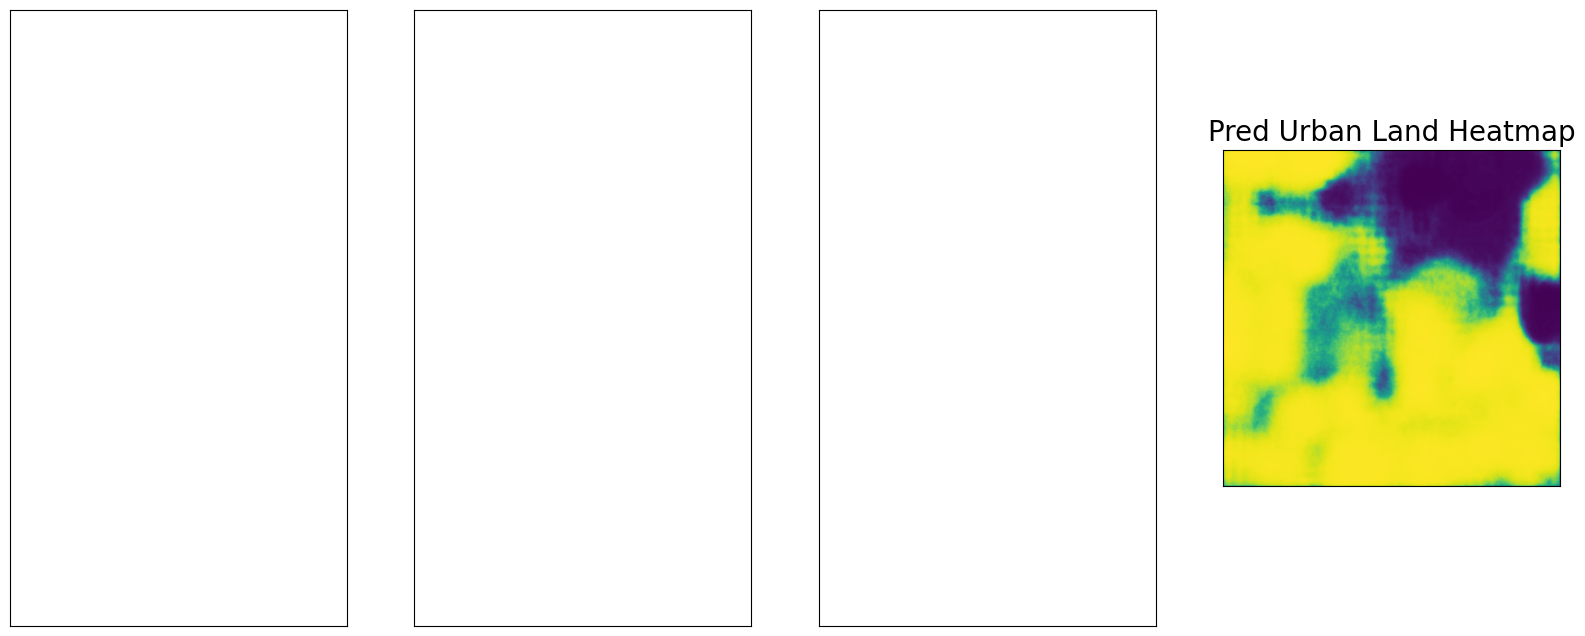

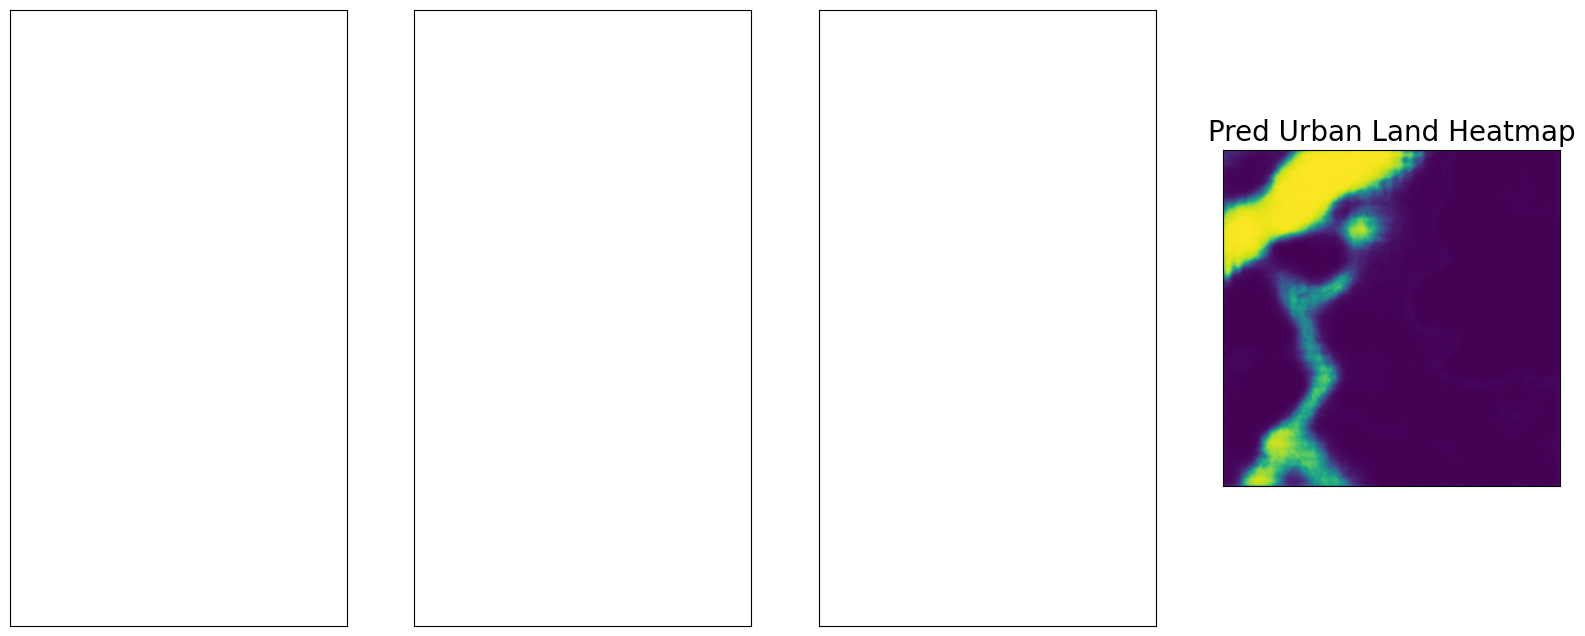

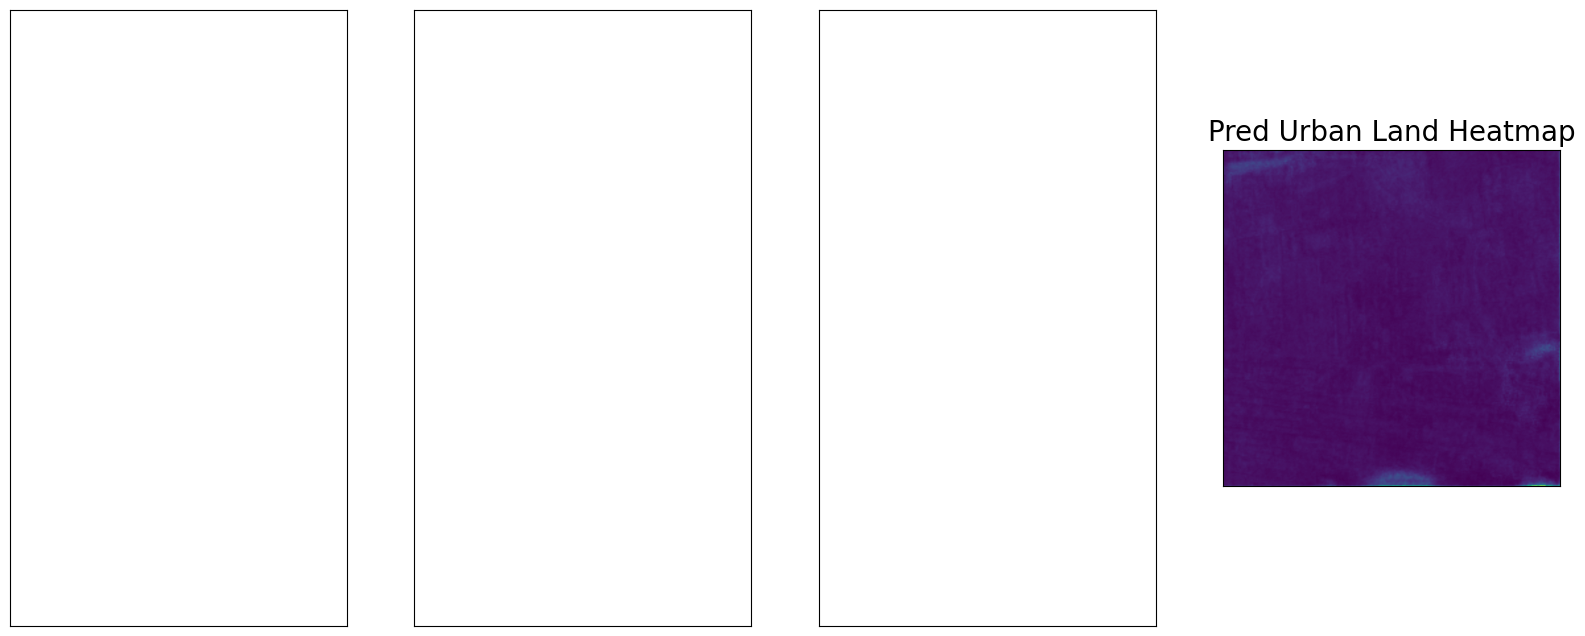

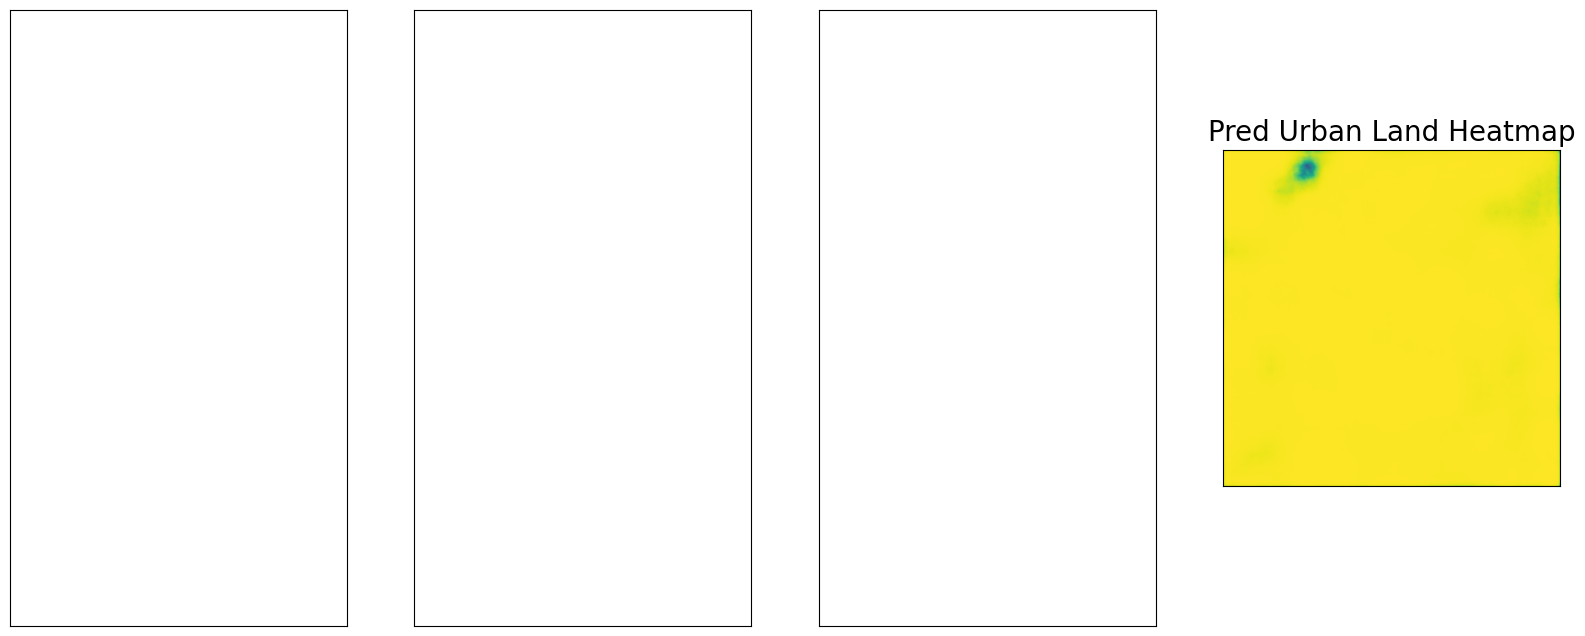

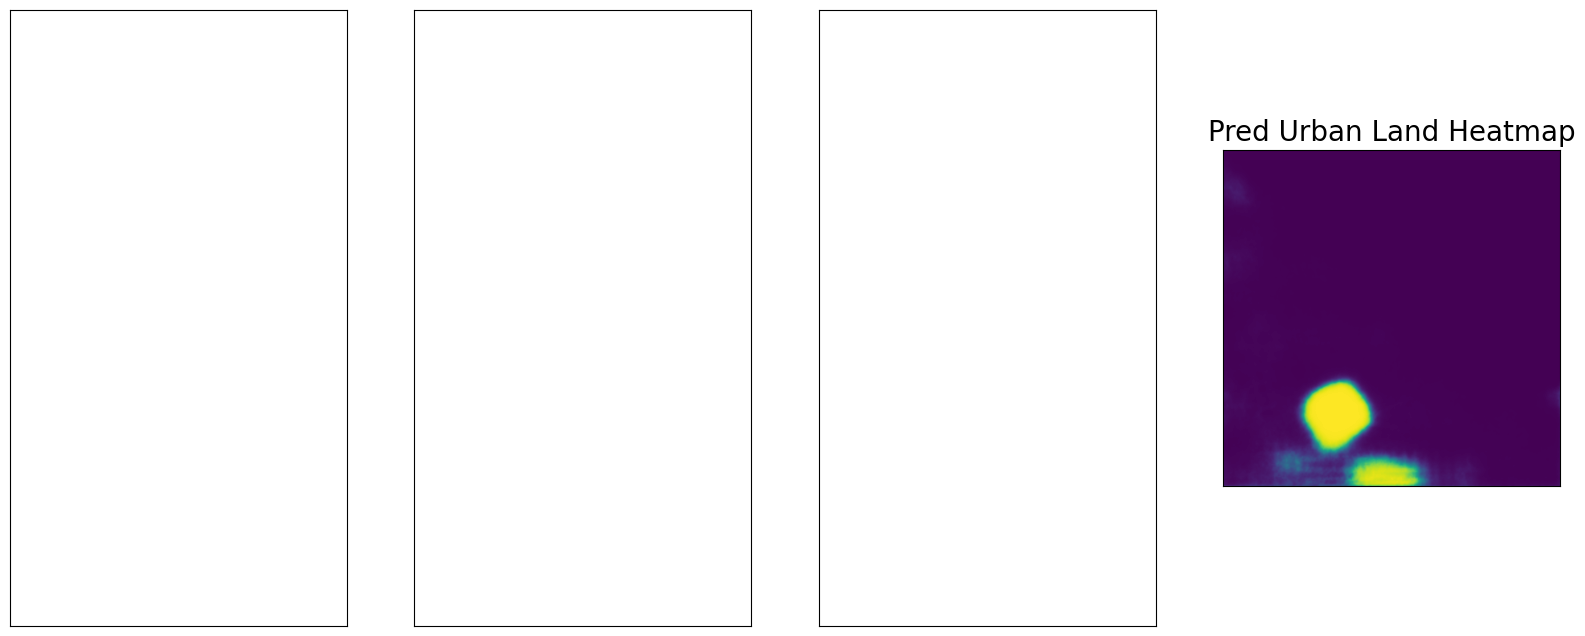

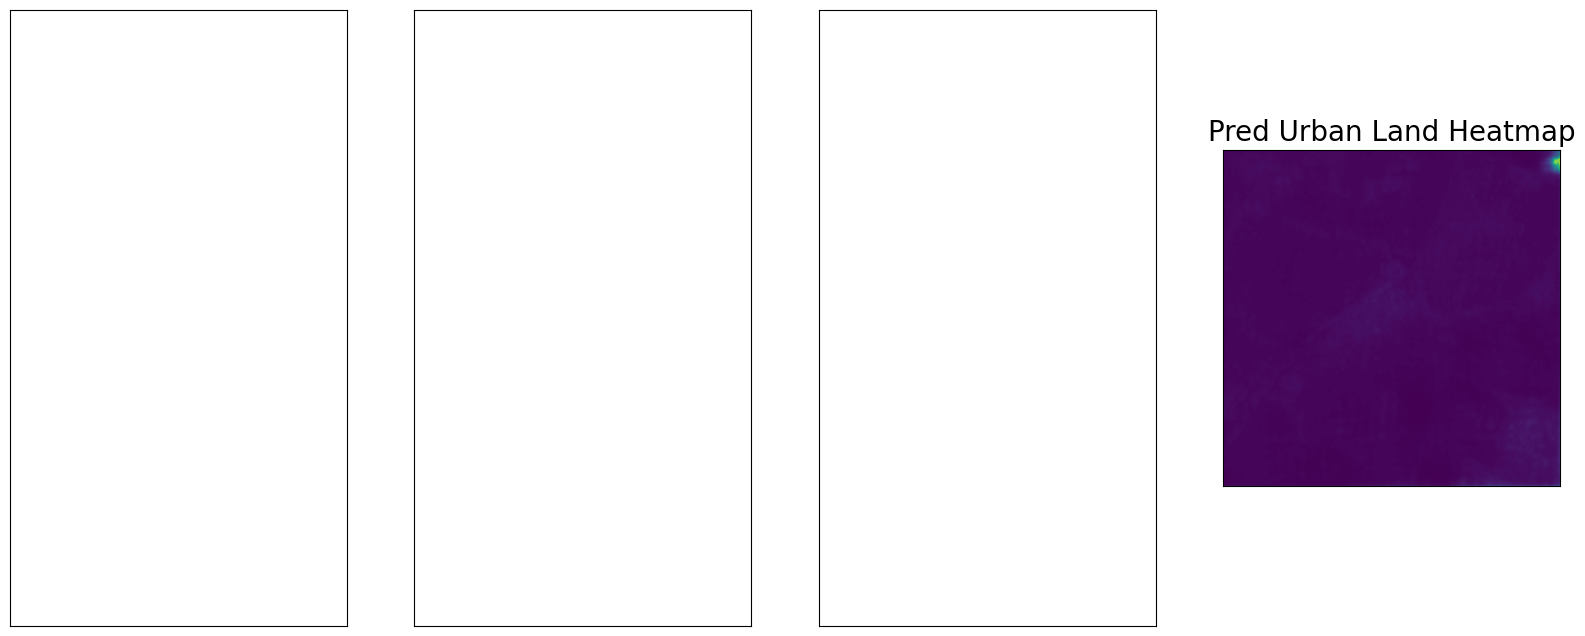

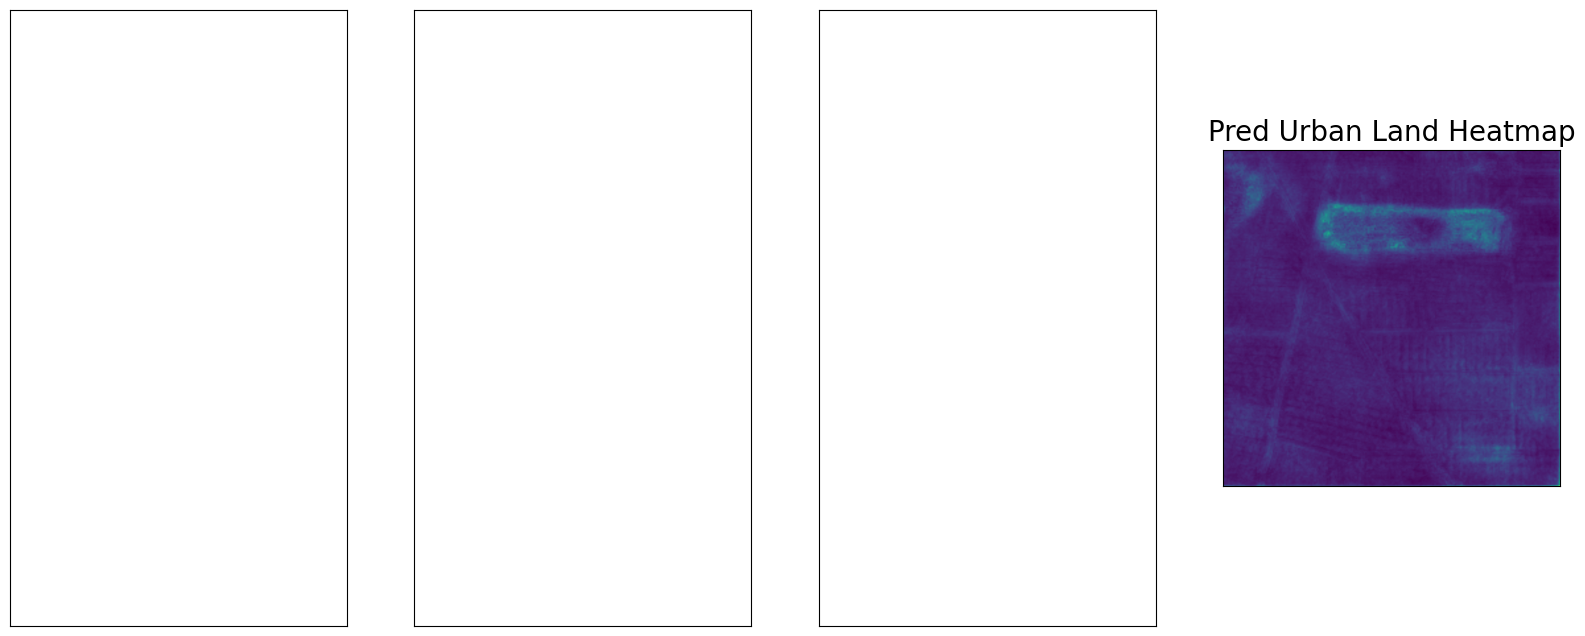

In [44]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_urban_land_heatmap = pred_mask[:,:,select_classes.index('urban_land')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_urban_land_heatmap = pred_urban_land_heatmap
    )

In [ ]:
"Model Evaluation on Test Dataset"

In [50]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")


AttributeError: 'str' object has no attribute 'to'

In [ ]:
"Plot Dice Loss & IoU Metric for Train vs. Val"

In [47]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1        2         3         4
dice_loss  0.286402  0.276261  0.28588  0.285668  0.285993
iou_score  0.623814  0.633779  0.62308  0.623929  0.623881

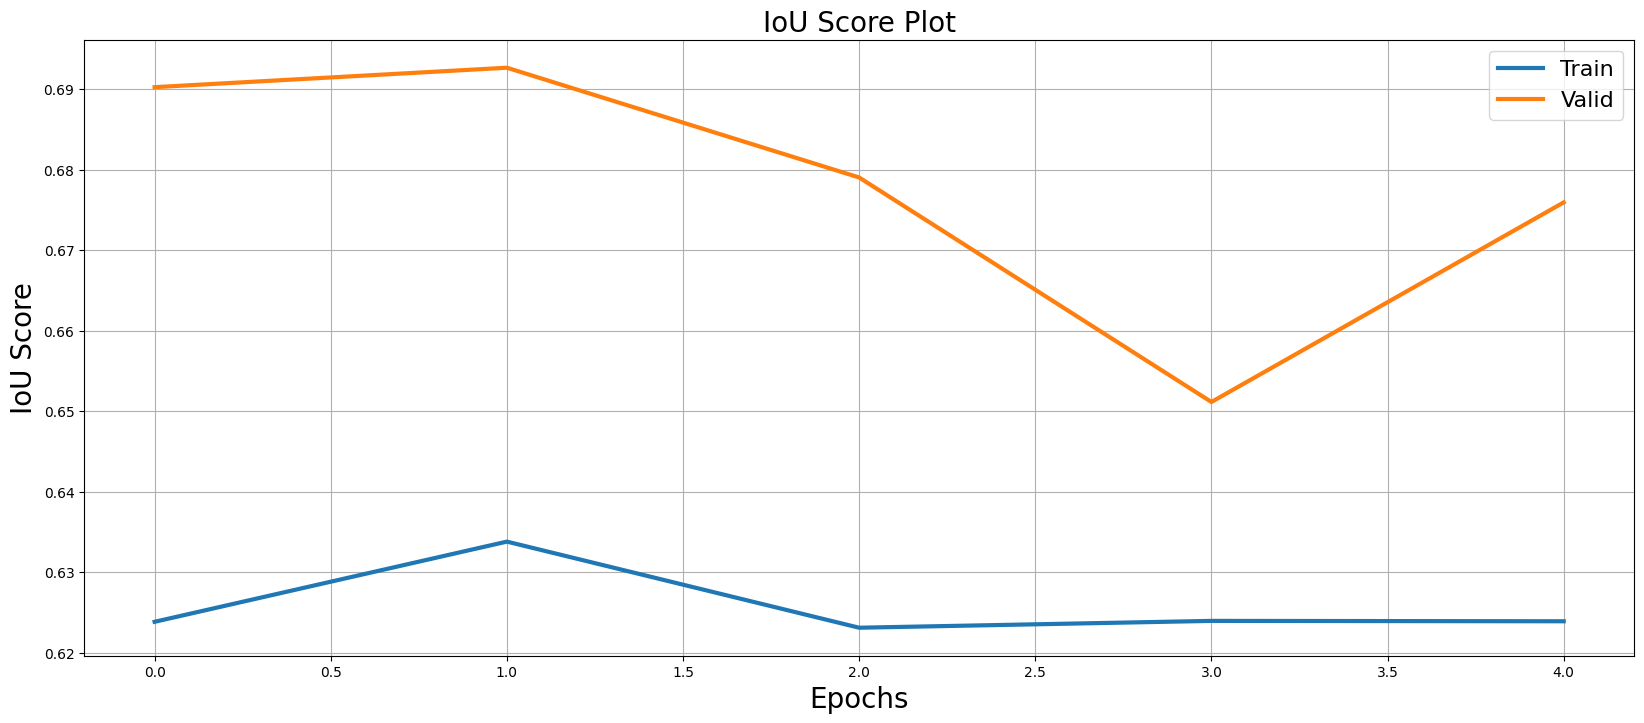

In [48]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

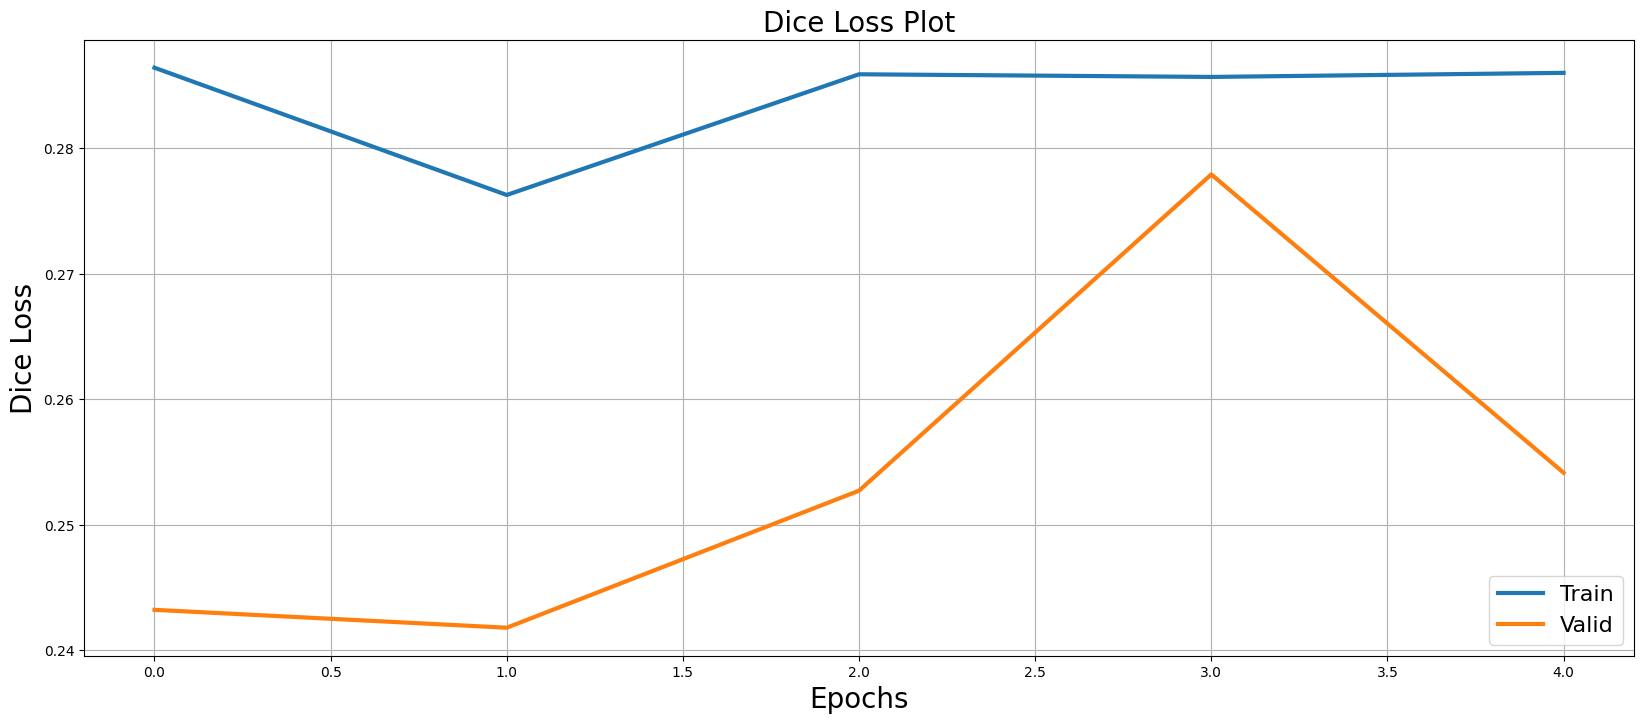

In [49]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()